# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

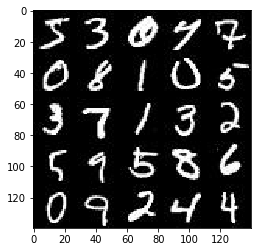

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

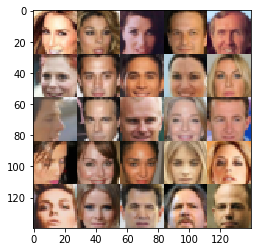

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.2.1
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    print('image_width, image_height, image_channels',image_width, image_height, image_channels)
    input_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name = 'input_real')
    print('z_dim',z_dim)
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name = 'input_z')
    learning_rate = tf.placeholder(tf.float32, [], name = 'input_lr')

    return input_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

image_width, image_height, image_channels 28 28 3
z_dim 100
Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
# Constant for the leaky relu.
alpha = 0.2

def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 32x32x3    28x28xOUT
        x1 = tf.layers.conv2d(images, 64, 5, strides = 2, padding = 'same')
        relu1 = tf.maximum(alpha*x1, x1)
        # 16x16x64  14x14xOUT
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides = 2, padding = 'same')
        bn2 = tf.layers.batch_normalization(x2, training = True)
        relu2 = tf.maximum(alpha*bn2, bn2)
        # 8x8x128   7x7xOUT
        
        # x3 = tf.layers.conv2d(relu2, 256, 5, strides = 2, padding = 'same')
        # bn3 = tf.layers.batch_normalization(x3, training = True)
        # relu3 = tf.maximum(alpha*bn3, bn3)
        # 4x4x256
        
        flat = tf.reshape(relu2, (-1, 7*7*128) )
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    with tf.variable_scope('generator', reuse = not is_train):
        # First fully connected layer
        x = tf.layers.dense(z, 7*7*256)
        # Reshape it to start the convolution stack
        x1 = tf.reshape(x, (-1, 7, 7, 256) )
        x1 = tf.layers.batch_normalization(x1, training = is_train)
        x1 = tf.maximum(alpha*x1, x1)
        # 4x4x512 now      7x7xOUT
        
        x2 = tf.layers.conv2d_transpose(x1, 128, 5, strides = 2, padding = 'same')
        x2 = tf.layers.batch_normalization(x2, training = is_train)
        x2 = tf.maximum(alpha*x2, x2)
        # 8x8x256 now     14x14xOUT   
        
        # x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides = 2, padding = 'same')
        # x3 = tf.layers.batch_normalization(x3, training = is_train)
        # x3 = tf.maximum(alpha*x3, x3)
        # 16x16x128     28x28xOUT
     
        # Output layer, 32x32x3  28x28xOUT
        logits = tf.layers.conv2d_transpose(x2, out_channel_dim, 5, strides = 2, padding = 'same')
        
        out = tf.tanh(logits)
        
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
import pickle as pkl
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # tf.reset_default_graph()
    print('*data_shape[1:4]',*data_shape[1:4])
    print('z_dim',z_dim)
    input_real, input_z, input_lr = model_inputs(*data_shape[1:4], z_dim)
    out_channel_dim = data_shape[3]
    d_loss, g_loss = model_loss(input_real, input_z, out_channel_dim)
 
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, input_lr, beta1)
                
    saver = tf.train.Saver()
    sample_z = np.random.uniform(-1, 1, size=(72, z_dim))
    
    samples, losses = [], []
    steps = 0
    print_every = 10
    show_every = 100
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
        
            print('epoch_i', epoch_i)
            for batch_images in get_batches(batch_size):
                steps += 1

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_train_opt, feed_dict={input_real: batch_images, input_z: batch_z, input_lr: learning_rate})
                _ = sess.run(g_train_opt, feed_dict={input_real: batch_images, input_z: batch_z, input_lr: learning_rate})

                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % show_every == 0:
                    gen_samples = sess.run(
                                   generator(input_z, out_channel_dim, is_train=False),
                                   feed_dict={input_z: sample_z})
                    samples.append(gen_samples)

                    show_generator_output(sess, 5, input_z, out_channel_dim, data_image_mode)

        saver.save(sess, './checkpoints/generator.ckpt')

    with open('samples.pkl', 'wb') as f:
        pkl.dump(samples, f)
    
    return losses, samples     

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

*data_shape[1:4] 28 28 1
z_dim 10
image_width, image_height, image_channels 28 28 1
z_dim 10
epoch_i 0
Epoch 1/2... Discriminator Loss: 2.1180... Generator Loss: 0.4046
Epoch 1/2... Discriminator Loss: 1.9464... Generator Loss: 0.4755
Epoch 1/2... Discriminator Loss: 1.3302... Generator Loss: 0.7492
Epoch 1/2... Discriminator Loss: 1.3453... Generator Loss: 0.5141
Epoch 1/2... Discriminator Loss: 0.9035... Generator Loss: 1.2886
Epoch 1/2... Discriminator Loss: 1.2338... Generator Loss: 0.5764
Epoch 1/2... Discriminator Loss: 1.5255... Generator Loss: 4.0629
Epoch 1/2... Discriminator Loss: 1.0512... Generator Loss: 0.9112
Epoch 1/2... Discriminator Loss: 0.5561... Generator Loss: 2.0744
Epoch 1/2... Discriminator Loss: 1.0644... Generator Loss: 1.4419


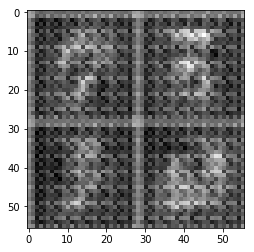

Epoch 1/2... Discriminator Loss: 0.5713... Generator Loss: 2.0058
Epoch 1/2... Discriminator Loss: 0.8372... Generator Loss: 0.8424
Epoch 1/2... Discriminator Loss: 0.7605... Generator Loss: 1.0242
Epoch 1/2... Discriminator Loss: 0.6015... Generator Loss: 1.7645
Epoch 1/2... Discriminator Loss: 1.0794... Generator Loss: 0.5701
Epoch 1/2... Discriminator Loss: 0.9590... Generator Loss: 1.2370
Epoch 1/2... Discriminator Loss: 0.8611... Generator Loss: 1.1771
Epoch 1/2... Discriminator Loss: 1.0625... Generator Loss: 0.5711
Epoch 1/2... Discriminator Loss: 0.6924... Generator Loss: 1.0959
Epoch 1/2... Discriminator Loss: 0.4872... Generator Loss: 2.0534


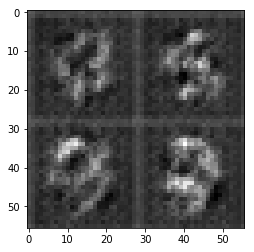

Epoch 1/2... Discriminator Loss: 0.6153... Generator Loss: 1.4669
Epoch 1/2... Discriminator Loss: 0.5705... Generator Loss: 1.6273
Epoch 1/2... Discriminator Loss: 0.6093... Generator Loss: 1.1803
Epoch 1/2... Discriminator Loss: 0.5151... Generator Loss: 1.8548
Epoch 1/2... Discriminator Loss: 0.3045... Generator Loss: 2.9212
Epoch 1/2... Discriminator Loss: 1.4056... Generator Loss: 0.3446
Epoch 1/2... Discriminator Loss: 0.3382... Generator Loss: 2.3063
Epoch 1/2... Discriminator Loss: 0.6738... Generator Loss: 2.9013
Epoch 1/2... Discriminator Loss: 1.2490... Generator Loss: 0.4156
Epoch 1/2... Discriminator Loss: 0.7262... Generator Loss: 1.0126


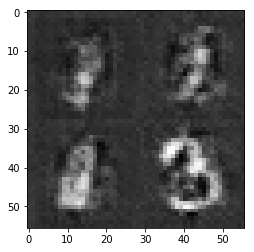

Epoch 1/2... Discriminator Loss: 0.4110... Generator Loss: 1.8891
Epoch 1/2... Discriminator Loss: 0.7495... Generator Loss: 5.7261
Epoch 1/2... Discriminator Loss: 0.6516... Generator Loss: 0.9629
Epoch 1/2... Discriminator Loss: 0.3245... Generator Loss: 2.1813
Epoch 1/2... Discriminator Loss: 0.2302... Generator Loss: 3.2905
Epoch 1/2... Discriminator Loss: 0.3631... Generator Loss: 2.8545
Epoch 1/2... Discriminator Loss: 0.3706... Generator Loss: 2.0940
Epoch 1/2... Discriminator Loss: 0.3693... Generator Loss: 1.8259
Epoch 1/2... Discriminator Loss: 0.4108... Generator Loss: 1.5695
Epoch 1/2... Discriminator Loss: 1.0456... Generator Loss: 0.5555


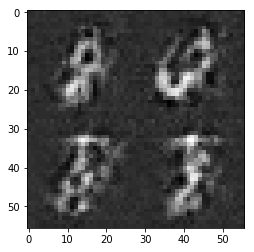

Epoch 1/2... Discriminator Loss: 0.4371... Generator Loss: 3.5555
Epoch 1/2... Discriminator Loss: 0.2951... Generator Loss: 2.1190
Epoch 1/2... Discriminator Loss: 0.8201... Generator Loss: 0.7331
Epoch 1/2... Discriminator Loss: 0.6413... Generator Loss: 1.2268
Epoch 1/2... Discriminator Loss: 0.2317... Generator Loss: 2.5900
Epoch 1/2... Discriminator Loss: 0.2532... Generator Loss: 4.2592
Epoch 1/2... Discriminator Loss: 0.3373... Generator Loss: 3.1641
Epoch 1/2... Discriminator Loss: 0.2347... Generator Loss: 3.0794
Epoch 1/2... Discriminator Loss: 1.2466... Generator Loss: 0.4309
Epoch 1/2... Discriminator Loss: 0.2038... Generator Loss: 2.9134


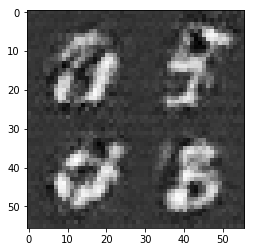

Epoch 1/2... Discriminator Loss: 0.4898... Generator Loss: 1.1745
Epoch 1/2... Discriminator Loss: 0.1883... Generator Loss: 2.5138
Epoch 1/2... Discriminator Loss: 0.3474... Generator Loss: 2.1869
Epoch 1/2... Discriminator Loss: 0.2805... Generator Loss: 1.9656
Epoch 1/2... Discriminator Loss: 0.2190... Generator Loss: 2.3147
Epoch 1/2... Discriminator Loss: 0.1973... Generator Loss: 3.8676
Epoch 1/2... Discriminator Loss: 0.2347... Generator Loss: 2.9488
Epoch 1/2... Discriminator Loss: 0.2572... Generator Loss: 1.7799
Epoch 1/2... Discriminator Loss: 0.2878... Generator Loss: 1.6852
Epoch 1/2... Discriminator Loss: 0.8429... Generator Loss: 0.6476


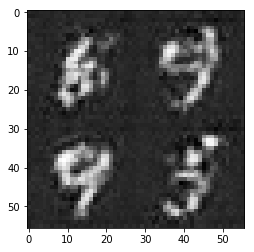

Epoch 1/2... Discriminator Loss: 0.3412... Generator Loss: 1.7787
Epoch 1/2... Discriminator Loss: 0.2516... Generator Loss: 1.9967
Epoch 1/2... Discriminator Loss: 0.2292... Generator Loss: 2.0737
Epoch 1/2... Discriminator Loss: 0.0706... Generator Loss: 4.6781
Epoch 1/2... Discriminator Loss: 0.1098... Generator Loss: 2.8819
Epoch 1/2... Discriminator Loss: 0.3274... Generator Loss: 1.8860
Epoch 1/2... Discriminator Loss: 0.2084... Generator Loss: 3.1486
Epoch 1/2... Discriminator Loss: 0.4413... Generator Loss: 4.0153
Epoch 1/2... Discriminator Loss: 0.1001... Generator Loss: 3.3394
Epoch 1/2... Discriminator Loss: 0.1499... Generator Loss: 4.2828


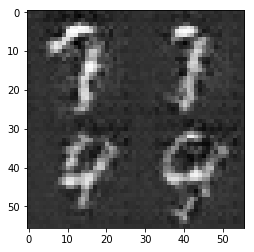

Epoch 1/2... Discriminator Loss: 0.1134... Generator Loss: 4.3384
Epoch 1/2... Discriminator Loss: 0.1712... Generator Loss: 2.4412
Epoch 1/2... Discriminator Loss: 0.9540... Generator Loss: 4.6023
Epoch 1/2... Discriminator Loss: 0.4654... Generator Loss: 1.7775
Epoch 1/2... Discriminator Loss: 0.4028... Generator Loss: 2.4416
Epoch 1/2... Discriminator Loss: 0.1644... Generator Loss: 2.6804
Epoch 1/2... Discriminator Loss: 0.1466... Generator Loss: 2.8807
Epoch 1/2... Discriminator Loss: 0.2012... Generator Loss: 2.4888
Epoch 1/2... Discriminator Loss: 0.1530... Generator Loss: 3.9742
Epoch 1/2... Discriminator Loss: 0.3215... Generator Loss: 2.3065


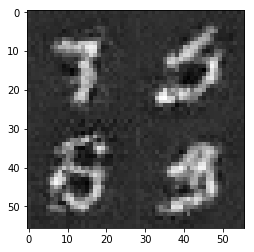

Epoch 1/2... Discriminator Loss: 0.3378... Generator Loss: 2.3330
Epoch 1/2... Discriminator Loss: 0.2833... Generator Loss: 1.9182
Epoch 1/2... Discriminator Loss: 0.1967... Generator Loss: 2.3647
Epoch 1/2... Discriminator Loss: 0.2082... Generator Loss: 4.2074
Epoch 1/2... Discriminator Loss: 0.1453... Generator Loss: 2.7367
Epoch 1/2... Discriminator Loss: 0.1765... Generator Loss: 2.4883
Epoch 1/2... Discriminator Loss: 0.1920... Generator Loss: 2.4536
Epoch 1/2... Discriminator Loss: 0.1518... Generator Loss: 2.5655
Epoch 1/2... Discriminator Loss: 0.1188... Generator Loss: 3.2504
Epoch 1/2... Discriminator Loss: 0.1064... Generator Loss: 3.0561


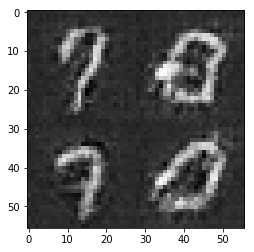

Epoch 1/2... Discriminator Loss: 0.5267... Generator Loss: 1.0740
Epoch 1/2... Discriminator Loss: 1.2156... Generator Loss: 0.5784
Epoch 1/2... Discriminator Loss: 0.5282... Generator Loss: 1.5498
epoch_i 1
Epoch 2/2... Discriminator Loss: 0.4393... Generator Loss: 2.2918
Epoch 2/2... Discriminator Loss: 0.3307... Generator Loss: 2.1136
Epoch 2/2... Discriminator Loss: 0.4740... Generator Loss: 1.7117
Epoch 2/2... Discriminator Loss: 0.2866... Generator Loss: 2.5325
Epoch 2/2... Discriminator Loss: 0.6643... Generator Loss: 1.8096
Epoch 2/2... Discriminator Loss: 0.3966... Generator Loss: 1.8050
Epoch 2/2... Discriminator Loss: 0.4007... Generator Loss: 1.5133


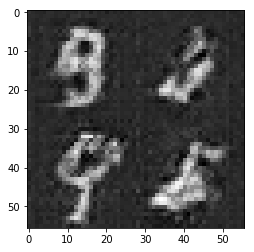

Epoch 2/2... Discriminator Loss: 0.2683... Generator Loss: 2.4349
Epoch 2/2... Discriminator Loss: 0.1844... Generator Loss: 2.6150
Epoch 2/2... Discriminator Loss: 0.2197... Generator Loss: 2.3830
Epoch 2/2... Discriminator Loss: 0.1750... Generator Loss: 3.1650
Epoch 2/2... Discriminator Loss: 0.1294... Generator Loss: 3.2623
Epoch 2/2... Discriminator Loss: 0.1198... Generator Loss: 3.5090
Epoch 2/2... Discriminator Loss: 0.1537... Generator Loss: 3.7871
Epoch 2/2... Discriminator Loss: 0.1384... Generator Loss: 3.5948
Epoch 2/2... Discriminator Loss: 0.0962... Generator Loss: 3.1616
Epoch 2/2... Discriminator Loss: 0.1218... Generator Loss: 3.3749


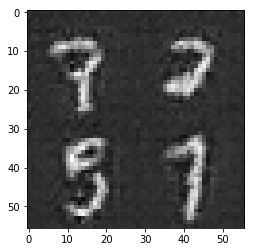

Epoch 2/2... Discriminator Loss: 0.4302... Generator Loss: 3.3593
Epoch 2/2... Discriminator Loss: 0.4259... Generator Loss: 2.0518
Epoch 2/2... Discriminator Loss: 0.3911... Generator Loss: 1.4937
Epoch 2/2... Discriminator Loss: 0.3415... Generator Loss: 2.5854
Epoch 2/2... Discriminator Loss: 0.6233... Generator Loss: 1.0016
Epoch 2/2... Discriminator Loss: 0.1656... Generator Loss: 3.0726
Epoch 2/2... Discriminator Loss: 0.2329... Generator Loss: 2.4319
Epoch 2/2... Discriminator Loss: 0.1271... Generator Loss: 3.9111
Epoch 2/2... Discriminator Loss: 1.4105... Generator Loss: 1.3935
Epoch 2/2... Discriminator Loss: 1.2871... Generator Loss: 0.4812


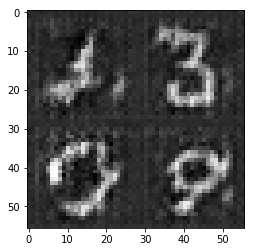

Epoch 2/2... Discriminator Loss: 0.9277... Generator Loss: 0.8569
Epoch 2/2... Discriminator Loss: 0.6560... Generator Loss: 3.2346
Epoch 2/2... Discriminator Loss: 0.6568... Generator Loss: 0.9687
Epoch 2/2... Discriminator Loss: 0.5512... Generator Loss: 3.1250
Epoch 2/2... Discriminator Loss: 0.2981... Generator Loss: 1.8259
Epoch 2/2... Discriminator Loss: 0.1220... Generator Loss: 3.0361
Epoch 2/2... Discriminator Loss: 0.2192... Generator Loss: 3.6819
Epoch 2/2... Discriminator Loss: 0.1374... Generator Loss: 3.0611
Epoch 2/2... Discriminator Loss: 0.1012... Generator Loss: 3.8241
Epoch 2/2... Discriminator Loss: 0.1748... Generator Loss: 2.2667


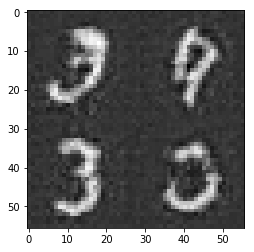

Epoch 2/2... Discriminator Loss: 0.2536... Generator Loss: 1.9310
Epoch 2/2... Discriminator Loss: 0.3987... Generator Loss: 1.7562
Epoch 2/2... Discriminator Loss: 0.3709... Generator Loss: 1.4475
Epoch 2/2... Discriminator Loss: 0.2451... Generator Loss: 2.3962
Epoch 2/2... Discriminator Loss: 2.7191... Generator Loss: 5.2494
Epoch 2/2... Discriminator Loss: 0.2947... Generator Loss: 2.0444
Epoch 2/2... Discriminator Loss: 1.0682... Generator Loss: 4.9534
Epoch 2/2... Discriminator Loss: 0.2095... Generator Loss: 2.6237
Epoch 2/2... Discriminator Loss: 0.1520... Generator Loss: 2.7525
Epoch 2/2... Discriminator Loss: 0.5905... Generator Loss: 1.1161


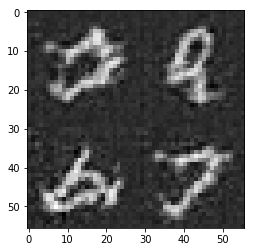

Epoch 2/2... Discriminator Loss: 0.2751... Generator Loss: 3.8063
Epoch 2/2... Discriminator Loss: 0.1896... Generator Loss: 2.7983
Epoch 2/2... Discriminator Loss: 0.1429... Generator Loss: 4.6886
Epoch 2/2... Discriminator Loss: 0.2849... Generator Loss: 1.7712
Epoch 2/2... Discriminator Loss: 0.3659... Generator Loss: 1.5411
Epoch 2/2... Discriminator Loss: 0.1431... Generator Loss: 2.7927
Epoch 2/2... Discriminator Loss: 0.1486... Generator Loss: 2.7143
Epoch 2/2... Discriminator Loss: 0.1296... Generator Loss: 3.3884
Epoch 2/2... Discriminator Loss: 0.1499... Generator Loss: 2.7740
Epoch 2/2... Discriminator Loss: 0.0649... Generator Loss: 4.3899


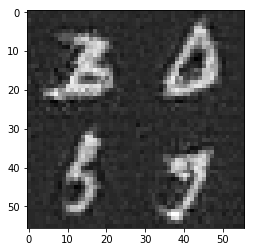

Epoch 2/2... Discriminator Loss: 0.6287... Generator Loss: 1.0089
Epoch 2/2... Discriminator Loss: 0.2637... Generator Loss: 2.2167
Epoch 2/2... Discriminator Loss: 0.2912... Generator Loss: 2.3637
Epoch 2/2... Discriminator Loss: 0.2291... Generator Loss: 2.6264
Epoch 2/2... Discriminator Loss: 0.1699... Generator Loss: 2.5540
Epoch 2/2... Discriminator Loss: 0.6278... Generator Loss: 5.8917
Epoch 2/2... Discriminator Loss: 0.2447... Generator Loss: 1.8863
Epoch 2/2... Discriminator Loss: 0.1450... Generator Loss: 3.1935
Epoch 2/2... Discriminator Loss: 0.0933... Generator Loss: 4.2578
Epoch 2/2... Discriminator Loss: 0.2162... Generator Loss: 2.1368


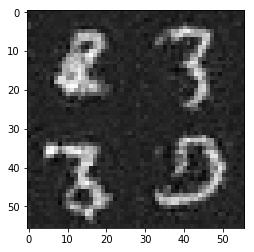

Epoch 2/2... Discriminator Loss: 0.1119... Generator Loss: 3.0049
Epoch 2/2... Discriminator Loss: 0.0530... Generator Loss: 3.8956
Epoch 2/2... Discriminator Loss: 0.9865... Generator Loss: 0.7046
Epoch 2/2... Discriminator Loss: 0.5371... Generator Loss: 1.2354
Epoch 2/2... Discriminator Loss: 1.2709... Generator Loss: 2.5535
Epoch 2/2... Discriminator Loss: 0.4219... Generator Loss: 1.7420
Epoch 2/2... Discriminator Loss: 0.3206... Generator Loss: 2.1252
Epoch 2/2... Discriminator Loss: 0.2628... Generator Loss: 3.2900
Epoch 2/2... Discriminator Loss: 0.0900... Generator Loss: 3.5270
Epoch 2/2... Discriminator Loss: 0.1220... Generator Loss: 3.6001


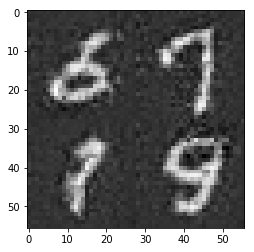

Epoch 2/2... Discriminator Loss: 0.2904... Generator Loss: 4.8997
Epoch 2/2... Discriminator Loss: 0.3675... Generator Loss: 1.6091
Epoch 2/2... Discriminator Loss: 0.1049... Generator Loss: 3.2060
Epoch 2/2... Discriminator Loss: 0.0934... Generator Loss: 3.4908
Epoch 2/2... Discriminator Loss: 0.1213... Generator Loss: 2.8232
Epoch 2/2... Discriminator Loss: 0.1774... Generator Loss: 2.4036
Epoch 2/2... Discriminator Loss: 0.1089... Generator Loss: 2.8797
Epoch 2/2... Discriminator Loss: 0.1303... Generator Loss: 2.8973
Epoch 2/2... Discriminator Loss: 0.1050... Generator Loss: 3.7174
Epoch 2/2... Discriminator Loss: 0.9081... Generator Loss: 1.7077


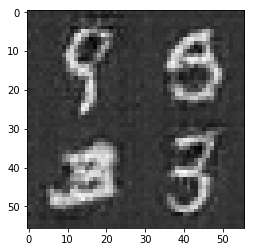

Epoch 2/2... Discriminator Loss: 0.7622... Generator Loss: 2.7255
Epoch 2/2... Discriminator Loss: 0.4910... Generator Loss: 1.5039
Epoch 2/2... Discriminator Loss: 0.5758... Generator Loss: 1.3709
Epoch 2/2... Discriminator Loss: 0.3935... Generator Loss: 1.7065
Epoch 2/2... Discriminator Loss: 0.1823... Generator Loss: 2.5817
Epoch 2/2... Discriminator Loss: 0.2018... Generator Loss: 2.4249
Epoch 2/2... Discriminator Loss: 0.1357... Generator Loss: 2.7092


In [ ]:
batch_size = 64
z_dim = 10
learning_rate = 0.0005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

*data_shape[1:4] 28 28 3
z_dim 100
image_width, image_height, image_channels 28 28 3
z_dim 100
epoch_i 0
Epoch 1/30... Discriminator Loss: 2.3496... Generator Loss: 0.2526
Epoch 1/30... Discriminator Loss: 1.1943... Generator Loss: 0.9957
Epoch 1/30... Discriminator Loss: 1.1379... Generator Loss: 1.7369
Epoch 1/30... Discriminator Loss: 0.8913... Generator Loss: 1.0148
Epoch 1/30... Discriminator Loss: 0.3333... Generator Loss: 2.9946
Epoch 1/30... Discriminator Loss: 0.2026... Generator Loss: 2.4891
Epoch 1/30... Discriminator Loss: 0.1069... Generator Loss: 3.0749
Epoch 1/30... Discriminator Loss: 0.2437... Generator Loss: 8.3053
Epoch 1/30... Discriminator Loss: 0.2604... Generator Loss: 1.6914
Epoch 1/30... Discriminator Loss: 0.1176... Generator Loss: 5.7855


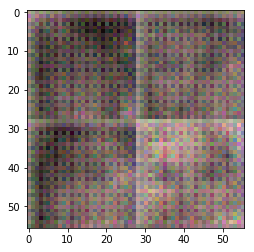

Epoch 1/30... Discriminator Loss: 0.3604... Generator Loss: 1.3752
Epoch 1/30... Discriminator Loss: 1.2467... Generator Loss: 0.4168
Epoch 1/30... Discriminator Loss: 0.2022... Generator Loss: 4.4801
Epoch 1/30... Discriminator Loss: 0.8880... Generator Loss: 0.7719
Epoch 1/30... Discriminator Loss: 2.2553... Generator Loss: 0.1446
Epoch 1/30... Discriminator Loss: 0.1473... Generator Loss: 11.7457
Epoch 1/30... Discriminator Loss: 0.2671... Generator Loss: 3.1564
Epoch 1/30... Discriminator Loss: 0.2016... Generator Loss: 2.0625
Epoch 1/30... Discriminator Loss: 0.5013... Generator Loss: 8.6088
Epoch 1/30... Discriminator Loss: 0.2607... Generator Loss: 2.3420


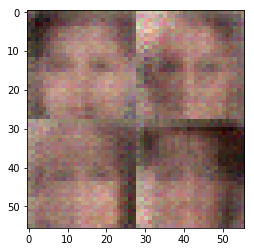

Epoch 1/30... Discriminator Loss: 1.1323... Generator Loss: 0.4821
Epoch 1/30... Discriminator Loss: 0.8395... Generator Loss: 0.6650
Epoch 1/30... Discriminator Loss: 0.5399... Generator Loss: 1.6871
Epoch 1/30... Discriminator Loss: 0.3746... Generator Loss: 2.0340
Epoch 1/30... Discriminator Loss: 0.9041... Generator Loss: 0.7041
Epoch 1/30... Discriminator Loss: 0.1936... Generator Loss: 2.3749
Epoch 1/30... Discriminator Loss: 0.0571... Generator Loss: 6.2721
Epoch 1/30... Discriminator Loss: 1.2374... Generator Loss: 0.4244
Epoch 1/30... Discriminator Loss: 0.5098... Generator Loss: 1.5964
Epoch 1/30... Discriminator Loss: 1.0111... Generator Loss: 1.3180


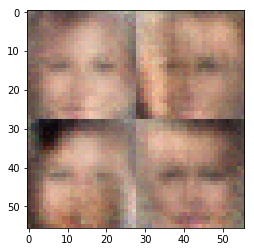

Epoch 1/30... Discriminator Loss: 1.0592... Generator Loss: 0.5584
Epoch 1/30... Discriminator Loss: 0.3259... Generator Loss: 2.0204
Epoch 1/30... Discriminator Loss: 1.5010... Generator Loss: 4.2197
Epoch 1/30... Discriminator Loss: 0.6566... Generator Loss: 2.0959
Epoch 1/30... Discriminator Loss: 1.6224... Generator Loss: 0.2752
Epoch 1/30... Discriminator Loss: 0.4089... Generator Loss: 2.0430
Epoch 1/30... Discriminator Loss: 0.7356... Generator Loss: 0.9529
Epoch 1/30... Discriminator Loss: 0.2301... Generator Loss: 3.5037
Epoch 1/30... Discriminator Loss: 0.2501... Generator Loss: 6.4610
Epoch 1/30... Discriminator Loss: 1.7335... Generator Loss: 0.2456


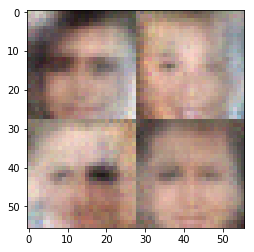

Epoch 1/30... Discriminator Loss: 0.1264... Generator Loss: 5.3341
Epoch 1/30... Discriminator Loss: 0.4313... Generator Loss: 1.5480
Epoch 1/30... Discriminator Loss: 0.2882... Generator Loss: 2.4762
Epoch 1/30... Discriminator Loss: 0.9933... Generator Loss: 0.6183
Epoch 1/30... Discriminator Loss: 0.5412... Generator Loss: 1.5208
Epoch 1/30... Discriminator Loss: 0.4129... Generator Loss: 2.0909
Epoch 1/30... Discriminator Loss: 0.1917... Generator Loss: 3.6352
Epoch 1/30... Discriminator Loss: 0.1559... Generator Loss: 4.1571
Epoch 1/30... Discriminator Loss: 0.2595... Generator Loss: 2.8662
Epoch 1/30... Discriminator Loss: 0.4263... Generator Loss: 6.3892


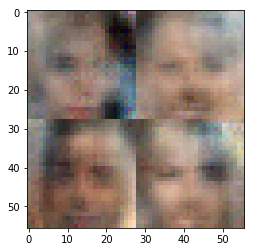

Epoch 1/30... Discriminator Loss: 0.3028... Generator Loss: 4.6209
Epoch 1/30... Discriminator Loss: 0.1233... Generator Loss: 5.4055
Epoch 1/30... Discriminator Loss: 0.1694... Generator Loss: 6.5270
Epoch 1/30... Discriminator Loss: 0.3698... Generator Loss: 2.4868
Epoch 1/30... Discriminator Loss: 0.1096... Generator Loss: 4.5425
Epoch 1/30... Discriminator Loss: 0.2410... Generator Loss: 3.0908
Epoch 1/30... Discriminator Loss: 0.5699... Generator Loss: 1.4615
Epoch 1/30... Discriminator Loss: 0.2345... Generator Loss: 3.6579
Epoch 1/30... Discriminator Loss: 0.1647... Generator Loss: 6.4599
Epoch 1/30... Discriminator Loss: 0.1994... Generator Loss: 5.6919


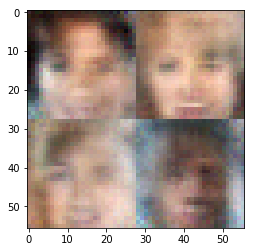

Epoch 1/30... Discriminator Loss: 0.6523... Generator Loss: 6.0654
Epoch 1/30... Discriminator Loss: 1.0159... Generator Loss: 0.7166
Epoch 1/30... Discriminator Loss: 0.1560... Generator Loss: 5.7679
Epoch 1/30... Discriminator Loss: 0.1834... Generator Loss: 7.4728
Epoch 1/30... Discriminator Loss: 0.2543... Generator Loss: 5.0645
Epoch 1/30... Discriminator Loss: 0.1503... Generator Loss: 5.7628
Epoch 1/30... Discriminator Loss: 0.9896... Generator Loss: 0.7981
Epoch 1/30... Discriminator Loss: 0.1103... Generator Loss: 6.7093
Epoch 1/30... Discriminator Loss: 0.3232... Generator Loss: 4.5420
Epoch 1/30... Discriminator Loss: 0.3139... Generator Loss: 3.0311


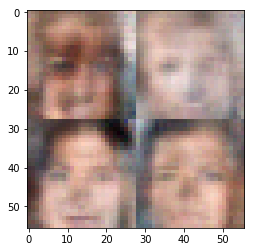

Epoch 1/30... Discriminator Loss: 0.7455... Generator Loss: 1.3249
Epoch 1/30... Discriminator Loss: 0.0550... Generator Loss: 6.3798
Epoch 1/30... Discriminator Loss: 0.1965... Generator Loss: 6.0400
Epoch 1/30... Discriminator Loss: 0.1665... Generator Loss: 9.4722
Epoch 1/30... Discriminator Loss: 0.9785... Generator Loss: 14.4287
Epoch 1/30... Discriminator Loss: 0.2562... Generator Loss: 8.4339
Epoch 1/30... Discriminator Loss: 0.2162... Generator Loss: 2.7654
Epoch 1/30... Discriminator Loss: 0.4589... Generator Loss: 9.0235
Epoch 1/30... Discriminator Loss: 0.7618... Generator Loss: 1.9900
Epoch 1/30... Discriminator Loss: 0.2462... Generator Loss: 5.3641


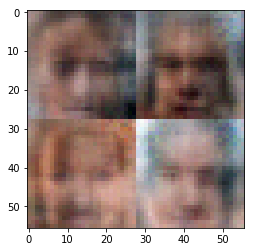

Epoch 1/30... Discriminator Loss: 1.1192... Generator Loss: 2.0172
Epoch 1/30... Discriminator Loss: 0.1905... Generator Loss: 5.1488
Epoch 1/30... Discriminator Loss: 0.4943... Generator Loss: 7.0537
Epoch 1/30... Discriminator Loss: 0.2474... Generator Loss: 4.1115
Epoch 1/30... Discriminator Loss: 0.3481... Generator Loss: 2.3558
Epoch 1/30... Discriminator Loss: 1.4068... Generator Loss: 12.9333
Epoch 1/30... Discriminator Loss: 0.1588... Generator Loss: 6.3236
Epoch 1/30... Discriminator Loss: 0.1303... Generator Loss: 6.6784
Epoch 1/30... Discriminator Loss: 0.9308... Generator Loss: 9.5450
Epoch 1/30... Discriminator Loss: 0.2685... Generator Loss: 3.8490


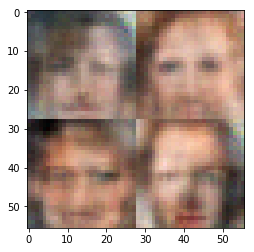

Epoch 1/30... Discriminator Loss: 0.4005... Generator Loss: 3.5125
Epoch 1/30... Discriminator Loss: 0.2102... Generator Loss: 4.4440
Epoch 1/30... Discriminator Loss: 0.7897... Generator Loss: 0.9460
Epoch 1/30... Discriminator Loss: 0.1339... Generator Loss: 7.1547
Epoch 1/30... Discriminator Loss: 0.0975... Generator Loss: 9.1087
Epoch 1/30... Discriminator Loss: 0.1345... Generator Loss: 7.6104
Epoch 1/30... Discriminator Loss: 0.3988... Generator Loss: 2.1743
Epoch 1/30... Discriminator Loss: 0.5625... Generator Loss: 2.3821
Epoch 1/30... Discriminator Loss: 0.3650... Generator Loss: 9.2626
Epoch 1/30... Discriminator Loss: 0.2662... Generator Loss: 4.1816


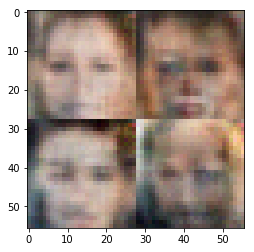

Epoch 1/30... Discriminator Loss: 0.3241... Generator Loss: 2.6528
Epoch 1/30... Discriminator Loss: 0.1435... Generator Loss: 6.0235
Epoch 1/30... Discriminator Loss: 0.3663... Generator Loss: 2.0775
Epoch 1/30... Discriminator Loss: 0.1238... Generator Loss: 8.5711
Epoch 1/30... Discriminator Loss: 1.8504... Generator Loss: 6.0343
Epoch 1/30... Discriminator Loss: 0.5374... Generator Loss: 2.5931
Epoch 1/30... Discriminator Loss: 0.1739... Generator Loss: 5.5860
Epoch 1/30... Discriminator Loss: 0.3622... Generator Loss: 3.0810
Epoch 1/30... Discriminator Loss: 0.1816... Generator Loss: 5.0995
Epoch 1/30... Discriminator Loss: 0.4848... Generator Loss: 1.4297


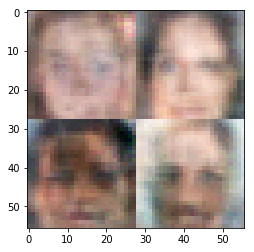

Epoch 1/30... Discriminator Loss: 0.3338... Generator Loss: 2.6447
Epoch 1/30... Discriminator Loss: 0.1772... Generator Loss: 5.6935
Epoch 1/30... Discriminator Loss: 0.4547... Generator Loss: 2.3402
Epoch 1/30... Discriminator Loss: 0.3921... Generator Loss: 7.8052
Epoch 1/30... Discriminator Loss: 0.1105... Generator Loss: 7.4321
Epoch 1/30... Discriminator Loss: 2.0592... Generator Loss: 0.5045
Epoch 1/30... Discriminator Loss: 0.2465... Generator Loss: 3.8639
Epoch 1/30... Discriminator Loss: 0.9989... Generator Loss: 1.2811
Epoch 1/30... Discriminator Loss: 0.2455... Generator Loss: 3.1220
Epoch 1/30... Discriminator Loss: 0.5950... Generator Loss: 6.0204


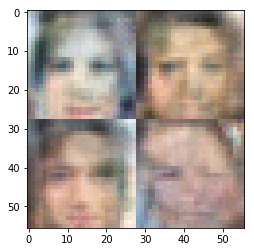

Epoch 1/30... Discriminator Loss: 0.5004... Generator Loss: 1.8203
Epoch 1/30... Discriminator Loss: 0.2572... Generator Loss: 5.1515
Epoch 1/30... Discriminator Loss: 0.2242... Generator Loss: 4.7697
Epoch 1/30... Discriminator Loss: 0.8612... Generator Loss: 1.1805
Epoch 1/30... Discriminator Loss: 0.9486... Generator Loss: 1.6436
Epoch 1/30... Discriminator Loss: 0.3555... Generator Loss: 3.5933
Epoch 1/30... Discriminator Loss: 0.4437... Generator Loss: 5.4080
Epoch 1/30... Discriminator Loss: 0.3758... Generator Loss: 4.5485
Epoch 1/30... Discriminator Loss: 0.6113... Generator Loss: 1.3005
Epoch 1/30... Discriminator Loss: 0.2403... Generator Loss: 10.1529


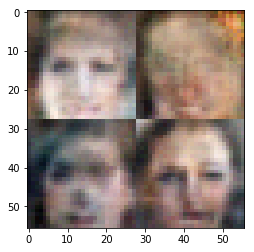

Epoch 1/30... Discriminator Loss: 0.1346... Generator Loss: 6.3681
Epoch 1/30... Discriminator Loss: 0.2261... Generator Loss: 3.6184
Epoch 1/30... Discriminator Loss: 0.5471... Generator Loss: 1.3802
Epoch 1/30... Discriminator Loss: 0.1491... Generator Loss: 5.8702
Epoch 1/30... Discriminator Loss: 0.1846... Generator Loss: 4.8984
Epoch 1/30... Discriminator Loss: 1.2326... Generator Loss: 1.0745
Epoch 1/30... Discriminator Loss: 0.2853... Generator Loss: 10.6800
Epoch 1/30... Discriminator Loss: 0.4248... Generator Loss: 2.9363
Epoch 1/30... Discriminator Loss: 0.4086... Generator Loss: 2.4207
Epoch 1/30... Discriminator Loss: 0.1463... Generator Loss: 7.7980


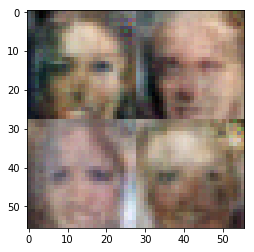

Epoch 1/30... Discriminator Loss: 0.3379... Generator Loss: 3.2329
Epoch 1/30... Discriminator Loss: 0.6122... Generator Loss: 1.0510
Epoch 1/30... Discriminator Loss: 0.3315... Generator Loss: 6.3179
Epoch 1/30... Discriminator Loss: 0.3931... Generator Loss: 7.8710
Epoch 1/30... Discriminator Loss: 0.5933... Generator Loss: 3.1805
Epoch 1/30... Discriminator Loss: 0.4117... Generator Loss: 1.8239
Epoch 1/30... Discriminator Loss: 2.5730... Generator Loss: 0.3862
Epoch 1/30... Discriminator Loss: 0.8825... Generator Loss: 0.9599
Epoch 1/30... Discriminator Loss: 0.4339... Generator Loss: 2.7620
Epoch 1/30... Discriminator Loss: 0.7551... Generator Loss: 1.4082


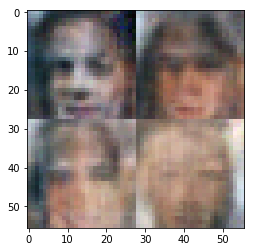

Epoch 1/30... Discriminator Loss: 0.1701... Generator Loss: 8.1060
Epoch 1/30... Discriminator Loss: 0.1230... Generator Loss: 5.9555
Epoch 1/30... Discriminator Loss: 0.0954... Generator Loss: 7.6062
Epoch 1/30... Discriminator Loss: 2.0160... Generator Loss: 0.5282
Epoch 1/30... Discriminator Loss: 0.3089... Generator Loss: 3.5339
Epoch 1/30... Discriminator Loss: 0.2879... Generator Loss: 2.5135
Epoch 1/30... Discriminator Loss: 0.2103... Generator Loss: 3.3302
Epoch 1/30... Discriminator Loss: 0.2091... Generator Loss: 6.2869
epoch_i 1
Epoch 2/30... Discriminator Loss: 1.2925... Generator Loss: 2.5532
Epoch 2/30... Discriminator Loss: 0.2539... Generator Loss: 4.3545


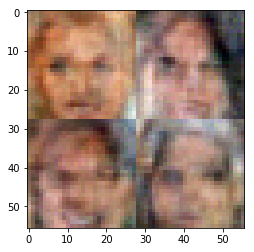

Epoch 2/30... Discriminator Loss: 0.3088... Generator Loss: 3.4093
Epoch 2/30... Discriminator Loss: 0.2542... Generator Loss: 4.4274
Epoch 2/30... Discriminator Loss: 1.1796... Generator Loss: 1.0377
Epoch 2/30... Discriminator Loss: 0.2973... Generator Loss: 3.2053
Epoch 2/30... Discriminator Loss: 0.2557... Generator Loss: 8.8569
Epoch 2/30... Discriminator Loss: 0.8185... Generator Loss: 11.3675
Epoch 2/30... Discriminator Loss: 0.5384... Generator Loss: 1.7370
Epoch 2/30... Discriminator Loss: 0.3828... Generator Loss: 2.8548
Epoch 2/30... Discriminator Loss: 1.1985... Generator Loss: 11.6664
Epoch 2/30... Discriminator Loss: 0.3884... Generator Loss: 3.0609


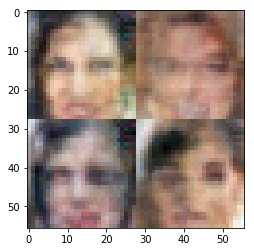

Epoch 2/30... Discriminator Loss: 0.3937... Generator Loss: 1.8918
Epoch 2/30... Discriminator Loss: 0.4726... Generator Loss: 3.1128
Epoch 2/30... Discriminator Loss: 0.1599... Generator Loss: 7.3537
Epoch 2/30... Discriminator Loss: 0.7940... Generator Loss: 3.4216
Epoch 2/30... Discriminator Loss: 0.1842... Generator Loss: 4.8862
Epoch 2/30... Discriminator Loss: 0.8260... Generator Loss: 9.9163
Epoch 2/30... Discriminator Loss: 0.3995... Generator Loss: 3.0887
Epoch 2/30... Discriminator Loss: 1.2439... Generator Loss: 0.6170
Epoch 2/30... Discriminator Loss: 0.6150... Generator Loss: 1.6368
Epoch 2/30... Discriminator Loss: 0.4037... Generator Loss: 3.2869


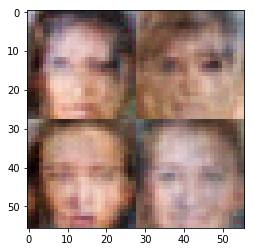

Epoch 2/30... Discriminator Loss: 0.2139... Generator Loss: 5.4756
Epoch 2/30... Discriminator Loss: 0.2441... Generator Loss: 3.0057
Epoch 2/30... Discriminator Loss: 0.1428... Generator Loss: 7.0897
Epoch 2/30... Discriminator Loss: 0.4100... Generator Loss: 6.6177
Epoch 2/30... Discriminator Loss: 0.2826... Generator Loss: 5.2344
Epoch 2/30... Discriminator Loss: 0.8960... Generator Loss: 0.9290
Epoch 2/30... Discriminator Loss: 0.6145... Generator Loss: 1.4548
Epoch 2/30... Discriminator Loss: 0.8196... Generator Loss: 8.9564
Epoch 2/30... Discriminator Loss: 0.2576... Generator Loss: 5.1813
Epoch 2/30... Discriminator Loss: 0.2398... Generator Loss: 4.5688


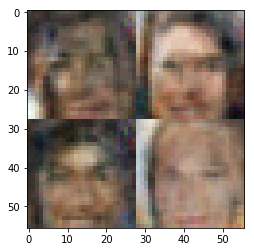

Epoch 2/30... Discriminator Loss: 0.5194... Generator Loss: 2.1571
Epoch 2/30... Discriminator Loss: 0.1926... Generator Loss: 4.0616
Epoch 2/30... Discriminator Loss: 0.6588... Generator Loss: 1.8884
Epoch 2/30... Discriminator Loss: 1.3988... Generator Loss: 1.9702
Epoch 2/30... Discriminator Loss: 0.3208... Generator Loss: 3.3032
Epoch 2/30... Discriminator Loss: 0.2697... Generator Loss: 3.0985
Epoch 2/30... Discriminator Loss: 0.2985... Generator Loss: 3.4224
Epoch 2/30... Discriminator Loss: 0.9470... Generator Loss: 1.1289
Epoch 2/30... Discriminator Loss: 0.2334... Generator Loss: 3.1500
Epoch 2/30... Discriminator Loss: 0.2470... Generator Loss: 5.2722


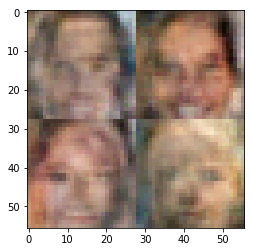

Epoch 2/30... Discriminator Loss: 0.1325... Generator Loss: 6.0833
Epoch 2/30... Discriminator Loss: 2.1355... Generator Loss: 1.6338
Epoch 2/30... Discriminator Loss: 0.4584... Generator Loss: 1.7704
Epoch 2/30... Discriminator Loss: 0.2850... Generator Loss: 2.9452
Epoch 2/30... Discriminator Loss: 0.2684... Generator Loss: 4.7641
Epoch 2/30... Discriminator Loss: 0.3917... Generator Loss: 6.4033
Epoch 2/30... Discriminator Loss: 1.1271... Generator Loss: 4.7787
Epoch 2/30... Discriminator Loss: 0.2842... Generator Loss: 3.2757
Epoch 2/30... Discriminator Loss: 0.1929... Generator Loss: 6.3628
Epoch 2/30... Discriminator Loss: 0.4110... Generator Loss: 2.0366


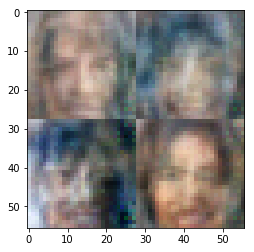

Epoch 2/30... Discriminator Loss: 0.4296... Generator Loss: 9.9841
Epoch 2/30... Discriminator Loss: 2.0346... Generator Loss: 4.3512
Epoch 2/30... Discriminator Loss: 0.7918... Generator Loss: 2.2283
Epoch 2/30... Discriminator Loss: 0.5496... Generator Loss: 2.0622
Epoch 2/30... Discriminator Loss: 0.6953... Generator Loss: 1.1226
Epoch 2/30... Discriminator Loss: 0.2089... Generator Loss: 8.7558
Epoch 2/30... Discriminator Loss: 0.2624... Generator Loss: 3.1365
Epoch 2/30... Discriminator Loss: 0.0965... Generator Loss: 5.5771
Epoch 2/30... Discriminator Loss: 1.2236... Generator Loss: 0.8356
Epoch 2/30... Discriminator Loss: 0.2493... Generator Loss: 3.1090


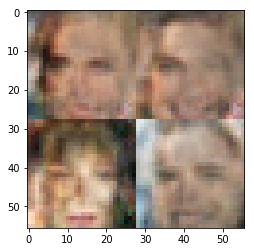

Epoch 2/30... Discriminator Loss: 1.7401... Generator Loss: 12.4346
Epoch 2/30... Discriminator Loss: 0.5398... Generator Loss: 2.3236
Epoch 2/30... Discriminator Loss: 0.2647... Generator Loss: 3.5922
Epoch 2/30... Discriminator Loss: 0.5588... Generator Loss: 1.5357
Epoch 2/30... Discriminator Loss: 0.1958... Generator Loss: 5.0140
Epoch 2/30... Discriminator Loss: 0.2619... Generator Loss: 3.6190
Epoch 2/30... Discriminator Loss: 0.5023... Generator Loss: 2.4929
Epoch 2/30... Discriminator Loss: 0.2261... Generator Loss: 4.7502
Epoch 2/30... Discriminator Loss: 0.3793... Generator Loss: 2.1620
Epoch 2/30... Discriminator Loss: 0.1793... Generator Loss: 5.7702


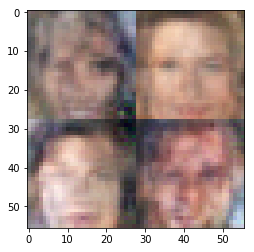

Epoch 2/30... Discriminator Loss: 0.5387... Generator Loss: 9.4690
Epoch 2/30... Discriminator Loss: 0.8389... Generator Loss: 1.6331
Epoch 2/30... Discriminator Loss: 0.9036... Generator Loss: 2.7487
Epoch 2/30... Discriminator Loss: 0.9914... Generator Loss: 0.8129
Epoch 2/30... Discriminator Loss: 0.5373... Generator Loss: 2.3498
Epoch 2/30... Discriminator Loss: 0.7313... Generator Loss: 1.2547
Epoch 2/30... Discriminator Loss: 0.2768... Generator Loss: 5.6272
Epoch 2/30... Discriminator Loss: 0.5512... Generator Loss: 4.3796
Epoch 2/30... Discriminator Loss: 1.9732... Generator Loss: 0.5116
Epoch 2/30... Discriminator Loss: 0.5791... Generator Loss: 2.0345


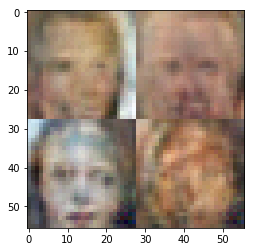

Epoch 2/30... Discriminator Loss: 0.8836... Generator Loss: 4.6705
Epoch 2/30... Discriminator Loss: 0.6059... Generator Loss: 3.9380
Epoch 2/30... Discriminator Loss: 0.7482... Generator Loss: 1.0661
Epoch 2/30... Discriminator Loss: 0.9918... Generator Loss: 0.9523
Epoch 2/30... Discriminator Loss: 0.4383... Generator Loss: 3.4625
Epoch 2/30... Discriminator Loss: 1.9978... Generator Loss: 1.8491
Epoch 2/30... Discriminator Loss: 0.6917... Generator Loss: 1.1289
Epoch 2/30... Discriminator Loss: 0.9851... Generator Loss: 7.1241
Epoch 2/30... Discriminator Loss: 0.1755... Generator Loss: 5.9722
Epoch 2/30... Discriminator Loss: 0.7526... Generator Loss: 1.3519


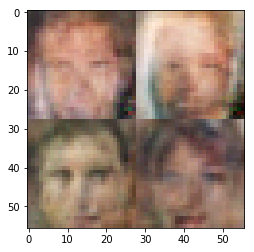

Epoch 2/30... Discriminator Loss: 0.2612... Generator Loss: 5.7859
Epoch 2/30... Discriminator Loss: 0.2185... Generator Loss: 6.8046
Epoch 2/30... Discriminator Loss: 0.3799... Generator Loss: 2.9215
Epoch 2/30... Discriminator Loss: 0.2474... Generator Loss: 7.5689
Epoch 2/30... Discriminator Loss: 1.1007... Generator Loss: 8.7719
Epoch 2/30... Discriminator Loss: 0.4328... Generator Loss: 3.4723
Epoch 2/30... Discriminator Loss: 0.2594... Generator Loss: 5.6827
Epoch 2/30... Discriminator Loss: 0.2877... Generator Loss: 4.7146
Epoch 2/30... Discriminator Loss: 0.6672... Generator Loss: 10.4665
Epoch 2/30... Discriminator Loss: 0.7440... Generator Loss: 1.2367


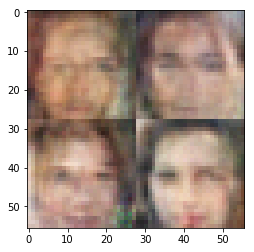

Epoch 2/30... Discriminator Loss: 2.8749... Generator Loss: 5.6197
Epoch 2/30... Discriminator Loss: 0.4262... Generator Loss: 3.6106
Epoch 2/30... Discriminator Loss: 0.3000... Generator Loss: 3.7060
Epoch 2/30... Discriminator Loss: 0.4669... Generator Loss: 3.0109
Epoch 2/30... Discriminator Loss: 0.3238... Generator Loss: 3.3145
Epoch 2/30... Discriminator Loss: 0.4176... Generator Loss: 2.0029
Epoch 2/30... Discriminator Loss: 0.3313... Generator Loss: 4.4195
Epoch 2/30... Discriminator Loss: 0.2341... Generator Loss: 3.9433
Epoch 2/30... Discriminator Loss: 1.0107... Generator Loss: 0.8985
Epoch 2/30... Discriminator Loss: 0.4095... Generator Loss: 3.9979


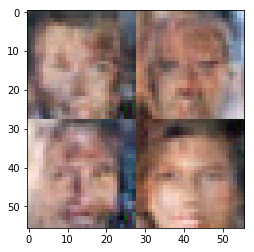

Epoch 2/30... Discriminator Loss: 0.2483... Generator Loss: 3.9516
Epoch 2/30... Discriminator Loss: 0.5603... Generator Loss: 1.6998
Epoch 2/30... Discriminator Loss: 1.6538... Generator Loss: 0.3932
Epoch 2/30... Discriminator Loss: 0.3898... Generator Loss: 2.9368
Epoch 2/30... Discriminator Loss: 1.2093... Generator Loss: 0.5619
Epoch 2/30... Discriminator Loss: 0.8795... Generator Loss: 1.3322
Epoch 2/30... Discriminator Loss: 0.4120... Generator Loss: 6.0038
Epoch 2/30... Discriminator Loss: 0.5597... Generator Loss: 1.8129
Epoch 2/30... Discriminator Loss: 0.5127... Generator Loss: 8.0475
Epoch 2/30... Discriminator Loss: 0.2468... Generator Loss: 3.3500


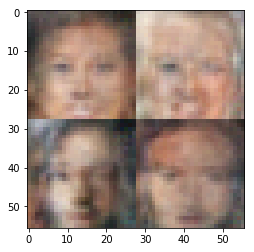

Epoch 2/30... Discriminator Loss: 0.8517... Generator Loss: 0.8425
Epoch 2/30... Discriminator Loss: 0.2506... Generator Loss: 3.8457
Epoch 2/30... Discriminator Loss: 0.8704... Generator Loss: 2.9344
Epoch 2/30... Discriminator Loss: 0.1794... Generator Loss: 10.3065
Epoch 2/30... Discriminator Loss: 0.1847... Generator Loss: 4.8703
Epoch 2/30... Discriminator Loss: 0.6553... Generator Loss: 1.6673
Epoch 2/30... Discriminator Loss: 0.5370... Generator Loss: 2.7079
Epoch 2/30... Discriminator Loss: 0.2330... Generator Loss: 4.1553
Epoch 2/30... Discriminator Loss: 0.3245... Generator Loss: 3.7652
Epoch 2/30... Discriminator Loss: 0.2900... Generator Loss: 3.6982


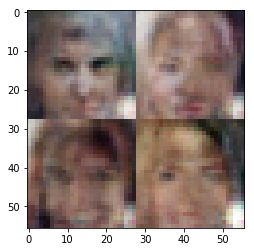

Epoch 2/30... Discriminator Loss: 2.9956... Generator Loss: 0.2102
Epoch 2/30... Discriminator Loss: 0.2266... Generator Loss: 6.6445
Epoch 2/30... Discriminator Loss: 0.6597... Generator Loss: 1.6588
Epoch 2/30... Discriminator Loss: 0.4267... Generator Loss: 5.7360
Epoch 2/30... Discriminator Loss: 0.3648... Generator Loss: 4.5303
Epoch 2/30... Discriminator Loss: 0.3426... Generator Loss: 4.3607
Epoch 2/30... Discriminator Loss: 0.2104... Generator Loss: 4.3828
Epoch 2/30... Discriminator Loss: 0.6905... Generator Loss: 2.0082
Epoch 2/30... Discriminator Loss: 0.5172... Generator Loss: 1.9775
Epoch 2/30... Discriminator Loss: 0.3482... Generator Loss: 2.1613


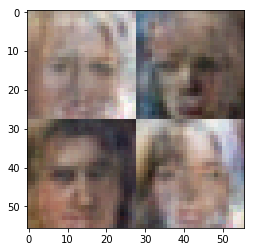

Epoch 2/30... Discriminator Loss: 0.3426... Generator Loss: 3.2225
Epoch 2/30... Discriminator Loss: 0.9693... Generator Loss: 7.1481
Epoch 2/30... Discriminator Loss: 0.4919... Generator Loss: 3.0437
Epoch 2/30... Discriminator Loss: 0.2207... Generator Loss: 3.3851
Epoch 2/30... Discriminator Loss: 0.7751... Generator Loss: 2.1948
Epoch 2/30... Discriminator Loss: 1.4154... Generator Loss: 0.5704
Epoch 2/30... Discriminator Loss: 1.4337... Generator Loss: 0.6048
Epoch 2/30... Discriminator Loss: 0.3543... Generator Loss: 10.0231
Epoch 2/30... Discriminator Loss: 0.5125... Generator Loss: 8.9169
Epoch 2/30... Discriminator Loss: 0.2185... Generator Loss: 6.6228


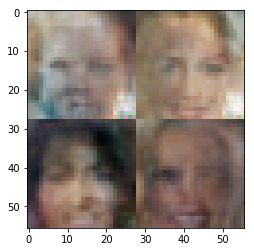

Epoch 2/30... Discriminator Loss: 0.2319... Generator Loss: 7.1568
Epoch 2/30... Discriminator Loss: 1.2106... Generator Loss: 0.7843
Epoch 2/30... Discriminator Loss: 0.1944... Generator Loss: 5.3773
Epoch 2/30... Discriminator Loss: 0.2583... Generator Loss: 6.6580
Epoch 2/30... Discriminator Loss: 0.6603... Generator Loss: 1.7940
Epoch 2/30... Discriminator Loss: 0.3141... Generator Loss: 5.2399
epoch_i 2
Epoch 3/30... Discriminator Loss: 0.7471... Generator Loss: 1.0643
Epoch 3/30... Discriminator Loss: 0.2154... Generator Loss: 4.8914
Epoch 3/30... Discriminator Loss: 0.3505... Generator Loss: 2.4952
Epoch 3/30... Discriminator Loss: 0.2962... Generator Loss: 4.0117


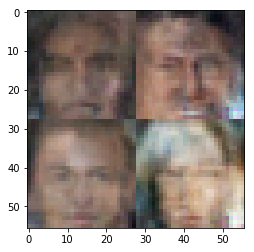

Epoch 3/30... Discriminator Loss: 0.1948... Generator Loss: 5.3305
Epoch 3/30... Discriminator Loss: 0.5289... Generator Loss: 2.8972
Epoch 3/30... Discriminator Loss: 0.4592... Generator Loss: 3.9397
Epoch 3/30... Discriminator Loss: 0.3394... Generator Loss: 4.3839
Epoch 3/30... Discriminator Loss: 0.1264... Generator Loss: 9.1071
Epoch 3/30... Discriminator Loss: 0.4138... Generator Loss: 2.7653
Epoch 3/30... Discriminator Loss: 1.2862... Generator Loss: 7.6156
Epoch 3/30... Discriminator Loss: 0.4495... Generator Loss: 2.5889
Epoch 3/30... Discriminator Loss: 0.3867... Generator Loss: 3.5825
Epoch 3/30... Discriminator Loss: 0.2635... Generator Loss: 5.6232


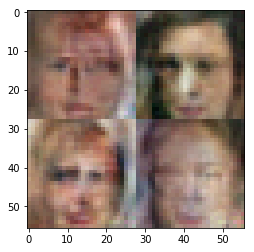

Epoch 3/30... Discriminator Loss: 0.1771... Generator Loss: 4.9848
Epoch 3/30... Discriminator Loss: 0.2747... Generator Loss: 3.8358
Epoch 3/30... Discriminator Loss: 0.5802... Generator Loss: 1.9401
Epoch 3/30... Discriminator Loss: 0.4767... Generator Loss: 15.2401
Epoch 3/30... Discriminator Loss: 0.4024... Generator Loss: 2.6382
Epoch 3/30... Discriminator Loss: 0.3857... Generator Loss: 4.3315
Epoch 3/30... Discriminator Loss: 0.1938... Generator Loss: 11.0994
Epoch 3/30... Discriminator Loss: 1.7871... Generator Loss: 2.8766
Epoch 3/30... Discriminator Loss: 0.2134... Generator Loss: 7.6462
Epoch 3/30... Discriminator Loss: 1.0565... Generator Loss: 1.5600


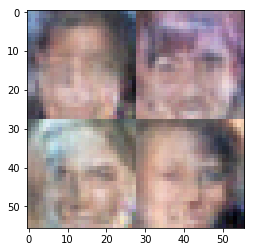

Epoch 3/30... Discriminator Loss: 0.2430... Generator Loss: 11.1276
Epoch 3/30... Discriminator Loss: 0.1209... Generator Loss: 10.9713
Epoch 3/30... Discriminator Loss: 0.2471... Generator Loss: 6.5814
Epoch 3/30... Discriminator Loss: 0.2609... Generator Loss: 4.7955
Epoch 3/30... Discriminator Loss: 0.2465... Generator Loss: 8.6790
Epoch 3/30... Discriminator Loss: 0.6045... Generator Loss: 1.5253
Epoch 3/30... Discriminator Loss: 0.6959... Generator Loss: 1.5866
Epoch 3/30... Discriminator Loss: 0.3215... Generator Loss: 6.9509
Epoch 3/30... Discriminator Loss: 0.4281... Generator Loss: 10.3909
Epoch 3/30... Discriminator Loss: 0.1755... Generator Loss: 7.0620


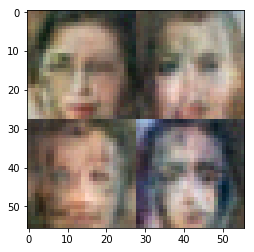

Epoch 3/30... Discriminator Loss: 0.3537... Generator Loss: 3.4436
Epoch 3/30... Discriminator Loss: 0.5874... Generator Loss: 7.8622
Epoch 3/30... Discriminator Loss: 0.1897... Generator Loss: 7.9985
Epoch 3/30... Discriminator Loss: 0.2843... Generator Loss: 7.2010
Epoch 3/30... Discriminator Loss: 0.1631... Generator Loss: 8.0775
Epoch 3/30... Discriminator Loss: 0.1818... Generator Loss: 6.2939
Epoch 3/30... Discriminator Loss: 0.2548... Generator Loss: 10.7703
Epoch 3/30... Discriminator Loss: 0.2149... Generator Loss: 7.6269
Epoch 3/30... Discriminator Loss: 0.4174... Generator Loss: 3.9975
Epoch 3/30... Discriminator Loss: 0.8229... Generator Loss: 4.1146


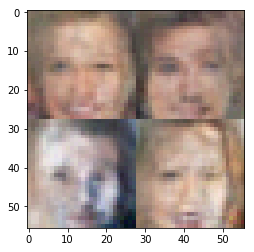

Epoch 3/30... Discriminator Loss: 0.1455... Generator Loss: 12.5171
Epoch 3/30... Discriminator Loss: 0.2005... Generator Loss: 12.2792
Epoch 3/30... Discriminator Loss: 0.3672... Generator Loss: 5.3905
Epoch 3/30... Discriminator Loss: 0.2082... Generator Loss: 5.5392
Epoch 3/30... Discriminator Loss: 1.3968... Generator Loss: 5.6064
Epoch 3/30... Discriminator Loss: 0.4560... Generator Loss: 2.0815
Epoch 3/30... Discriminator Loss: 1.2415... Generator Loss: 0.8423
Epoch 3/30... Discriminator Loss: 2.1974... Generator Loss: 0.4099
Epoch 3/30... Discriminator Loss: 1.7617... Generator Loss: 7.7902
Epoch 3/30... Discriminator Loss: 0.1627... Generator Loss: 6.1718


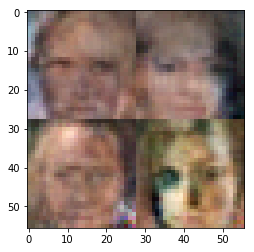

Epoch 3/30... Discriminator Loss: 0.7622... Generator Loss: 1.6463
Epoch 3/30... Discriminator Loss: 0.2170... Generator Loss: 10.6995
Epoch 3/30... Discriminator Loss: 0.2629... Generator Loss: 12.0623
Epoch 3/30... Discriminator Loss: 0.2511... Generator Loss: 5.0285
Epoch 3/30... Discriminator Loss: 0.4400... Generator Loss: 2.8513
Epoch 3/30... Discriminator Loss: 0.7821... Generator Loss: 1.2946
Epoch 3/30... Discriminator Loss: 0.4332... Generator Loss: 2.4113
Epoch 3/30... Discriminator Loss: 1.3099... Generator Loss: 0.8765
Epoch 3/30... Discriminator Loss: 0.3622... Generator Loss: 3.5287
Epoch 3/30... Discriminator Loss: 0.3252... Generator Loss: 3.1563


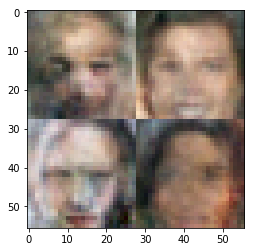

Epoch 3/30... Discriminator Loss: 0.4216... Generator Loss: 6.3660
Epoch 3/30... Discriminator Loss: 0.2679... Generator Loss: 6.2889
Epoch 3/30... Discriminator Loss: 0.2392... Generator Loss: 12.9761
Epoch 3/30... Discriminator Loss: 0.1155... Generator Loss: 10.1630
Epoch 3/30... Discriminator Loss: 0.6972... Generator Loss: 5.0222
Epoch 3/30... Discriminator Loss: 0.7213... Generator Loss: 1.2086
Epoch 3/30... Discriminator Loss: 0.8248... Generator Loss: 5.7197
Epoch 3/30... Discriminator Loss: 1.5735... Generator Loss: 7.5443
Epoch 3/30... Discriminator Loss: 0.1492... Generator Loss: 11.7909
Epoch 3/30... Discriminator Loss: 0.2063... Generator Loss: 4.8586


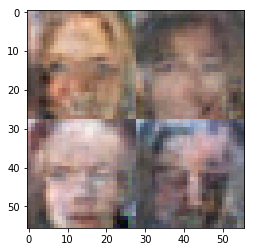

Epoch 3/30... Discriminator Loss: 0.3404... Generator Loss: 3.3288
Epoch 3/30... Discriminator Loss: 0.0830... Generator Loss: 11.3348
Epoch 3/30... Discriminator Loss: 0.3123... Generator Loss: 4.0354
Epoch 3/30... Discriminator Loss: 1.0691... Generator Loss: 1.0816
Epoch 3/30... Discriminator Loss: 1.6516... Generator Loss: 0.9965
Epoch 3/30... Discriminator Loss: 0.2935... Generator Loss: 3.2563
Epoch 3/30... Discriminator Loss: 0.1970... Generator Loss: 10.0554
Epoch 3/30... Discriminator Loss: 0.2775... Generator Loss: 6.0973
Epoch 3/30... Discriminator Loss: 0.6817... Generator Loss: 1.4458
Epoch 3/30... Discriminator Loss: 3.9172... Generator Loss: 4.1896


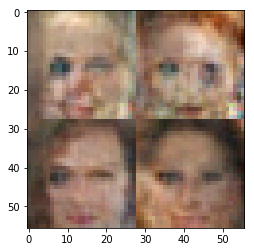

Epoch 3/30... Discriminator Loss: 0.3385... Generator Loss: 4.0503
Epoch 3/30... Discriminator Loss: 0.2640... Generator Loss: 3.9362
Epoch 3/30... Discriminator Loss: 0.4594... Generator Loss: 2.6973
Epoch 3/30... Discriminator Loss: 0.2103... Generator Loss: 4.8315
Epoch 3/30... Discriminator Loss: 0.6937... Generator Loss: 1.5141
Epoch 3/30... Discriminator Loss: 0.6529... Generator Loss: 3.3066
Epoch 3/30... Discriminator Loss: 0.2485... Generator Loss: 4.2863
Epoch 3/30... Discriminator Loss: 0.4580... Generator Loss: 8.1318
Epoch 3/30... Discriminator Loss: 0.2414... Generator Loss: 3.2803
Epoch 3/30... Discriminator Loss: 0.2249... Generator Loss: 11.5120


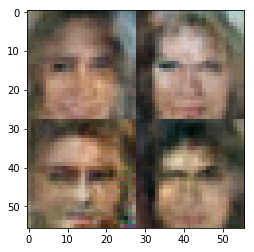

Epoch 3/30... Discriminator Loss: 0.1875... Generator Loss: 3.9140
Epoch 3/30... Discriminator Loss: 1.4088... Generator Loss: 0.6751
Epoch 3/30... Discriminator Loss: 1.2402... Generator Loss: 0.7161
Epoch 3/30... Discriminator Loss: 0.5708... Generator Loss: 1.7073
Epoch 3/30... Discriminator Loss: 0.2982... Generator Loss: 2.6372
Epoch 3/30... Discriminator Loss: 0.1097... Generator Loss: 4.6402
Epoch 3/30... Discriminator Loss: 1.0342... Generator Loss: 1.1988
Epoch 3/30... Discriminator Loss: 1.3081... Generator Loss: 0.5615
Epoch 3/30... Discriminator Loss: 0.3159... Generator Loss: 7.9361
Epoch 3/30... Discriminator Loss: 0.3290... Generator Loss: 8.4310


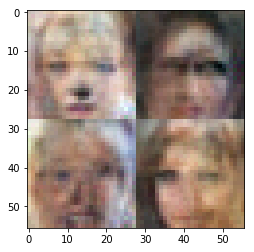

Epoch 3/30... Discriminator Loss: 0.1433... Generator Loss: 8.0531
Epoch 3/30... Discriminator Loss: 0.9806... Generator Loss: 1.6374
Epoch 3/30... Discriminator Loss: 0.4516... Generator Loss: 3.0560
Epoch 3/30... Discriminator Loss: 0.1034... Generator Loss: 9.5965
Epoch 3/30... Discriminator Loss: 0.1782... Generator Loss: 4.6213
Epoch 3/30... Discriminator Loss: 2.9493... Generator Loss: 6.5546
Epoch 3/30... Discriminator Loss: 0.9028... Generator Loss: 11.4829
Epoch 3/30... Discriminator Loss: 0.2416... Generator Loss: 10.8116
Epoch 3/30... Discriminator Loss: 0.4837... Generator Loss: 8.1740
Epoch 3/30... Discriminator Loss: 0.2772... Generator Loss: 2.5139


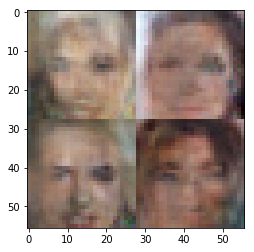

Epoch 3/30... Discriminator Loss: 1.1281... Generator Loss: 1.4350
Epoch 3/30... Discriminator Loss: 0.8220... Generator Loss: 2.2457
Epoch 3/30... Discriminator Loss: 0.5828... Generator Loss: 2.8926
Epoch 3/30... Discriminator Loss: 0.5087... Generator Loss: 1.7819
Epoch 3/30... Discriminator Loss: 0.2703... Generator Loss: 4.1724
Epoch 3/30... Discriminator Loss: 0.2848... Generator Loss: 6.3093
Epoch 3/30... Discriminator Loss: 0.2750... Generator Loss: 7.0465
Epoch 3/30... Discriminator Loss: 0.4241... Generator Loss: 8.3859
Epoch 3/30... Discriminator Loss: 0.3065... Generator Loss: 12.3775
Epoch 3/30... Discriminator Loss: 0.7075... Generator Loss: 3.4034


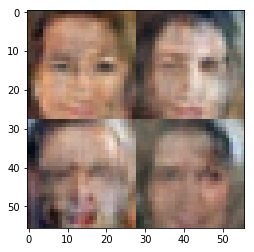

Epoch 3/30... Discriminator Loss: 0.1339... Generator Loss: 6.8803
Epoch 3/30... Discriminator Loss: 0.0791... Generator Loss: 8.0371
Epoch 3/30... Discriminator Loss: 0.1791... Generator Loss: 4.4129
Epoch 3/30... Discriminator Loss: 0.1155... Generator Loss: 6.5393
Epoch 3/30... Discriminator Loss: 1.0425... Generator Loss: 1.2233
Epoch 3/30... Discriminator Loss: 0.2067... Generator Loss: 5.9019
Epoch 3/30... Discriminator Loss: 0.2056... Generator Loss: 9.0827
Epoch 3/30... Discriminator Loss: 0.1778... Generator Loss: 6.9257
Epoch 3/30... Discriminator Loss: 0.2877... Generator Loss: 5.6300
Epoch 3/30... Discriminator Loss: 0.3340... Generator Loss: 4.0256


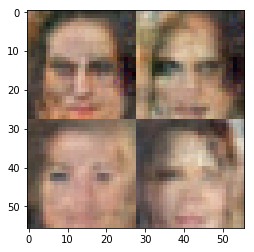

Epoch 3/30... Discriminator Loss: 2.3894... Generator Loss: 0.4237
Epoch 3/30... Discriminator Loss: 0.7223... Generator Loss: 1.1082
Epoch 3/30... Discriminator Loss: 0.6704... Generator Loss: 1.4066
Epoch 3/30... Discriminator Loss: 0.2080... Generator Loss: 5.7666
Epoch 3/30... Discriminator Loss: 0.8883... Generator Loss: 1.9036
Epoch 3/30... Discriminator Loss: 1.2752... Generator Loss: 0.5569
Epoch 3/30... Discriminator Loss: 0.2685... Generator Loss: 3.4121
Epoch 3/30... Discriminator Loss: 0.1716... Generator Loss: 5.6331
Epoch 3/30... Discriminator Loss: 0.2773... Generator Loss: 4.9250
Epoch 3/30... Discriminator Loss: 1.6140... Generator Loss: 3.3418


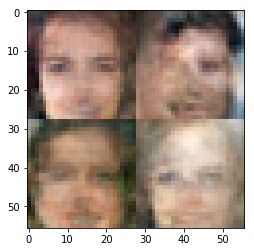

Epoch 3/30... Discriminator Loss: 0.1844... Generator Loss: 7.8773
Epoch 3/30... Discriminator Loss: 0.8676... Generator Loss: 5.6583
Epoch 3/30... Discriminator Loss: 1.0261... Generator Loss: 0.7540
Epoch 3/30... Discriminator Loss: 0.2961... Generator Loss: 3.4420
Epoch 3/30... Discriminator Loss: 0.4652... Generator Loss: 1.8749
Epoch 3/30... Discriminator Loss: 0.1623... Generator Loss: 5.2521
Epoch 3/30... Discriminator Loss: 0.4155... Generator Loss: 3.3088
Epoch 3/30... Discriminator Loss: 0.2537... Generator Loss: 9.8278
Epoch 3/30... Discriminator Loss: 0.3372... Generator Loss: 8.7211
Epoch 3/30... Discriminator Loss: 1.8471... Generator Loss: 0.5056


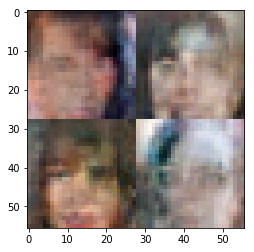

Epoch 3/30... Discriminator Loss: 0.9108... Generator Loss: 1.3059
Epoch 3/30... Discriminator Loss: 0.2031... Generator Loss: 6.2622
Epoch 3/30... Discriminator Loss: 0.4694... Generator Loss: 1.9618
Epoch 3/30... Discriminator Loss: 0.9653... Generator Loss: 0.8885
epoch_i 3
Epoch 4/30... Discriminator Loss: 1.2637... Generator Loss: 0.6523
Epoch 4/30... Discriminator Loss: 0.1973... Generator Loss: 5.2208
Epoch 4/30... Discriminator Loss: 1.8437... Generator Loss: 9.0674
Epoch 4/30... Discriminator Loss: 0.3009... Generator Loss: 4.6162
Epoch 4/30... Discriminator Loss: 0.3995... Generator Loss: 4.4162
Epoch 4/30... Discriminator Loss: 0.9302... Generator Loss: 0.9992


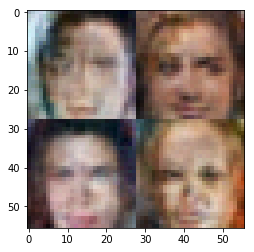

Epoch 4/30... Discriminator Loss: 0.5179... Generator Loss: 8.9154
Epoch 4/30... Discriminator Loss: 0.2833... Generator Loss: 8.9365
Epoch 4/30... Discriminator Loss: 0.3482... Generator Loss: 3.7564
Epoch 4/30... Discriminator Loss: 0.1956... Generator Loss: 4.7157
Epoch 4/30... Discriminator Loss: 0.2361... Generator Loss: 5.4182
Epoch 4/30... Discriminator Loss: 0.4907... Generator Loss: 1.7753
Epoch 4/30... Discriminator Loss: 0.5623... Generator Loss: 2.3233
Epoch 4/30... Discriminator Loss: 1.3997... Generator Loss: 0.5190
Epoch 4/30... Discriminator Loss: 1.1706... Generator Loss: 1.3061
Epoch 4/30... Discriminator Loss: 0.3743... Generator Loss: 4.9950


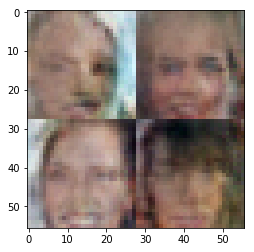

Epoch 4/30... Discriminator Loss: 0.8590... Generator Loss: 4.0835
Epoch 4/30... Discriminator Loss: 0.5456... Generator Loss: 3.0507
Epoch 4/30... Discriminator Loss: 0.2639... Generator Loss: 3.8253
Epoch 4/30... Discriminator Loss: 0.6949... Generator Loss: 1.4254
Epoch 4/30... Discriminator Loss: 0.7770... Generator Loss: 1.7003
Epoch 4/30... Discriminator Loss: 0.6403... Generator Loss: 4.7066
Epoch 4/30... Discriminator Loss: 0.4020... Generator Loss: 3.3132
Epoch 4/30... Discriminator Loss: 0.2593... Generator Loss: 2.5331
Epoch 4/30... Discriminator Loss: 4.0649... Generator Loss: 3.4345
Epoch 4/30... Discriminator Loss: 0.4358... Generator Loss: 2.5290


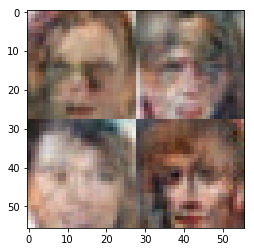

Epoch 4/30... Discriminator Loss: 0.4589... Generator Loss: 3.9939
Epoch 4/30... Discriminator Loss: 0.2151... Generator Loss: 5.6780
Epoch 4/30... Discriminator Loss: 1.5859... Generator Loss: 0.6441
Epoch 4/30... Discriminator Loss: 2.8430... Generator Loss: 2.1628
Epoch 4/30... Discriminator Loss: 1.7318... Generator Loss: 0.3558
Epoch 4/30... Discriminator Loss: 0.3924... Generator Loss: 3.2994
Epoch 4/30... Discriminator Loss: 0.2288... Generator Loss: 5.0691
Epoch 4/30... Discriminator Loss: 0.3753... Generator Loss: 2.9637
Epoch 4/30... Discriminator Loss: 1.0490... Generator Loss: 0.9783
Epoch 4/30... Discriminator Loss: 0.5135... Generator Loss: 2.6934


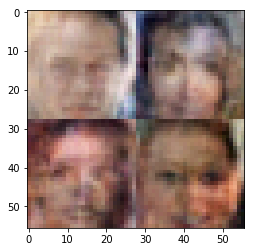

Epoch 4/30... Discriminator Loss: 0.2219... Generator Loss: 10.3148
Epoch 4/30... Discriminator Loss: 0.2509... Generator Loss: 4.3154
Epoch 4/30... Discriminator Loss: 0.4813... Generator Loss: 2.3077
Epoch 4/30... Discriminator Loss: 0.4290... Generator Loss: 1.9109
Epoch 4/30... Discriminator Loss: 0.3171... Generator Loss: 3.9419
Epoch 4/30... Discriminator Loss: 0.1973... Generator Loss: 3.5944
Epoch 4/30... Discriminator Loss: 1.2116... Generator Loss: 0.8442
Epoch 4/30... Discriminator Loss: 2.5362... Generator Loss: 2.7660
Epoch 4/30... Discriminator Loss: 0.6442... Generator Loss: 5.4985
Epoch 4/30... Discriminator Loss: 0.3110... Generator Loss: 3.8227


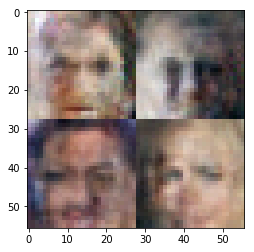

Epoch 4/30... Discriminator Loss: 0.2896... Generator Loss: 3.3019
Epoch 4/30... Discriminator Loss: 0.8311... Generator Loss: 1.5942
Epoch 4/30... Discriminator Loss: 1.6470... Generator Loss: 0.6698
Epoch 4/30... Discriminator Loss: 0.7069... Generator Loss: 1.1133
Epoch 4/30... Discriminator Loss: 0.6713... Generator Loss: 1.2537
Epoch 4/30... Discriminator Loss: 0.6523... Generator Loss: 4.5223
Epoch 4/30... Discriminator Loss: 0.2739... Generator Loss: 3.2416
Epoch 4/30... Discriminator Loss: 0.4838... Generator Loss: 1.6977
Epoch 4/30... Discriminator Loss: 0.2666... Generator Loss: 2.6317
Epoch 4/30... Discriminator Loss: 0.6110... Generator Loss: 3.0777


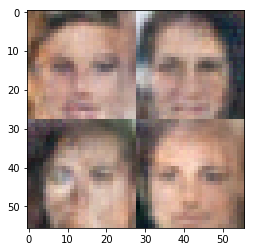

Epoch 4/30... Discriminator Loss: 0.1554... Generator Loss: 4.9735
Epoch 4/30... Discriminator Loss: 0.5318... Generator Loss: 1.9636
Epoch 4/30... Discriminator Loss: 0.5142... Generator Loss: 1.4318
Epoch 4/30... Discriminator Loss: 0.6316... Generator Loss: 3.0004
Epoch 4/30... Discriminator Loss: 0.2884... Generator Loss: 4.3642
Epoch 4/30... Discriminator Loss: 0.8725... Generator Loss: 3.2855
Epoch 4/30... Discriminator Loss: 0.5853... Generator Loss: 5.4040
Epoch 4/30... Discriminator Loss: 0.2118... Generator Loss: 5.6462
Epoch 4/30... Discriminator Loss: 0.2347... Generator Loss: 3.1126
Epoch 4/30... Discriminator Loss: 0.5487... Generator Loss: 1.7358


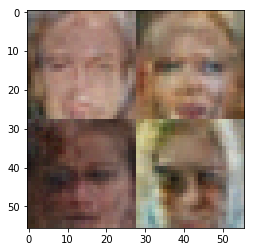

Epoch 4/30... Discriminator Loss: 0.5669... Generator Loss: 4.0666
Epoch 4/30... Discriminator Loss: 0.7272... Generator Loss: 1.3902
Epoch 4/30... Discriminator Loss: 0.2081... Generator Loss: 3.9318
Epoch 4/30... Discriminator Loss: 0.2584... Generator Loss: 3.2659
Epoch 4/30... Discriminator Loss: 0.7589... Generator Loss: 2.2991
Epoch 4/30... Discriminator Loss: 0.2284... Generator Loss: 4.6193
Epoch 4/30... Discriminator Loss: 1.1534... Generator Loss: 1.4025
Epoch 4/30... Discriminator Loss: 0.1754... Generator Loss: 5.2510
Epoch 4/30... Discriminator Loss: 0.8106... Generator Loss: 0.9335
Epoch 4/30... Discriminator Loss: 0.6071... Generator Loss: 3.1155


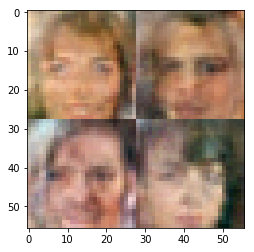

Epoch 4/30... Discriminator Loss: 0.3269... Generator Loss: 4.1660
Epoch 4/30... Discriminator Loss: 0.4964... Generator Loss: 4.7230
Epoch 4/30... Discriminator Loss: 0.3453... Generator Loss: 3.8736
Epoch 4/30... Discriminator Loss: 1.0760... Generator Loss: 2.5270
Epoch 4/30... Discriminator Loss: 0.5339... Generator Loss: 1.6926
Epoch 4/30... Discriminator Loss: 0.7895... Generator Loss: 1.4790
Epoch 4/30... Discriminator Loss: 0.4025... Generator Loss: 3.7655
Epoch 4/30... Discriminator Loss: 3.1106... Generator Loss: 1.8909
Epoch 4/30... Discriminator Loss: 1.2398... Generator Loss: 3.5551
Epoch 4/30... Discriminator Loss: 2.0189... Generator Loss: 0.3797


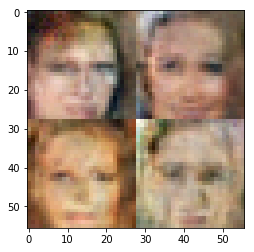

Epoch 4/30... Discriminator Loss: 0.2381... Generator Loss: 3.8628
Epoch 4/30... Discriminator Loss: 0.2987... Generator Loss: 2.8659
Epoch 4/30... Discriminator Loss: 0.3705... Generator Loss: 3.8169
Epoch 4/30... Discriminator Loss: 0.4638... Generator Loss: 1.8223
Epoch 4/30... Discriminator Loss: 0.8580... Generator Loss: 1.2947
Epoch 4/30... Discriminator Loss: 0.2738... Generator Loss: 3.8664
Epoch 4/30... Discriminator Loss: 0.7810... Generator Loss: 1.0954
Epoch 4/30... Discriminator Loss: 0.8927... Generator Loss: 0.8619
Epoch 4/30... Discriminator Loss: 0.4028... Generator Loss: 4.6022
Epoch 4/30... Discriminator Loss: 1.2490... Generator Loss: 1.3176


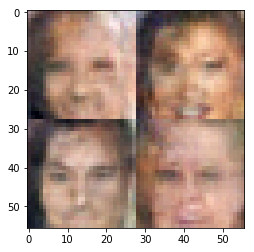

Epoch 4/30... Discriminator Loss: 0.9363... Generator Loss: 0.8687
Epoch 4/30... Discriminator Loss: 0.6869... Generator Loss: 1.7408
Epoch 4/30... Discriminator Loss: 0.4697... Generator Loss: 3.0328
Epoch 4/30... Discriminator Loss: 0.6148... Generator Loss: 1.8205
Epoch 4/30... Discriminator Loss: 0.4685... Generator Loss: 1.5220
Epoch 4/30... Discriminator Loss: 0.9427... Generator Loss: 0.7304
Epoch 4/30... Discriminator Loss: 1.1219... Generator Loss: 2.7460
Epoch 4/30... Discriminator Loss: 2.3521... Generator Loss: 0.2700
Epoch 4/30... Discriminator Loss: 1.3853... Generator Loss: 0.4394
Epoch 4/30... Discriminator Loss: 0.3965... Generator Loss: 3.4442


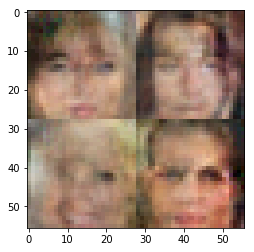

Epoch 4/30... Discriminator Loss: 0.4355... Generator Loss: 3.9887
Epoch 4/30... Discriminator Loss: 1.0410... Generator Loss: 0.7020
Epoch 4/30... Discriminator Loss: 1.7326... Generator Loss: 0.2934
Epoch 4/30... Discriminator Loss: 0.3959... Generator Loss: 2.3417
Epoch 4/30... Discriminator Loss: 0.4332... Generator Loss: 2.2761
Epoch 4/30... Discriminator Loss: 0.4049... Generator Loss: 4.9568
Epoch 4/30... Discriminator Loss: 0.9023... Generator Loss: 2.0506
Epoch 4/30... Discriminator Loss: 0.4322... Generator Loss: 4.0941
Epoch 4/30... Discriminator Loss: 1.2832... Generator Loss: 0.7216
Epoch 4/30... Discriminator Loss: 0.7782... Generator Loss: 0.9859


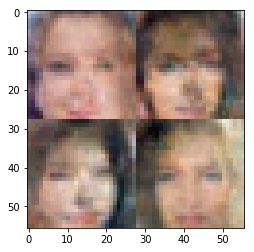

Epoch 4/30... Discriminator Loss: 0.8047... Generator Loss: 1.1318
Epoch 4/30... Discriminator Loss: 0.5997... Generator Loss: 1.3180
Epoch 4/30... Discriminator Loss: 0.3447... Generator Loss: 2.3184
Epoch 4/30... Discriminator Loss: 1.9652... Generator Loss: 0.2629
Epoch 4/30... Discriminator Loss: 0.3599... Generator Loss: 3.0519
Epoch 4/30... Discriminator Loss: 0.5765... Generator Loss: 1.7377
Epoch 4/30... Discriminator Loss: 0.9321... Generator Loss: 3.0250
Epoch 4/30... Discriminator Loss: 0.3123... Generator Loss: 3.2826
Epoch 4/30... Discriminator Loss: 1.0920... Generator Loss: 0.6486
Epoch 4/30... Discriminator Loss: 1.4211... Generator Loss: 1.9552


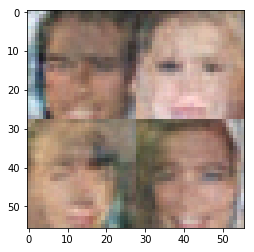

Epoch 4/30... Discriminator Loss: 1.2932... Generator Loss: 0.6300
Epoch 4/30... Discriminator Loss: 0.5319... Generator Loss: 2.2986
Epoch 4/30... Discriminator Loss: 0.2856... Generator Loss: 2.9082
Epoch 4/30... Discriminator Loss: 0.4983... Generator Loss: 2.8334
Epoch 4/30... Discriminator Loss: 0.9905... Generator Loss: 0.7675
Epoch 4/30... Discriminator Loss: 0.4669... Generator Loss: 2.5510
Epoch 4/30... Discriminator Loss: 0.4337... Generator Loss: 1.9813
Epoch 4/30... Discriminator Loss: 0.7648... Generator Loss: 1.9851
Epoch 4/30... Discriminator Loss: 0.2376... Generator Loss: 5.5286
Epoch 4/30... Discriminator Loss: 2.1049... Generator Loss: 1.6396


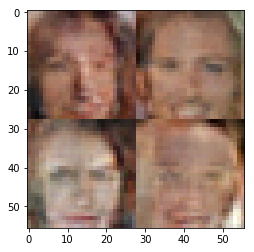

Epoch 4/30... Discriminator Loss: 0.7173... Generator Loss: 3.1701
Epoch 4/30... Discriminator Loss: 0.4322... Generator Loss: 2.1585
Epoch 4/30... Discriminator Loss: 0.6478... Generator Loss: 7.0240
Epoch 4/30... Discriminator Loss: 1.2725... Generator Loss: 1.4580
Epoch 4/30... Discriminator Loss: 0.6462... Generator Loss: 1.3985
Epoch 4/30... Discriminator Loss: 1.0747... Generator Loss: 0.9123
Epoch 4/30... Discriminator Loss: 0.5504... Generator Loss: 2.0205
Epoch 4/30... Discriminator Loss: 0.5753... Generator Loss: 1.3019
Epoch 4/30... Discriminator Loss: 0.5640... Generator Loss: 1.8161
Epoch 4/30... Discriminator Loss: 1.4389... Generator Loss: 0.4321


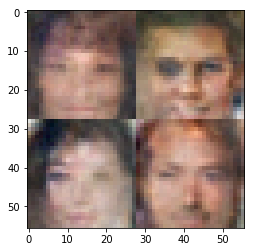

Epoch 4/30... Discriminator Loss: 1.5947... Generator Loss: 0.3482
Epoch 4/30... Discriminator Loss: 1.1315... Generator Loss: 2.9161
Epoch 4/30... Discriminator Loss: 0.9977... Generator Loss: 0.7454
Epoch 4/30... Discriminator Loss: 0.6433... Generator Loss: 2.6083
Epoch 4/30... Discriminator Loss: 0.3502... Generator Loss: 2.3961
Epoch 4/30... Discriminator Loss: 1.0413... Generator Loss: 5.1831
Epoch 4/30... Discriminator Loss: 0.8264... Generator Loss: 1.4101
Epoch 4/30... Discriminator Loss: 1.2905... Generator Loss: 1.6670
Epoch 4/30... Discriminator Loss: 1.0270... Generator Loss: 3.1591
Epoch 4/30... Discriminator Loss: 0.7256... Generator Loss: 1.5321


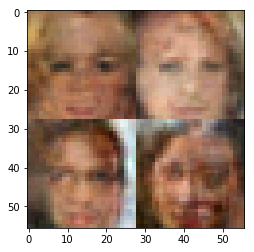

Epoch 4/30... Discriminator Loss: 0.2895... Generator Loss: 3.3700
Epoch 4/30... Discriminator Loss: 0.6969... Generator Loss: 2.3230
epoch_i 4
Epoch 5/30... Discriminator Loss: 2.0229... Generator Loss: 4.4109
Epoch 5/30... Discriminator Loss: 1.1437... Generator Loss: 2.0068
Epoch 5/30... Discriminator Loss: 0.7630... Generator Loss: 3.7840
Epoch 5/30... Discriminator Loss: 0.4433... Generator Loss: 1.7566
Epoch 5/30... Discriminator Loss: 0.8175... Generator Loss: 1.2808
Epoch 5/30... Discriminator Loss: 1.1720... Generator Loss: 0.9671
Epoch 5/30... Discriminator Loss: 0.7527... Generator Loss: 0.9307
Epoch 5/30... Discriminator Loss: 0.5144... Generator Loss: 1.8984


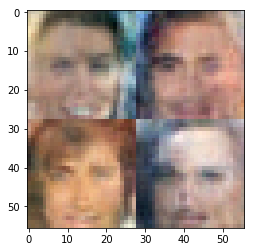

Epoch 5/30... Discriminator Loss: 0.9535... Generator Loss: 2.1220
Epoch 5/30... Discriminator Loss: 0.8715... Generator Loss: 2.5767
Epoch 5/30... Discriminator Loss: 1.2598... Generator Loss: 2.6034
Epoch 5/30... Discriminator Loss: 1.3136... Generator Loss: 0.5259
Epoch 5/30... Discriminator Loss: 0.8253... Generator Loss: 1.2702
Epoch 5/30... Discriminator Loss: 1.3313... Generator Loss: 0.6310
Epoch 5/30... Discriminator Loss: 0.5965... Generator Loss: 1.7715
Epoch 5/30... Discriminator Loss: 0.8967... Generator Loss: 1.0928
Epoch 5/30... Discriminator Loss: 0.2844... Generator Loss: 4.1281
Epoch 5/30... Discriminator Loss: 0.3488... Generator Loss: 2.8361


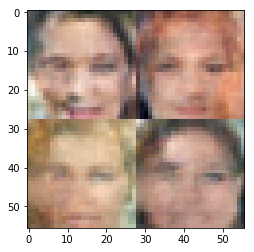

Epoch 5/30... Discriminator Loss: 0.7383... Generator Loss: 5.0318
Epoch 5/30... Discriminator Loss: 0.7508... Generator Loss: 1.6848
Epoch 5/30... Discriminator Loss: 0.9919... Generator Loss: 1.5132
Epoch 5/30... Discriminator Loss: 1.0029... Generator Loss: 1.1431
Epoch 5/30... Discriminator Loss: 0.4566... Generator Loss: 2.5828
Epoch 5/30... Discriminator Loss: 0.7175... Generator Loss: 1.6882
Epoch 5/30... Discriminator Loss: 0.3991... Generator Loss: 1.8373
Epoch 5/30... Discriminator Loss: 0.2686... Generator Loss: 2.7970
Epoch 5/30... Discriminator Loss: 0.7267... Generator Loss: 1.7139
Epoch 5/30... Discriminator Loss: 1.4517... Generator Loss: 5.1516


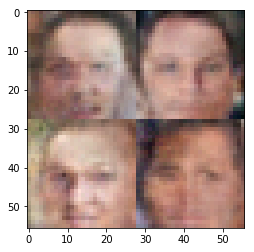

Epoch 5/30... Discriminator Loss: 1.6372... Generator Loss: 2.4957
Epoch 5/30... Discriminator Loss: 0.7211... Generator Loss: 1.6541
Epoch 5/30... Discriminator Loss: 0.6918... Generator Loss: 1.2251
Epoch 5/30... Discriminator Loss: 1.0286... Generator Loss: 1.8360
Epoch 5/30... Discriminator Loss: 1.0505... Generator Loss: 1.8435
Epoch 5/30... Discriminator Loss: 0.9297... Generator Loss: 0.8105
Epoch 5/30... Discriminator Loss: 1.4494... Generator Loss: 0.6780
Epoch 5/30... Discriminator Loss: 0.7381... Generator Loss: 1.4127
Epoch 5/30... Discriminator Loss: 0.7083... Generator Loss: 1.1806
Epoch 5/30... Discriminator Loss: 0.4641... Generator Loss: 1.9603


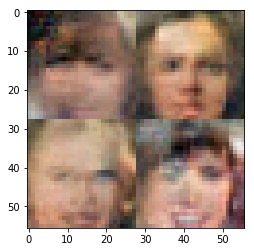

Epoch 5/30... Discriminator Loss: 0.3424... Generator Loss: 2.4589
Epoch 5/30... Discriminator Loss: 0.9127... Generator Loss: 1.9984
Epoch 5/30... Discriminator Loss: 0.5839... Generator Loss: 3.1485
Epoch 5/30... Discriminator Loss: 1.3791... Generator Loss: 0.6252
Epoch 5/30... Discriminator Loss: 0.3613... Generator Loss: 4.4885
Epoch 5/30... Discriminator Loss: 0.4010... Generator Loss: 2.4341
Epoch 5/30... Discriminator Loss: 0.8431... Generator Loss: 1.6127
Epoch 5/30... Discriminator Loss: 0.4273... Generator Loss: 1.9408
Epoch 5/30... Discriminator Loss: 1.6486... Generator Loss: 0.5798
Epoch 5/30... Discriminator Loss: 0.8441... Generator Loss: 2.7168


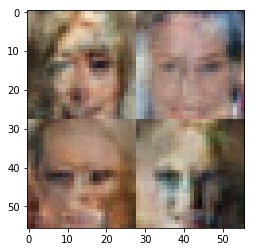

Epoch 5/30... Discriminator Loss: 0.4869... Generator Loss: 2.4520
Epoch 5/30... Discriminator Loss: 1.2227... Generator Loss: 0.7532
Epoch 5/30... Discriminator Loss: 0.7294... Generator Loss: 1.4646
Epoch 5/30... Discriminator Loss: 0.4469... Generator Loss: 2.4289
Epoch 5/30... Discriminator Loss: 0.4503... Generator Loss: 1.7469
Epoch 5/30... Discriminator Loss: 0.4365... Generator Loss: 2.1385
Epoch 5/30... Discriminator Loss: 0.9073... Generator Loss: 3.4541
Epoch 5/30... Discriminator Loss: 0.6273... Generator Loss: 1.4742
Epoch 5/30... Discriminator Loss: 0.3359... Generator Loss: 3.1309
Epoch 5/30... Discriminator Loss: 0.5595... Generator Loss: 3.2848


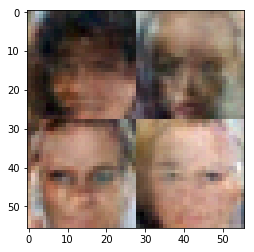

Epoch 5/30... Discriminator Loss: 0.1755... Generator Loss: 3.4552
Epoch 5/30... Discriminator Loss: 0.6177... Generator Loss: 1.8390
Epoch 5/30... Discriminator Loss: 0.4564... Generator Loss: 1.9331
Epoch 5/30... Discriminator Loss: 0.5980... Generator Loss: 3.6889
Epoch 5/30... Discriminator Loss: 1.1809... Generator Loss: 3.9178
Epoch 5/30... Discriminator Loss: 1.7003... Generator Loss: 1.1697
Epoch 5/30... Discriminator Loss: 1.1373... Generator Loss: 0.9257
Epoch 5/30... Discriminator Loss: 0.8055... Generator Loss: 1.2043
Epoch 5/30... Discriminator Loss: 0.5951... Generator Loss: 1.5410
Epoch 5/30... Discriminator Loss: 0.5129... Generator Loss: 1.8345


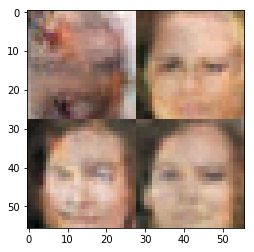

Epoch 5/30... Discriminator Loss: 1.8419... Generator Loss: 0.2939
Epoch 5/30... Discriminator Loss: 0.6676... Generator Loss: 1.5758
Epoch 5/30... Discriminator Loss: 1.2327... Generator Loss: 1.2206
Epoch 5/30... Discriminator Loss: 1.1095... Generator Loss: 1.4475
Epoch 5/30... Discriminator Loss: 1.5383... Generator Loss: 4.0898
Epoch 5/30... Discriminator Loss: 1.0788... Generator Loss: 1.0707
Epoch 5/30... Discriminator Loss: 1.4033... Generator Loss: 0.7646
Epoch 5/30... Discriminator Loss: 0.5436... Generator Loss: 2.0018
Epoch 5/30... Discriminator Loss: 1.9423... Generator Loss: 2.1241
Epoch 5/30... Discriminator Loss: 0.7404... Generator Loss: 2.2280


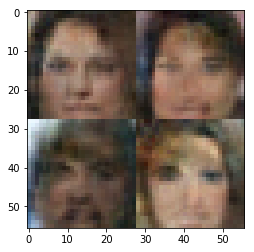

Epoch 5/30... Discriminator Loss: 1.6404... Generator Loss: 0.4528
Epoch 5/30... Discriminator Loss: 0.6622... Generator Loss: 1.2569
Epoch 5/30... Discriminator Loss: 0.6784... Generator Loss: 1.2618
Epoch 5/30... Discriminator Loss: 0.9562... Generator Loss: 1.2200
Epoch 5/30... Discriminator Loss: 0.7682... Generator Loss: 1.7172
Epoch 5/30... Discriminator Loss: 1.3142... Generator Loss: 2.2451
Epoch 5/30... Discriminator Loss: 1.2060... Generator Loss: 0.6618
Epoch 5/30... Discriminator Loss: 1.0344... Generator Loss: 1.5128
Epoch 5/30... Discriminator Loss: 1.0334... Generator Loss: 0.9119
Epoch 5/30... Discriminator Loss: 0.6549... Generator Loss: 1.6157


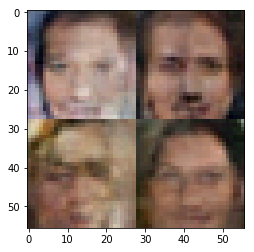

Epoch 5/30... Discriminator Loss: 0.6771... Generator Loss: 1.2781
Epoch 5/30... Discriminator Loss: 0.7903... Generator Loss: 0.9780
Epoch 5/30... Discriminator Loss: 0.8048... Generator Loss: 1.3452
Epoch 5/30... Discriminator Loss: 0.9333... Generator Loss: 0.7416
Epoch 5/30... Discriminator Loss: 0.3677... Generator Loss: 2.6586
Epoch 5/30... Discriminator Loss: 1.0904... Generator Loss: 0.8474
Epoch 5/30... Discriminator Loss: 0.3198... Generator Loss: 2.4407
Epoch 5/30... Discriminator Loss: 1.4757... Generator Loss: 0.4550
Epoch 5/30... Discriminator Loss: 3.7682... Generator Loss: 2.3142
Epoch 5/30... Discriminator Loss: 1.6028... Generator Loss: 0.3861


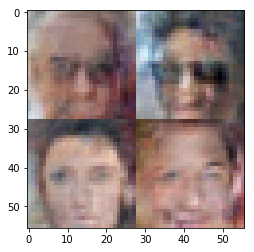

Epoch 5/30... Discriminator Loss: 0.9809... Generator Loss: 1.0553
Epoch 5/30... Discriminator Loss: 1.3542... Generator Loss: 0.5592
Epoch 5/30... Discriminator Loss: 1.0116... Generator Loss: 1.0477
Epoch 5/30... Discriminator Loss: 1.3959... Generator Loss: 0.5880
Epoch 5/30... Discriminator Loss: 1.2264... Generator Loss: 0.8567
Epoch 5/30... Discriminator Loss: 1.2461... Generator Loss: 0.7463
Epoch 5/30... Discriminator Loss: 1.3455... Generator Loss: 1.0723
Epoch 5/30... Discriminator Loss: 1.0150... Generator Loss: 0.8931
Epoch 5/30... Discriminator Loss: 1.0904... Generator Loss: 0.8180
Epoch 5/30... Discriminator Loss: 0.9598... Generator Loss: 1.1795


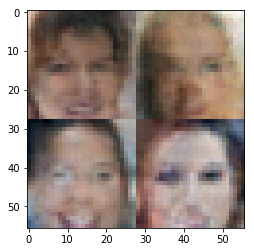

Epoch 5/30... Discriminator Loss: 1.0370... Generator Loss: 0.9033
Epoch 5/30... Discriminator Loss: 1.1494... Generator Loss: 0.6373
Epoch 5/30... Discriminator Loss: 1.2772... Generator Loss: 0.7863
Epoch 5/30... Discriminator Loss: 1.0406... Generator Loss: 0.7715
Epoch 5/30... Discriminator Loss: 1.1830... Generator Loss: 0.8910
Epoch 5/30... Discriminator Loss: 1.0430... Generator Loss: 0.8331
Epoch 5/30... Discriminator Loss: 1.1276... Generator Loss: 0.6870
Epoch 5/30... Discriminator Loss: 1.2228... Generator Loss: 0.9057
Epoch 5/30... Discriminator Loss: 1.1191... Generator Loss: 0.5606
Epoch 5/30... Discriminator Loss: 1.0006... Generator Loss: 1.1088


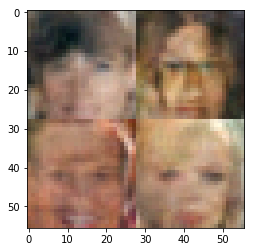

Epoch 5/30... Discriminator Loss: 0.8614... Generator Loss: 0.9862
Epoch 5/30... Discriminator Loss: 1.0454... Generator Loss: 1.1096
Epoch 5/30... Discriminator Loss: 1.2715... Generator Loss: 0.6175
Epoch 5/30... Discriminator Loss: 0.8091... Generator Loss: 1.4798
Epoch 5/30... Discriminator Loss: 1.1660... Generator Loss: 0.6294
Epoch 5/30... Discriminator Loss: 0.8866... Generator Loss: 1.2427
Epoch 5/30... Discriminator Loss: 1.0387... Generator Loss: 1.5603
Epoch 5/30... Discriminator Loss: 0.8561... Generator Loss: 1.2912
Epoch 5/30... Discriminator Loss: 1.0193... Generator Loss: 0.9707
Epoch 5/30... Discriminator Loss: 0.9822... Generator Loss: 0.8725


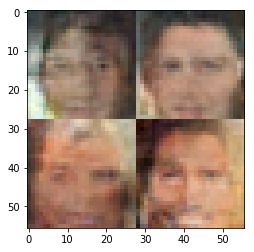

Epoch 5/30... Discriminator Loss: 1.0370... Generator Loss: 0.9670
Epoch 5/30... Discriminator Loss: 2.0279... Generator Loss: 2.3961
Epoch 5/30... Discriminator Loss: 1.0888... Generator Loss: 1.0499
Epoch 5/30... Discriminator Loss: 0.9403... Generator Loss: 0.9369
Epoch 5/30... Discriminator Loss: 0.8595... Generator Loss: 0.8722
Epoch 5/30... Discriminator Loss: 1.3094... Generator Loss: 1.9107
Epoch 5/30... Discriminator Loss: 1.1093... Generator Loss: 1.0468
Epoch 5/30... Discriminator Loss: 0.9835... Generator Loss: 0.8431
Epoch 5/30... Discriminator Loss: 1.1775... Generator Loss: 0.9563
Epoch 5/30... Discriminator Loss: 0.8434... Generator Loss: 1.3566


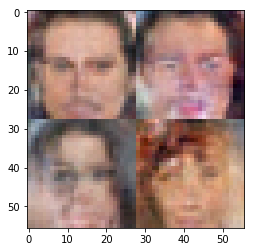

Epoch 5/30... Discriminator Loss: 1.0825... Generator Loss: 1.1989
Epoch 5/30... Discriminator Loss: 1.2346... Generator Loss: 0.9656
Epoch 5/30... Discriminator Loss: 1.0291... Generator Loss: 1.1563
Epoch 5/30... Discriminator Loss: 0.8518... Generator Loss: 1.4723
Epoch 5/30... Discriminator Loss: 2.0402... Generator Loss: 1.6914
Epoch 5/30... Discriminator Loss: 1.0959... Generator Loss: 0.9350
Epoch 5/30... Discriminator Loss: 0.8845... Generator Loss: 1.0592
Epoch 5/30... Discriminator Loss: 0.8639... Generator Loss: 1.0000
Epoch 5/30... Discriminator Loss: 0.9022... Generator Loss: 1.1970
Epoch 5/30... Discriminator Loss: 1.1016... Generator Loss: 0.8929


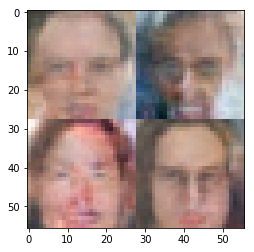

Epoch 5/30... Discriminator Loss: 0.9600... Generator Loss: 1.4574
Epoch 5/30... Discriminator Loss: 0.7477... Generator Loss: 1.6840
Epoch 5/30... Discriminator Loss: 1.1760... Generator Loss: 0.9136
Epoch 5/30... Discriminator Loss: 0.7703... Generator Loss: 1.1071
Epoch 5/30... Discriminator Loss: 1.5487... Generator Loss: 1.9783
Epoch 5/30... Discriminator Loss: 1.3643... Generator Loss: 2.6865
Epoch 5/30... Discriminator Loss: 1.3364... Generator Loss: 0.6424
Epoch 5/30... Discriminator Loss: 1.2122... Generator Loss: 0.8137
Epoch 5/30... Discriminator Loss: 0.9216... Generator Loss: 1.4409
Epoch 5/30... Discriminator Loss: 1.1113... Generator Loss: 1.1414


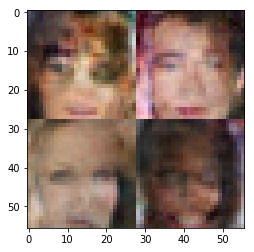

Epoch 5/30... Discriminator Loss: 1.1968... Generator Loss: 1.0154
epoch_i 5
Epoch 6/30... Discriminator Loss: 0.9883... Generator Loss: 0.8845
Epoch 6/30... Discriminator Loss: 0.9075... Generator Loss: 1.1757
Epoch 6/30... Discriminator Loss: 1.0144... Generator Loss: 1.1125
Epoch 6/30... Discriminator Loss: 1.0988... Generator Loss: 0.6743
Epoch 6/30... Discriminator Loss: 1.1495... Generator Loss: 0.8228
Epoch 6/30... Discriminator Loss: 0.7729... Generator Loss: 1.1463
Epoch 6/30... Discriminator Loss: 0.8640... Generator Loss: 1.3023
Epoch 6/30... Discriminator Loss: 0.9126... Generator Loss: 0.9287
Epoch 6/30... Discriminator Loss: 0.9327... Generator Loss: 0.8823


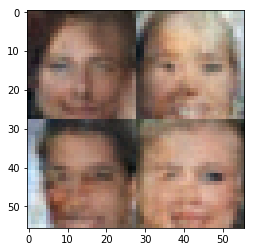

Epoch 6/30... Discriminator Loss: 0.8720... Generator Loss: 2.2427
Epoch 6/30... Discriminator Loss: 1.3927... Generator Loss: 0.7003
Epoch 6/30... Discriminator Loss: 1.0825... Generator Loss: 1.2835
Epoch 6/30... Discriminator Loss: 0.9159... Generator Loss: 0.8548
Epoch 6/30... Discriminator Loss: 0.9697... Generator Loss: 1.3196
Epoch 6/30... Discriminator Loss: 1.2102... Generator Loss: 0.7880
Epoch 6/30... Discriminator Loss: 0.7951... Generator Loss: 1.1667
Epoch 6/30... Discriminator Loss: 1.2896... Generator Loss: 2.5165
Epoch 6/30... Discriminator Loss: 1.1040... Generator Loss: 1.0342
Epoch 6/30... Discriminator Loss: 0.9248... Generator Loss: 1.3741


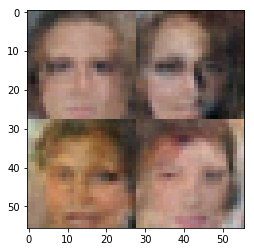

Epoch 6/30... Discriminator Loss: 1.0049... Generator Loss: 0.9521
Epoch 6/30... Discriminator Loss: 1.0643... Generator Loss: 1.1909
Epoch 6/30... Discriminator Loss: 1.0095... Generator Loss: 1.0427
Epoch 6/30... Discriminator Loss: 0.9163... Generator Loss: 1.3963
Epoch 6/30... Discriminator Loss: 1.1313... Generator Loss: 0.9489
Epoch 6/30... Discriminator Loss: 0.9772... Generator Loss: 1.0500
Epoch 6/30... Discriminator Loss: 1.1538... Generator Loss: 0.6502
Epoch 6/30... Discriminator Loss: 0.9575... Generator Loss: 1.1528
Epoch 6/30... Discriminator Loss: 0.9513... Generator Loss: 1.1583
Epoch 6/30... Discriminator Loss: 1.2234... Generator Loss: 1.4350


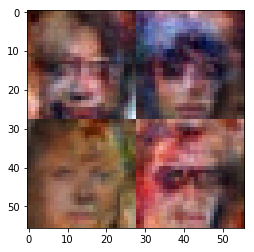

Epoch 6/30... Discriminator Loss: 0.9605... Generator Loss: 1.1575
Epoch 6/30... Discriminator Loss: 1.1939... Generator Loss: 0.6875
Epoch 6/30... Discriminator Loss: 0.9735... Generator Loss: 1.2814
Epoch 6/30... Discriminator Loss: 1.3220... Generator Loss: 1.2173
Epoch 6/30... Discriminator Loss: 0.9653... Generator Loss: 1.3569
Epoch 6/30... Discriminator Loss: 1.0218... Generator Loss: 1.1123
Epoch 6/30... Discriminator Loss: 1.1429... Generator Loss: 0.7211
Epoch 6/30... Discriminator Loss: 1.3637... Generator Loss: 0.4357
Epoch 6/30... Discriminator Loss: 1.2960... Generator Loss: 0.4224
Epoch 6/30... Discriminator Loss: 1.1581... Generator Loss: 0.8864


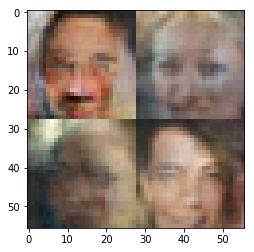

Epoch 6/30... Discriminator Loss: 1.1883... Generator Loss: 0.8364
Epoch 6/30... Discriminator Loss: 1.0288... Generator Loss: 0.9033
Epoch 6/30... Discriminator Loss: 1.1106... Generator Loss: 0.8061
Epoch 6/30... Discriminator Loss: 1.1123... Generator Loss: 1.0019
Epoch 6/30... Discriminator Loss: 1.1635... Generator Loss: 0.9273
Epoch 6/30... Discriminator Loss: 1.0850... Generator Loss: 0.8002
Epoch 6/30... Discriminator Loss: 1.0330... Generator Loss: 0.9778
Epoch 6/30... Discriminator Loss: 0.8604... Generator Loss: 0.9207
Epoch 6/30... Discriminator Loss: 0.7697... Generator Loss: 1.1752
Epoch 6/30... Discriminator Loss: 1.0457... Generator Loss: 0.8778


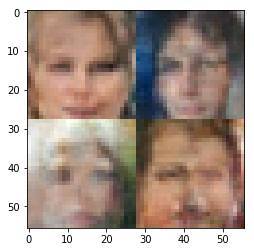

Epoch 6/30... Discriminator Loss: 1.2401... Generator Loss: 0.5730
Epoch 6/30... Discriminator Loss: 0.7579... Generator Loss: 1.4218
Epoch 6/30... Discriminator Loss: 1.0650... Generator Loss: 1.2419
Epoch 6/30... Discriminator Loss: 1.0763... Generator Loss: 0.7571
Epoch 6/30... Discriminator Loss: 0.9178... Generator Loss: 1.0165
Epoch 6/30... Discriminator Loss: 1.0422... Generator Loss: 1.5011
Epoch 6/30... Discriminator Loss: 1.0268... Generator Loss: 0.7003
Epoch 6/30... Discriminator Loss: 1.0941... Generator Loss: 1.3356
Epoch 6/30... Discriminator Loss: 1.3150... Generator Loss: 0.5794
Epoch 6/30... Discriminator Loss: 0.5937... Generator Loss: 1.9700


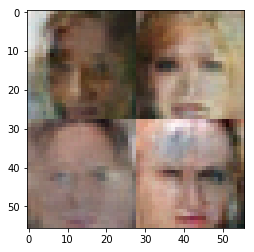

Epoch 6/30... Discriminator Loss: 0.9338... Generator Loss: 1.5376
Epoch 6/30... Discriminator Loss: 0.9603... Generator Loss: 1.0501
Epoch 6/30... Discriminator Loss: 1.0915... Generator Loss: 0.8921
Epoch 6/30... Discriminator Loss: 1.0806... Generator Loss: 0.9128
Epoch 6/30... Discriminator Loss: 1.1317... Generator Loss: 0.9965
Epoch 6/30... Discriminator Loss: 1.9654... Generator Loss: 2.9807
Epoch 6/30... Discriminator Loss: 1.2692... Generator Loss: 1.0217
Epoch 6/30... Discriminator Loss: 1.2318... Generator Loss: 0.5761
Epoch 6/30... Discriminator Loss: 0.8758... Generator Loss: 1.1548
Epoch 6/30... Discriminator Loss: 0.9807... Generator Loss: 1.7330


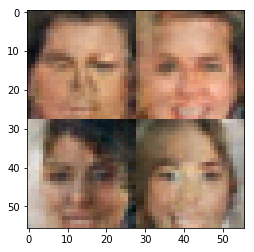

Epoch 6/30... Discriminator Loss: 1.1103... Generator Loss: 0.9068
Epoch 6/30... Discriminator Loss: 1.0005... Generator Loss: 1.0090
Epoch 6/30... Discriminator Loss: 1.1477... Generator Loss: 0.9793
Epoch 6/30... Discriminator Loss: 1.0467... Generator Loss: 0.9506
Epoch 6/30... Discriminator Loss: 0.9396... Generator Loss: 1.3988
Epoch 6/30... Discriminator Loss: 1.0181... Generator Loss: 1.1740
Epoch 6/30... Discriminator Loss: 0.9807... Generator Loss: 1.3758
Epoch 6/30... Discriminator Loss: 0.7679... Generator Loss: 1.7718
Epoch 6/30... Discriminator Loss: 0.9159... Generator Loss: 1.3634
Epoch 6/30... Discriminator Loss: 0.8351... Generator Loss: 1.3172


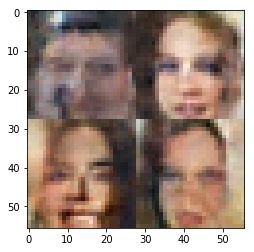

Epoch 6/30... Discriminator Loss: 0.9970... Generator Loss: 0.8070
Epoch 6/30... Discriminator Loss: 1.1131... Generator Loss: 0.7559
Epoch 6/30... Discriminator Loss: 0.9564... Generator Loss: 1.3641
Epoch 6/30... Discriminator Loss: 1.1969... Generator Loss: 0.7657
Epoch 6/30... Discriminator Loss: 0.9375... Generator Loss: 1.0206
Epoch 6/30... Discriminator Loss: 0.9816... Generator Loss: 1.5706
Epoch 6/30... Discriminator Loss: 0.9842... Generator Loss: 1.1004
Epoch 6/30... Discriminator Loss: 0.9724... Generator Loss: 0.7772
Epoch 6/30... Discriminator Loss: 5.1921... Generator Loss: 4.8295
Epoch 6/30... Discriminator Loss: 1.2021... Generator Loss: 0.8777


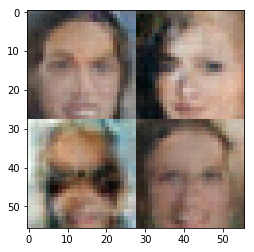

Epoch 6/30... Discriminator Loss: 1.0359... Generator Loss: 0.7960
Epoch 6/30... Discriminator Loss: 1.2248... Generator Loss: 0.6592
Epoch 6/30... Discriminator Loss: 0.7987... Generator Loss: 1.3627
Epoch 6/30... Discriminator Loss: 0.9385... Generator Loss: 1.3037
Epoch 6/30... Discriminator Loss: 1.1101... Generator Loss: 0.7681
Epoch 6/30... Discriminator Loss: 0.9382... Generator Loss: 0.8987
Epoch 6/30... Discriminator Loss: 0.9849... Generator Loss: 0.9283
Epoch 6/30... Discriminator Loss: 0.7619... Generator Loss: 1.2874
Epoch 6/30... Discriminator Loss: 0.9275... Generator Loss: 1.2389
Epoch 6/30... Discriminator Loss: 1.9696... Generator Loss: 0.7514


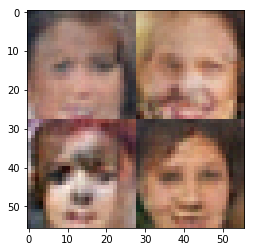

Epoch 6/30... Discriminator Loss: 1.1093... Generator Loss: 0.7315
Epoch 6/30... Discriminator Loss: 0.8772... Generator Loss: 1.1768
Epoch 6/30... Discriminator Loss: 1.0524... Generator Loss: 0.9651
Epoch 6/30... Discriminator Loss: 1.1971... Generator Loss: 0.7356
Epoch 6/30... Discriminator Loss: 1.1780... Generator Loss: 0.5711
Epoch 6/30... Discriminator Loss: 1.0166... Generator Loss: 0.8692
Epoch 6/30... Discriminator Loss: 1.0690... Generator Loss: 0.6609
Epoch 6/30... Discriminator Loss: 1.0290... Generator Loss: 0.9029
Epoch 6/30... Discriminator Loss: 1.5960... Generator Loss: 0.5190
Epoch 6/30... Discriminator Loss: 1.1692... Generator Loss: 0.8020


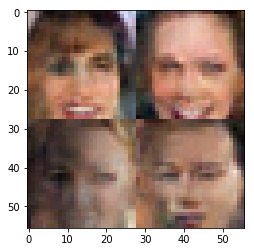

Epoch 6/30... Discriminator Loss: 0.9068... Generator Loss: 1.3688
Epoch 6/30... Discriminator Loss: 0.9263... Generator Loss: 0.7725
Epoch 6/30... Discriminator Loss: 1.0201... Generator Loss: 1.1121
Epoch 6/30... Discriminator Loss: 1.0538... Generator Loss: 0.7910
Epoch 6/30... Discriminator Loss: 1.1572... Generator Loss: 0.6116
Epoch 6/30... Discriminator Loss: 1.0601... Generator Loss: 0.7092
Epoch 6/30... Discriminator Loss: 1.3236... Generator Loss: 1.1936
Epoch 6/30... Discriminator Loss: 1.0869... Generator Loss: 0.9115
Epoch 6/30... Discriminator Loss: 1.0506... Generator Loss: 1.2143
Epoch 6/30... Discriminator Loss: 1.0995... Generator Loss: 0.9487


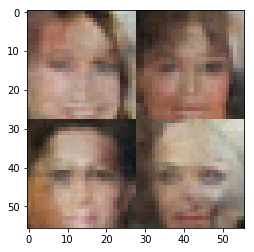

Epoch 6/30... Discriminator Loss: 0.7785... Generator Loss: 1.3553
Epoch 6/30... Discriminator Loss: 1.7670... Generator Loss: 0.3304
Epoch 6/30... Discriminator Loss: 1.1803... Generator Loss: 1.0625
Epoch 6/30... Discriminator Loss: 1.0687... Generator Loss: 0.8073
Epoch 6/30... Discriminator Loss: 1.1292... Generator Loss: 0.7350
Epoch 6/30... Discriminator Loss: 0.9409... Generator Loss: 0.9861
Epoch 6/30... Discriminator Loss: 1.1767... Generator Loss: 1.1379
Epoch 6/30... Discriminator Loss: 1.0296... Generator Loss: 1.0718
Epoch 6/30... Discriminator Loss: 1.1092... Generator Loss: 0.7817
Epoch 6/30... Discriminator Loss: 0.9952... Generator Loss: 1.2037


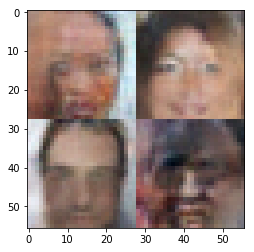

Epoch 6/30... Discriminator Loss: 2.1811... Generator Loss: 0.1732
Epoch 6/30... Discriminator Loss: 1.3402... Generator Loss: 0.8698
Epoch 6/30... Discriminator Loss: 1.2594... Generator Loss: 0.7765
Epoch 6/30... Discriminator Loss: 1.1302... Generator Loss: 0.9996
Epoch 6/30... Discriminator Loss: 1.1569... Generator Loss: 0.6923
Epoch 6/30... Discriminator Loss: 1.0032... Generator Loss: 0.9399
Epoch 6/30... Discriminator Loss: 1.1059... Generator Loss: 0.9338
Epoch 6/30... Discriminator Loss: 1.0145... Generator Loss: 0.7540
Epoch 6/30... Discriminator Loss: 1.1913... Generator Loss: 0.6599
Epoch 6/30... Discriminator Loss: 1.1204... Generator Loss: 0.7388


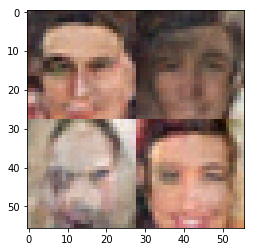

Epoch 6/30... Discriminator Loss: 0.9361... Generator Loss: 1.1245
Epoch 6/30... Discriminator Loss: 1.2443... Generator Loss: 0.6261
Epoch 6/30... Discriminator Loss: 1.0520... Generator Loss: 0.9578
Epoch 6/30... Discriminator Loss: 1.4539... Generator Loss: 1.9180
Epoch 6/30... Discriminator Loss: 1.0661... Generator Loss: 0.9105
Epoch 6/30... Discriminator Loss: 1.2349... Generator Loss: 0.7266
Epoch 6/30... Discriminator Loss: 1.2204... Generator Loss: 0.5354
Epoch 6/30... Discriminator Loss: 0.8420... Generator Loss: 1.1468
Epoch 6/30... Discriminator Loss: 1.0233... Generator Loss: 0.9572
Epoch 6/30... Discriminator Loss: 1.5545... Generator Loss: 0.3794


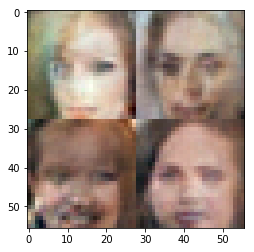

Epoch 6/30... Discriminator Loss: 0.8210... Generator Loss: 0.9375
Epoch 6/30... Discriminator Loss: 1.0128... Generator Loss: 1.1248
Epoch 6/30... Discriminator Loss: 1.1838... Generator Loss: 1.0661
Epoch 6/30... Discriminator Loss: 1.0817... Generator Loss: 0.7709
Epoch 6/30... Discriminator Loss: 0.9449... Generator Loss: 1.3865
Epoch 6/30... Discriminator Loss: 1.0518... Generator Loss: 1.1721
Epoch 6/30... Discriminator Loss: 0.8538... Generator Loss: 1.3738
Epoch 6/30... Discriminator Loss: 1.0044... Generator Loss: 1.0908
Epoch 6/30... Discriminator Loss: 0.7719... Generator Loss: 1.7853
epoch_i 6
Epoch 7/30... Discriminator Loss: 1.5641... Generator Loss: 0.3401


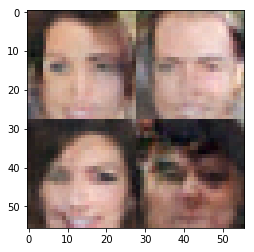

Epoch 7/30... Discriminator Loss: 1.1657... Generator Loss: 1.7673
Epoch 7/30... Discriminator Loss: 1.2365... Generator Loss: 1.1094
Epoch 7/30... Discriminator Loss: 0.9628... Generator Loss: 1.2025
Epoch 7/30... Discriminator Loss: 1.2197... Generator Loss: 0.8636
Epoch 7/30... Discriminator Loss: 1.1301... Generator Loss: 1.2727
Epoch 7/30... Discriminator Loss: 1.1624... Generator Loss: 0.7520
Epoch 7/30... Discriminator Loss: 1.2588... Generator Loss: 0.6423
Epoch 7/30... Discriminator Loss: 1.1437... Generator Loss: 1.2090
Epoch 7/30... Discriminator Loss: 0.9312... Generator Loss: 1.1620
Epoch 7/30... Discriminator Loss: 1.1944... Generator Loss: 0.6543


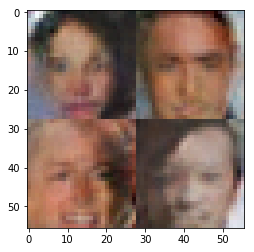

Epoch 7/30... Discriminator Loss: 0.9603... Generator Loss: 0.7481
Epoch 7/30... Discriminator Loss: 1.0283... Generator Loss: 1.2996
Epoch 7/30... Discriminator Loss: 1.0794... Generator Loss: 0.7229
Epoch 7/30... Discriminator Loss: 1.5369... Generator Loss: 0.3613
Epoch 7/30... Discriminator Loss: 1.1734... Generator Loss: 0.9714
Epoch 7/30... Discriminator Loss: 1.1164... Generator Loss: 1.2415
Epoch 7/30... Discriminator Loss: 1.0815... Generator Loss: 0.6403
Epoch 7/30... Discriminator Loss: 0.9915... Generator Loss: 1.0341
Epoch 7/30... Discriminator Loss: 1.0532... Generator Loss: 0.8675
Epoch 7/30... Discriminator Loss: 0.9853... Generator Loss: 1.4352


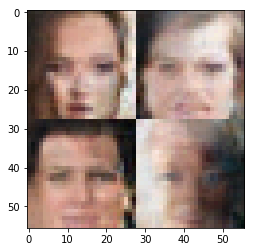

Epoch 7/30... Discriminator Loss: 0.9872... Generator Loss: 0.8278
Epoch 7/30... Discriminator Loss: 1.1005... Generator Loss: 0.8411
Epoch 7/30... Discriminator Loss: 1.4226... Generator Loss: 0.4582
Epoch 7/30... Discriminator Loss: 1.0078... Generator Loss: 0.7046
Epoch 7/30... Discriminator Loss: 1.3689... Generator Loss: 0.4108
Epoch 7/30... Discriminator Loss: 1.1763... Generator Loss: 0.8634
Epoch 7/30... Discriminator Loss: 0.8891... Generator Loss: 1.4362
Epoch 7/30... Discriminator Loss: 1.6985... Generator Loss: 0.8455
Epoch 7/30... Discriminator Loss: 1.8406... Generator Loss: 0.4619
Epoch 7/30... Discriminator Loss: 0.9071... Generator Loss: 0.8487


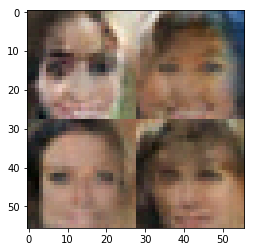

Epoch 7/30... Discriminator Loss: 1.1845... Generator Loss: 0.8391
Epoch 7/30... Discriminator Loss: 1.0365... Generator Loss: 0.8788
Epoch 7/30... Discriminator Loss: 1.1277... Generator Loss: 0.8800
Epoch 7/30... Discriminator Loss: 1.6026... Generator Loss: 0.3052
Epoch 7/30... Discriminator Loss: 1.2642... Generator Loss: 1.3489
Epoch 7/30... Discriminator Loss: 1.1146... Generator Loss: 0.6747
Epoch 7/30... Discriminator Loss: 1.1326... Generator Loss: 1.3289
Epoch 7/30... Discriminator Loss: 1.1915... Generator Loss: 1.6843
Epoch 7/30... Discriminator Loss: 1.2448... Generator Loss: 0.8112
Epoch 7/30... Discriminator Loss: 1.1043... Generator Loss: 0.7439


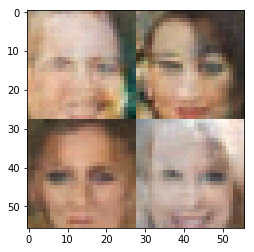

Epoch 7/30... Discriminator Loss: 0.9939... Generator Loss: 0.8516
Epoch 7/30... Discriminator Loss: 1.2205... Generator Loss: 1.2394
Epoch 7/30... Discriminator Loss: 1.1882... Generator Loss: 0.6081
Epoch 7/30... Discriminator Loss: 1.5796... Generator Loss: 1.2217
Epoch 7/30... Discriminator Loss: 1.2897... Generator Loss: 0.9369
Epoch 7/30... Discriminator Loss: 1.2290... Generator Loss: 0.6711
Epoch 7/30... Discriminator Loss: 1.7159... Generator Loss: 0.4493
Epoch 7/30... Discriminator Loss: 0.9734... Generator Loss: 0.8865
Epoch 7/30... Discriminator Loss: 1.2907... Generator Loss: 0.7085
Epoch 7/30... Discriminator Loss: 1.1703... Generator Loss: 0.7077


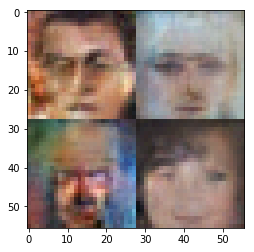

Epoch 7/30... Discriminator Loss: 0.8350... Generator Loss: 0.9212
Epoch 7/30... Discriminator Loss: 0.9076... Generator Loss: 1.2721
Epoch 7/30... Discriminator Loss: 0.7890... Generator Loss: 1.3130
Epoch 7/30... Discriminator Loss: 1.1431... Generator Loss: 0.6203
Epoch 7/30... Discriminator Loss: 1.3621... Generator Loss: 0.4832
Epoch 7/30... Discriminator Loss: 1.1767... Generator Loss: 1.6661
Epoch 7/30... Discriminator Loss: 0.8770... Generator Loss: 0.8509
Epoch 7/30... Discriminator Loss: 1.1349... Generator Loss: 0.6795
Epoch 7/30... Discriminator Loss: 1.0082... Generator Loss: 1.1660
Epoch 7/30... Discriminator Loss: 0.6717... Generator Loss: 1.7007


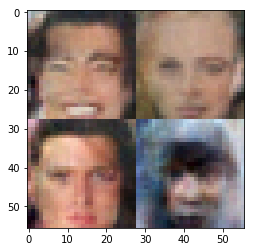

Epoch 7/30... Discriminator Loss: 0.9773... Generator Loss: 0.5878
Epoch 7/30... Discriminator Loss: 1.8286... Generator Loss: 0.3724
Epoch 7/30... Discriminator Loss: 1.3612... Generator Loss: 0.8936
Epoch 7/30... Discriminator Loss: 1.2863... Generator Loss: 1.2338
Epoch 7/30... Discriminator Loss: 1.0881... Generator Loss: 1.0810
Epoch 7/30... Discriminator Loss: 1.2880... Generator Loss: 0.7476
Epoch 7/30... Discriminator Loss: 1.5440... Generator Loss: 0.6102
Epoch 7/30... Discriminator Loss: 0.7976... Generator Loss: 1.3144
Epoch 7/30... Discriminator Loss: 1.0381... Generator Loss: 1.0803
Epoch 7/30... Discriminator Loss: 1.3727... Generator Loss: 0.4270


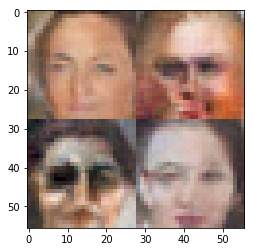

Epoch 7/30... Discriminator Loss: 1.2302... Generator Loss: 0.5120
Epoch 7/30... Discriminator Loss: 1.0739... Generator Loss: 1.1034
Epoch 7/30... Discriminator Loss: 1.0714... Generator Loss: 1.0717
Epoch 7/30... Discriminator Loss: 0.9112... Generator Loss: 0.9189
Epoch 7/30... Discriminator Loss: 0.9971... Generator Loss: 1.1479
Epoch 7/30... Discriminator Loss: 1.1965... Generator Loss: 0.7710
Epoch 7/30... Discriminator Loss: 0.7897... Generator Loss: 0.9439
Epoch 7/30... Discriminator Loss: 1.0161... Generator Loss: 1.6669
Epoch 7/30... Discriminator Loss: 1.1009... Generator Loss: 0.6682
Epoch 7/30... Discriminator Loss: 1.2136... Generator Loss: 0.9867


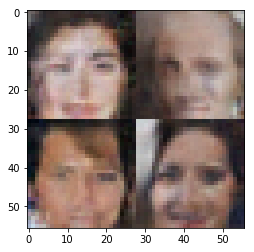

Epoch 7/30... Discriminator Loss: 1.1131... Generator Loss: 1.2233
Epoch 7/30... Discriminator Loss: 0.8860... Generator Loss: 1.0093
Epoch 7/30... Discriminator Loss: 1.1110... Generator Loss: 1.0222
Epoch 7/30... Discriminator Loss: 0.9904... Generator Loss: 1.0515
Epoch 7/30... Discriminator Loss: 1.2711... Generator Loss: 1.0932
Epoch 7/30... Discriminator Loss: 1.0845... Generator Loss: 0.7771
Epoch 7/30... Discriminator Loss: 1.2099... Generator Loss: 0.8275
Epoch 7/30... Discriminator Loss: 1.1749... Generator Loss: 0.8651
Epoch 7/30... Discriminator Loss: 1.1261... Generator Loss: 0.9835
Epoch 7/30... Discriminator Loss: 1.2610... Generator Loss: 0.9738


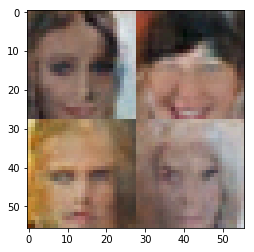

Epoch 7/30... Discriminator Loss: 1.0596... Generator Loss: 0.8208
Epoch 7/30... Discriminator Loss: 1.2168... Generator Loss: 0.6684
Epoch 7/30... Discriminator Loss: 1.8175... Generator Loss: 0.4434
Epoch 7/30... Discriminator Loss: 1.1712... Generator Loss: 0.8210
Epoch 7/30... Discriminator Loss: 1.0227... Generator Loss: 0.9288
Epoch 7/30... Discriminator Loss: 1.0494... Generator Loss: 0.9434
Epoch 7/30... Discriminator Loss: 0.8952... Generator Loss: 1.1042
Epoch 7/30... Discriminator Loss: 1.1699... Generator Loss: 0.5392
Epoch 7/30... Discriminator Loss: 1.7907... Generator Loss: 0.2564
Epoch 7/30... Discriminator Loss: 1.2147... Generator Loss: 0.8399


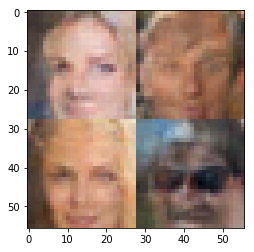

Epoch 7/30... Discriminator Loss: 1.1075... Generator Loss: 1.3444
Epoch 7/30... Discriminator Loss: 1.3294... Generator Loss: 0.4573
Epoch 7/30... Discriminator Loss: 1.2430... Generator Loss: 0.5314
Epoch 7/30... Discriminator Loss: 1.3400... Generator Loss: 0.4465
Epoch 7/30... Discriminator Loss: 1.3633... Generator Loss: 0.5022
Epoch 7/30... Discriminator Loss: 0.4466... Generator Loss: 2.0040
Epoch 7/30... Discriminator Loss: 1.1395... Generator Loss: 0.5887
Epoch 7/30... Discriminator Loss: 0.7524... Generator Loss: 1.2715
Epoch 7/30... Discriminator Loss: 0.9791... Generator Loss: 2.5583
Epoch 7/30... Discriminator Loss: 0.7069... Generator Loss: 1.5419


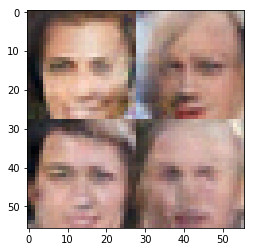

Epoch 7/30... Discriminator Loss: 1.5071... Generator Loss: 3.4519
Epoch 7/30... Discriminator Loss: 1.6755... Generator Loss: 0.6611
Epoch 7/30... Discriminator Loss: 0.9890... Generator Loss: 1.1131
Epoch 7/30... Discriminator Loss: 1.0555... Generator Loss: 0.7317
Epoch 7/30... Discriminator Loss: 1.6295... Generator Loss: 1.3726
Epoch 7/30... Discriminator Loss: 1.1511... Generator Loss: 0.7356
Epoch 7/30... Discriminator Loss: 1.1262... Generator Loss: 1.4345
Epoch 7/30... Discriminator Loss: 1.2951... Generator Loss: 1.1147
Epoch 7/30... Discriminator Loss: 1.1053... Generator Loss: 1.1418
Epoch 7/30... Discriminator Loss: 1.1472... Generator Loss: 0.7629


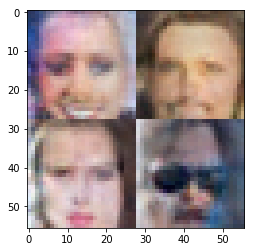

Epoch 7/30... Discriminator Loss: 1.5273... Generator Loss: 0.3757
Epoch 7/30... Discriminator Loss: 1.1201... Generator Loss: 0.8668
Epoch 7/30... Discriminator Loss: 1.1591... Generator Loss: 1.1302
Epoch 7/30... Discriminator Loss: 1.2602... Generator Loss: 1.1165
Epoch 7/30... Discriminator Loss: 1.0817... Generator Loss: 0.9249
Epoch 7/30... Discriminator Loss: 0.7284... Generator Loss: 1.3627
Epoch 7/30... Discriminator Loss: 1.1460... Generator Loss: 0.6053
Epoch 7/30... Discriminator Loss: 1.1670... Generator Loss: 0.6364
Epoch 7/30... Discriminator Loss: 1.1565... Generator Loss: 0.7764
Epoch 7/30... Discriminator Loss: 0.7607... Generator Loss: 1.0981


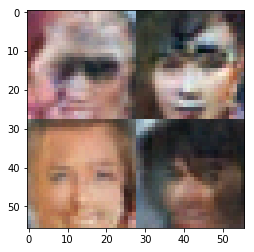

Epoch 7/30... Discriminator Loss: 1.0018... Generator Loss: 0.9759
Epoch 7/30... Discriminator Loss: 0.9633... Generator Loss: 0.9861
Epoch 7/30... Discriminator Loss: 1.3990... Generator Loss: 0.3915
Epoch 7/30... Discriminator Loss: 0.8708... Generator Loss: 1.1736
Epoch 7/30... Discriminator Loss: 0.6558... Generator Loss: 1.1972
Epoch 7/30... Discriminator Loss: 1.3128... Generator Loss: 0.4598
Epoch 7/30... Discriminator Loss: 1.1536... Generator Loss: 1.7734
Epoch 7/30... Discriminator Loss: 1.0708... Generator Loss: 1.2529
Epoch 7/30... Discriminator Loss: 1.1074... Generator Loss: 1.1165
Epoch 7/30... Discriminator Loss: 1.2265... Generator Loss: 0.7179


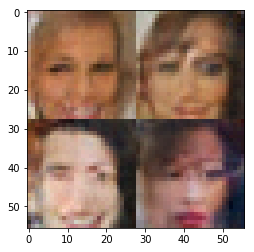

Epoch 7/30... Discriminator Loss: 1.2637... Generator Loss: 0.6269
Epoch 7/30... Discriminator Loss: 0.9968... Generator Loss: 1.3882
Epoch 7/30... Discriminator Loss: 0.7398... Generator Loss: 2.1101
Epoch 7/30... Discriminator Loss: 1.0019... Generator Loss: 1.4063
Epoch 7/30... Discriminator Loss: 0.9743... Generator Loss: 1.2842
Epoch 7/30... Discriminator Loss: 1.2724... Generator Loss: 1.2494
Epoch 7/30... Discriminator Loss: 1.1586... Generator Loss: 0.5950
Epoch 7/30... Discriminator Loss: 1.1319... Generator Loss: 1.0933
Epoch 7/30... Discriminator Loss: 0.6899... Generator Loss: 1.2967
Epoch 7/30... Discriminator Loss: 1.0021... Generator Loss: 1.1782


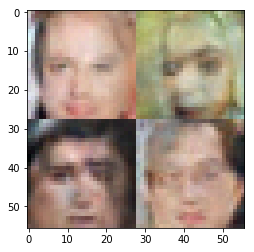

Epoch 7/30... Discriminator Loss: 0.9114... Generator Loss: 1.5633
Epoch 7/30... Discriminator Loss: 1.4122... Generator Loss: 0.4580
Epoch 7/30... Discriminator Loss: 0.9707... Generator Loss: 1.0021
Epoch 7/30... Discriminator Loss: 0.9385... Generator Loss: 3.1912
Epoch 7/30... Discriminator Loss: 1.1275... Generator Loss: 1.8015
Epoch 7/30... Discriminator Loss: 1.1819... Generator Loss: 0.5340
Epoch 7/30... Discriminator Loss: 0.5782... Generator Loss: 1.4506
epoch_i 7
Epoch 8/30... Discriminator Loss: 1.3507... Generator Loss: 1.6515
Epoch 8/30... Discriminator Loss: 0.6533... Generator Loss: 1.5726
Epoch 8/30... Discriminator Loss: 0.4019... Generator Loss: 3.8301


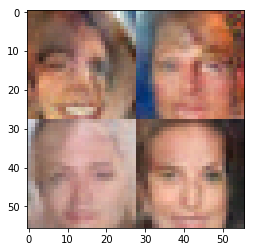

Epoch 8/30... Discriminator Loss: 2.0795... Generator Loss: 0.2943
Epoch 8/30... Discriminator Loss: 0.9118... Generator Loss: 0.9429
Epoch 8/30... Discriminator Loss: 0.7019... Generator Loss: 1.8508
Epoch 8/30... Discriminator Loss: 0.6503... Generator Loss: 1.7578
Epoch 8/30... Discriminator Loss: 1.3081... Generator Loss: 0.4829
Epoch 8/30... Discriminator Loss: 0.6776... Generator Loss: 1.3735
Epoch 8/30... Discriminator Loss: 0.7105... Generator Loss: 1.2797
Epoch 8/30... Discriminator Loss: 0.6961... Generator Loss: 2.8465
Epoch 8/30... Discriminator Loss: 2.0698... Generator Loss: 0.2179
Epoch 8/30... Discriminator Loss: 0.8450... Generator Loss: 2.6059


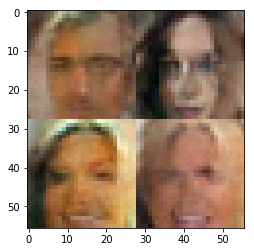

Epoch 8/30... Discriminator Loss: 0.8304... Generator Loss: 0.8604
Epoch 8/30... Discriminator Loss: 0.7300... Generator Loss: 1.4508
Epoch 8/30... Discriminator Loss: 0.8463... Generator Loss: 1.1774
Epoch 8/30... Discriminator Loss: 0.7657... Generator Loss: 1.5713
Epoch 8/30... Discriminator Loss: 1.2130... Generator Loss: 0.6894
Epoch 8/30... Discriminator Loss: 0.8514... Generator Loss: 0.9566
Epoch 8/30... Discriminator Loss: 0.6870... Generator Loss: 1.7739
Epoch 8/30... Discriminator Loss: 0.7105... Generator Loss: 1.9812
Epoch 8/30... Discriminator Loss: 1.7100... Generator Loss: 1.1760
Epoch 8/30... Discriminator Loss: 1.2695... Generator Loss: 0.9684


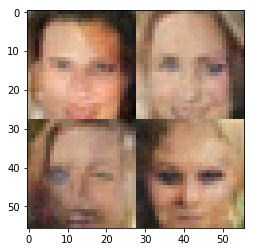

Epoch 8/30... Discriminator Loss: 1.0417... Generator Loss: 0.9624
Epoch 8/30... Discriminator Loss: 1.0556... Generator Loss: 0.7426
Epoch 8/30... Discriminator Loss: 1.3012... Generator Loss: 0.5952
Epoch 8/30... Discriminator Loss: 1.2151... Generator Loss: 1.0739
Epoch 8/30... Discriminator Loss: 1.4140... Generator Loss: 0.7344
Epoch 8/30... Discriminator Loss: 1.1350... Generator Loss: 0.9329
Epoch 8/30... Discriminator Loss: 1.0845... Generator Loss: 0.8072
Epoch 8/30... Discriminator Loss: 1.1648... Generator Loss: 1.0792
Epoch 8/30... Discriminator Loss: 1.0569... Generator Loss: 0.9805
Epoch 8/30... Discriminator Loss: 1.0048... Generator Loss: 0.7747


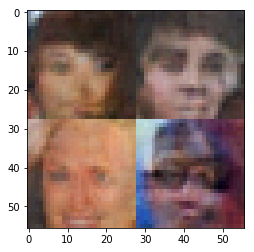

Epoch 8/30... Discriminator Loss: 1.4136... Generator Loss: 1.2227
Epoch 8/30... Discriminator Loss: 1.3356... Generator Loss: 0.5106
Epoch 8/30... Discriminator Loss: 1.2320... Generator Loss: 0.6542
Epoch 8/30... Discriminator Loss: 1.2632... Generator Loss: 0.7664
Epoch 8/30... Discriminator Loss: 0.9584... Generator Loss: 0.9954
Epoch 8/30... Discriminator Loss: 1.2320... Generator Loss: 1.0170
Epoch 8/30... Discriminator Loss: 1.0908... Generator Loss: 0.9629
Epoch 8/30... Discriminator Loss: 1.1385... Generator Loss: 0.8046
Epoch 8/30... Discriminator Loss: 1.4536... Generator Loss: 0.4583
Epoch 8/30... Discriminator Loss: 1.2350... Generator Loss: 0.7872


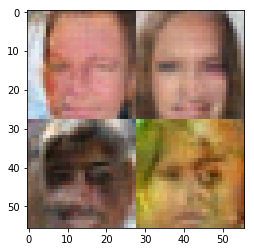

Epoch 8/30... Discriminator Loss: 1.0626... Generator Loss: 1.0101
Epoch 8/30... Discriminator Loss: 1.1751... Generator Loss: 1.0565
Epoch 8/30... Discriminator Loss: 1.2466... Generator Loss: 0.5220
Epoch 8/30... Discriminator Loss: 1.6091... Generator Loss: 0.3477
Epoch 8/30... Discriminator Loss: 1.0723... Generator Loss: 0.9948
Epoch 8/30... Discriminator Loss: 1.4365... Generator Loss: 1.0704
Epoch 8/30... Discriminator Loss: 1.2351... Generator Loss: 0.9623
Epoch 8/30... Discriminator Loss: 1.1575... Generator Loss: 0.7169
Epoch 8/30... Discriminator Loss: 1.2504... Generator Loss: 0.5102
Epoch 8/30... Discriminator Loss: 1.2795... Generator Loss: 0.7160


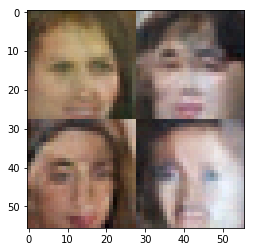

Epoch 8/30... Discriminator Loss: 1.1659... Generator Loss: 1.0208
Epoch 8/30... Discriminator Loss: 1.1139... Generator Loss: 0.7632
Epoch 8/30... Discriminator Loss: 1.2957... Generator Loss: 0.6894
Epoch 8/30... Discriminator Loss: 1.3955... Generator Loss: 0.6186
Epoch 8/30... Discriminator Loss: 1.3813... Generator Loss: 0.4604
Epoch 8/30... Discriminator Loss: 1.7459... Generator Loss: 0.5681
Epoch 8/30... Discriminator Loss: 1.2495... Generator Loss: 1.4108
Epoch 8/30... Discriminator Loss: 1.1510... Generator Loss: 0.6636
Epoch 8/30... Discriminator Loss: 1.1680... Generator Loss: 1.0561
Epoch 8/30... Discriminator Loss: 1.4812... Generator Loss: 0.6396


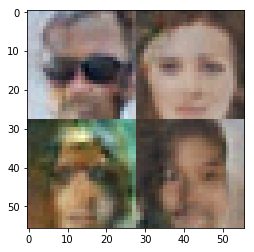

Epoch 8/30... Discriminator Loss: 1.2645... Generator Loss: 0.6514
Epoch 8/30... Discriminator Loss: 1.3075... Generator Loss: 1.1053
Epoch 8/30... Discriminator Loss: 1.3764... Generator Loss: 1.3149
Epoch 8/30... Discriminator Loss: 1.0856... Generator Loss: 0.7887
Epoch 8/30... Discriminator Loss: 1.2112... Generator Loss: 0.8479
Epoch 8/30... Discriminator Loss: 1.2806... Generator Loss: 1.3335
Epoch 8/30... Discriminator Loss: 1.3455... Generator Loss: 0.6690
Epoch 8/30... Discriminator Loss: 1.1361... Generator Loss: 0.6189
Epoch 8/30... Discriminator Loss: 0.9882... Generator Loss: 0.9355
Epoch 8/30... Discriminator Loss: 1.5508... Generator Loss: 1.1402


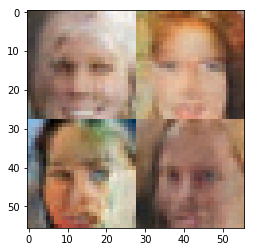

Epoch 8/30... Discriminator Loss: 1.7184... Generator Loss: 0.6281
Epoch 8/30... Discriminator Loss: 1.2336... Generator Loss: 0.7985
Epoch 8/30... Discriminator Loss: 1.2321... Generator Loss: 0.8031
Epoch 8/30... Discriminator Loss: 1.2800... Generator Loss: 0.8109
Epoch 8/30... Discriminator Loss: 1.0828... Generator Loss: 1.0766
Epoch 8/30... Discriminator Loss: 1.4258... Generator Loss: 0.8015
Epoch 8/30... Discriminator Loss: 1.4399... Generator Loss: 0.7685
Epoch 8/30... Discriminator Loss: 1.3853... Generator Loss: 0.9338
Epoch 8/30... Discriminator Loss: 1.0001... Generator Loss: 0.9289
Epoch 8/30... Discriminator Loss: 1.3852... Generator Loss: 0.4946


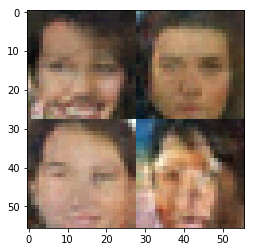

Epoch 8/30... Discriminator Loss: 1.4639... Generator Loss: 1.0415
Epoch 8/30... Discriminator Loss: 1.2750... Generator Loss: 0.5221
Epoch 8/30... Discriminator Loss: 1.2702... Generator Loss: 0.5781
Epoch 8/30... Discriminator Loss: 1.0901... Generator Loss: 0.9453
Epoch 8/30... Discriminator Loss: 1.2589... Generator Loss: 1.0247
Epoch 8/30... Discriminator Loss: 1.1084... Generator Loss: 0.8959
Epoch 8/30... Discriminator Loss: 1.0123... Generator Loss: 1.3332
Epoch 8/30... Discriminator Loss: 1.3117... Generator Loss: 0.9892
Epoch 8/30... Discriminator Loss: 1.2659... Generator Loss: 0.6016
Epoch 8/30... Discriminator Loss: 1.1891... Generator Loss: 0.7959


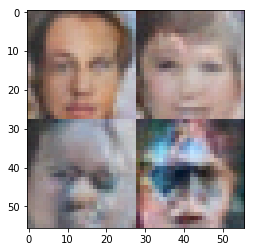

Epoch 8/30... Discriminator Loss: 1.1823... Generator Loss: 0.6602
Epoch 8/30... Discriminator Loss: 1.0480... Generator Loss: 0.8957
Epoch 8/30... Discriminator Loss: 1.0423... Generator Loss: 1.4294
Epoch 8/30... Discriminator Loss: 1.4430... Generator Loss: 0.4683
Epoch 8/30... Discriminator Loss: 1.4319... Generator Loss: 0.6159
Epoch 8/30... Discriminator Loss: 1.0356... Generator Loss: 1.0318
Epoch 8/30... Discriminator Loss: 1.3568... Generator Loss: 0.6250
Epoch 8/30... Discriminator Loss: 1.2345... Generator Loss: 0.5093
Epoch 8/30... Discriminator Loss: 1.2579... Generator Loss: 0.6427
Epoch 8/30... Discriminator Loss: 1.1795... Generator Loss: 0.7184


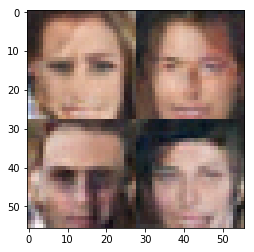

Epoch 8/30... Discriminator Loss: 1.3414... Generator Loss: 0.5956
Epoch 8/30... Discriminator Loss: 1.4543... Generator Loss: 0.7901
Epoch 8/30... Discriminator Loss: 1.4544... Generator Loss: 0.4504
Epoch 8/30... Discriminator Loss: 1.5104... Generator Loss: 0.6530
Epoch 8/30... Discriminator Loss: 1.4460... Generator Loss: 1.2327
Epoch 8/30... Discriminator Loss: 1.3778... Generator Loss: 0.7820
Epoch 8/30... Discriminator Loss: 1.4692... Generator Loss: 0.6972
Epoch 8/30... Discriminator Loss: 1.1486... Generator Loss: 1.2264
Epoch 8/30... Discriminator Loss: 1.1683... Generator Loss: 1.5525
Epoch 8/30... Discriminator Loss: 1.0421... Generator Loss: 1.3695


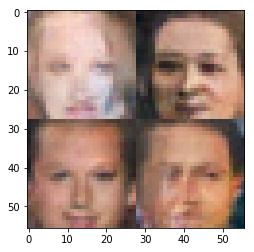

Epoch 8/30... Discriminator Loss: 0.9011... Generator Loss: 1.1097
Epoch 8/30... Discriminator Loss: 1.1573... Generator Loss: 0.9686
Epoch 8/30... Discriminator Loss: 1.3100... Generator Loss: 1.4171
Epoch 8/30... Discriminator Loss: 1.2858... Generator Loss: 0.5150
Epoch 8/30... Discriminator Loss: 1.3306... Generator Loss: 0.5518
Epoch 8/30... Discriminator Loss: 1.2181... Generator Loss: 1.4149
Epoch 8/30... Discriminator Loss: 1.2063... Generator Loss: 0.8082
Epoch 8/30... Discriminator Loss: 1.0872... Generator Loss: 1.1178
Epoch 8/30... Discriminator Loss: 1.3578... Generator Loss: 1.0903
Epoch 8/30... Discriminator Loss: 1.4203... Generator Loss: 1.1049


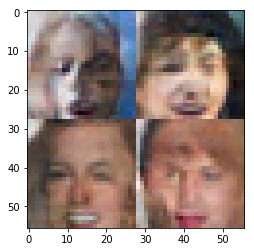

Epoch 8/30... Discriminator Loss: 1.1812... Generator Loss: 1.7026
Epoch 8/30... Discriminator Loss: 1.3445... Generator Loss: 0.9317
Epoch 8/30... Discriminator Loss: 1.3491... Generator Loss: 0.6673
Epoch 8/30... Discriminator Loss: 1.1596... Generator Loss: 0.6960
Epoch 8/30... Discriminator Loss: 1.5680... Generator Loss: 0.4402
Epoch 8/30... Discriminator Loss: 1.3292... Generator Loss: 1.3236
Epoch 8/30... Discriminator Loss: 1.6638... Generator Loss: 0.5151
Epoch 8/30... Discriminator Loss: 1.2982... Generator Loss: 0.7576
Epoch 8/30... Discriminator Loss: 1.2148... Generator Loss: 0.9142
Epoch 8/30... Discriminator Loss: 1.2346... Generator Loss: 0.7022


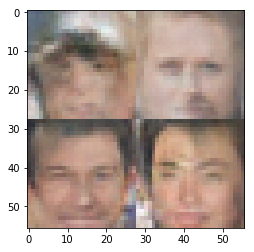

Epoch 8/30... Discriminator Loss: 0.9174... Generator Loss: 0.9972
Epoch 8/30... Discriminator Loss: 1.2531... Generator Loss: 0.5626
Epoch 8/30... Discriminator Loss: 1.4560... Generator Loss: 0.4089
Epoch 8/30... Discriminator Loss: 1.3614... Generator Loss: 0.6273
Epoch 8/30... Discriminator Loss: 1.4555... Generator Loss: 0.4124
Epoch 8/30... Discriminator Loss: 1.0971... Generator Loss: 0.9732
Epoch 8/30... Discriminator Loss: 1.0643... Generator Loss: 0.8855
Epoch 8/30... Discriminator Loss: 1.3318... Generator Loss: 0.9002
Epoch 8/30... Discriminator Loss: 1.2684... Generator Loss: 0.9665
Epoch 8/30... Discriminator Loss: 1.2199... Generator Loss: 0.8483


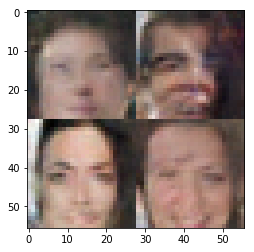

Epoch 8/30... Discriminator Loss: 0.9274... Generator Loss: 0.7862
Epoch 8/30... Discriminator Loss: 1.0842... Generator Loss: 0.8744
Epoch 8/30... Discriminator Loss: 1.3084... Generator Loss: 0.4993
Epoch 8/30... Discriminator Loss: 1.3727... Generator Loss: 1.0010
Epoch 8/30... Discriminator Loss: 1.6223... Generator Loss: 0.3267
Epoch 8/30... Discriminator Loss: 1.4392... Generator Loss: 0.8857
Epoch 8/30... Discriminator Loss: 1.3818... Generator Loss: 0.4517
Epoch 8/30... Discriminator Loss: 0.8566... Generator Loss: 1.1380
Epoch 8/30... Discriminator Loss: 1.1769... Generator Loss: 0.7561
Epoch 8/30... Discriminator Loss: 1.6876... Generator Loss: 0.2908


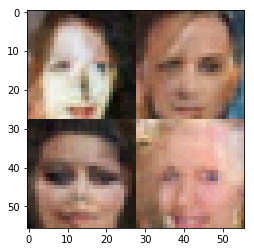

Epoch 8/30... Discriminator Loss: 1.2016... Generator Loss: 0.8387
Epoch 8/30... Discriminator Loss: 1.0166... Generator Loss: 1.0998
Epoch 8/30... Discriminator Loss: 1.2512... Generator Loss: 0.6076
Epoch 8/30... Discriminator Loss: 1.1369... Generator Loss: 0.7775
Epoch 8/30... Discriminator Loss: 1.1635... Generator Loss: 1.0073
epoch_i 8
Epoch 9/30... Discriminator Loss: 1.1888... Generator Loss: 0.6327
Epoch 9/30... Discriminator Loss: 1.3624... Generator Loss: 1.1513
Epoch 9/30... Discriminator Loss: 1.3749... Generator Loss: 0.6066
Epoch 9/30... Discriminator Loss: 1.2996... Generator Loss: 0.7651
Epoch 9/30... Discriminator Loss: 1.2777... Generator Loss: 0.6134


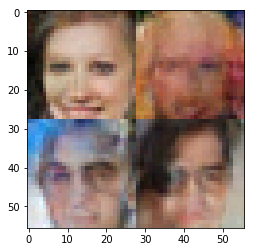

Epoch 9/30... Discriminator Loss: 0.9631... Generator Loss: 0.8050
Epoch 9/30... Discriminator Loss: 1.6083... Generator Loss: 0.3470
Epoch 9/30... Discriminator Loss: 1.6002... Generator Loss: 0.7045
Epoch 9/30... Discriminator Loss: 1.2691... Generator Loss: 0.7395
Epoch 9/30... Discriminator Loss: 1.3978... Generator Loss: 0.5187
Epoch 9/30... Discriminator Loss: 1.4362... Generator Loss: 0.4293
Epoch 9/30... Discriminator Loss: 1.0980... Generator Loss: 0.8007
Epoch 9/30... Discriminator Loss: 1.1327... Generator Loss: 1.2995
Epoch 9/30... Discriminator Loss: 1.3041... Generator Loss: 0.5040
Epoch 9/30... Discriminator Loss: 1.0168... Generator Loss: 1.2451


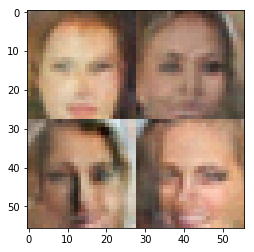

Epoch 9/30... Discriminator Loss: 1.1556... Generator Loss: 0.8580
Epoch 9/30... Discriminator Loss: 1.3322... Generator Loss: 0.4607
Epoch 9/30... Discriminator Loss: 1.3039... Generator Loss: 0.6108
Epoch 9/30... Discriminator Loss: 1.2714... Generator Loss: 1.5799
Epoch 9/30... Discriminator Loss: 1.1069... Generator Loss: 0.7047
Epoch 9/30... Discriminator Loss: 1.3225... Generator Loss: 0.5308
Epoch 9/30... Discriminator Loss: 1.4367... Generator Loss: 0.3891
Epoch 9/30... Discriminator Loss: 1.3675... Generator Loss: 0.4804
Epoch 9/30... Discriminator Loss: 1.3993... Generator Loss: 0.6797
Epoch 9/30... Discriminator Loss: 1.1445... Generator Loss: 1.1148


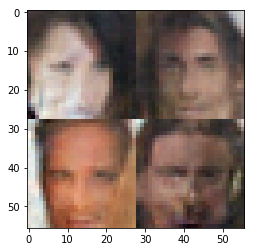

Epoch 9/30... Discriminator Loss: 0.9203... Generator Loss: 1.4456
Epoch 9/30... Discriminator Loss: 1.4518... Generator Loss: 0.4096
Epoch 9/30... Discriminator Loss: 1.1467... Generator Loss: 1.0705
Epoch 9/30... Discriminator Loss: 1.2610... Generator Loss: 0.5721
Epoch 9/30... Discriminator Loss: 1.1910... Generator Loss: 0.7372
Epoch 9/30... Discriminator Loss: 1.3868... Generator Loss: 0.3987
Epoch 9/30... Discriminator Loss: 2.6233... Generator Loss: 1.4534
Epoch 9/30... Discriminator Loss: 1.4031... Generator Loss: 0.5863
Epoch 9/30... Discriminator Loss: 1.3151... Generator Loss: 0.5783
Epoch 9/30... Discriminator Loss: 1.1994... Generator Loss: 0.9578


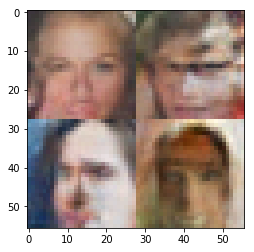

Epoch 9/30... Discriminator Loss: 1.2987... Generator Loss: 0.6114
Epoch 9/30... Discriminator Loss: 1.1969... Generator Loss: 0.7510
Epoch 9/30... Discriminator Loss: 1.2850... Generator Loss: 0.9043
Epoch 9/30... Discriminator Loss: 1.6129... Generator Loss: 0.3803
Epoch 9/30... Discriminator Loss: 1.1847... Generator Loss: 0.9684
Epoch 9/30... Discriminator Loss: 1.1390... Generator Loss: 0.8989
Epoch 9/30... Discriminator Loss: 1.2151... Generator Loss: 0.6803
Epoch 9/30... Discriminator Loss: 1.2053... Generator Loss: 0.7959
Epoch 9/30... Discriminator Loss: 1.1233... Generator Loss: 0.8262
Epoch 9/30... Discriminator Loss: 1.2958... Generator Loss: 0.6858


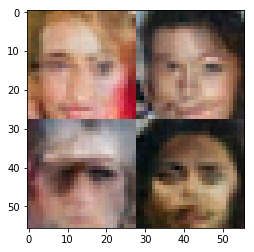

Epoch 9/30... Discriminator Loss: 1.3149... Generator Loss: 0.7841
Epoch 9/30... Discriminator Loss: 1.1817... Generator Loss: 0.8455
Epoch 9/30... Discriminator Loss: 1.3382... Generator Loss: 0.6045
Epoch 9/30... Discriminator Loss: 1.2498... Generator Loss: 0.7796
Epoch 9/30... Discriminator Loss: 0.9575... Generator Loss: 0.8898
Epoch 9/30... Discriminator Loss: 1.1437... Generator Loss: 1.2825
Epoch 9/30... Discriminator Loss: 1.1830... Generator Loss: 0.6454
Epoch 9/30... Discriminator Loss: 1.2611... Generator Loss: 0.8750
Epoch 9/30... Discriminator Loss: 1.1683... Generator Loss: 0.7726
Epoch 9/30... Discriminator Loss: 1.1331... Generator Loss: 0.7274


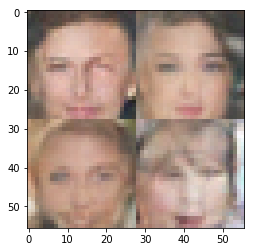

Epoch 9/30... Discriminator Loss: 1.4761... Generator Loss: 1.0137
Epoch 9/30... Discriminator Loss: 1.8138... Generator Loss: 1.9941
Epoch 9/30... Discriminator Loss: 1.2473... Generator Loss: 0.9005
Epoch 9/30... Discriminator Loss: 1.2034... Generator Loss: 0.8912
Epoch 9/30... Discriminator Loss: 1.3418... Generator Loss: 0.6019
Epoch 9/30... Discriminator Loss: 1.2605... Generator Loss: 0.7312
Epoch 9/30... Discriminator Loss: 1.0661... Generator Loss: 0.7644
Epoch 9/30... Discriminator Loss: 1.0952... Generator Loss: 0.8715
Epoch 9/30... Discriminator Loss: 1.1474... Generator Loss: 0.7309
Epoch 9/30... Discriminator Loss: 1.1409... Generator Loss: 0.6290


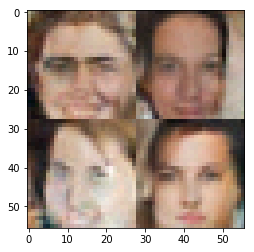

Epoch 9/30... Discriminator Loss: 1.2258... Generator Loss: 0.9783
Epoch 9/30... Discriminator Loss: 1.1587... Generator Loss: 1.0545
Epoch 9/30... Discriminator Loss: 1.2569... Generator Loss: 0.5456
Epoch 9/30... Discriminator Loss: 1.0891... Generator Loss: 1.1111
Epoch 9/30... Discriminator Loss: 1.2389... Generator Loss: 0.7480
Epoch 9/30... Discriminator Loss: 1.2638... Generator Loss: 0.7445
Epoch 9/30... Discriminator Loss: 1.2472... Generator Loss: 0.6891
Epoch 9/30... Discriminator Loss: 1.4263... Generator Loss: 1.6374
Epoch 9/30... Discriminator Loss: 1.3658... Generator Loss: 0.7178
Epoch 9/30... Discriminator Loss: 1.2805... Generator Loss: 0.7123


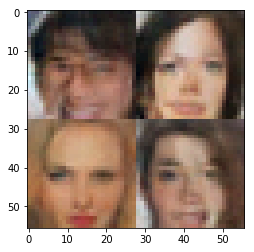

Epoch 9/30... Discriminator Loss: 1.2119... Generator Loss: 0.8361
Epoch 9/30... Discriminator Loss: 1.3802... Generator Loss: 0.5115
Epoch 9/30... Discriminator Loss: 1.0436... Generator Loss: 1.0864
Epoch 9/30... Discriminator Loss: 1.8279... Generator Loss: 0.3038
Epoch 9/30... Discriminator Loss: 0.9558... Generator Loss: 1.4710
Epoch 9/30... Discriminator Loss: 1.3590... Generator Loss: 0.9081
Epoch 9/30... Discriminator Loss: 1.2132... Generator Loss: 0.8160
Epoch 9/30... Discriminator Loss: 2.0139... Generator Loss: 0.2286
Epoch 9/30... Discriminator Loss: 1.1001... Generator Loss: 1.1756
Epoch 9/30... Discriminator Loss: 1.4333... Generator Loss: 0.6380


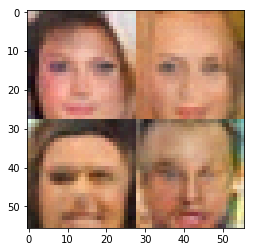

Epoch 9/30... Discriminator Loss: 1.7214... Generator Loss: 0.4063
Epoch 9/30... Discriminator Loss: 1.0153... Generator Loss: 0.8118
Epoch 9/30... Discriminator Loss: 1.2469... Generator Loss: 0.9652
Epoch 9/30... Discriminator Loss: 1.2257... Generator Loss: 0.7440
Epoch 9/30... Discriminator Loss: 1.2872... Generator Loss: 0.6323
Epoch 9/30... Discriminator Loss: 1.3888... Generator Loss: 0.7966
Epoch 9/30... Discriminator Loss: 0.8275... Generator Loss: 1.3331
Epoch 9/30... Discriminator Loss: 1.4785... Generator Loss: 1.5896
Epoch 9/30... Discriminator Loss: 0.8979... Generator Loss: 0.9481
Epoch 9/30... Discriminator Loss: 1.3278... Generator Loss: 0.7005


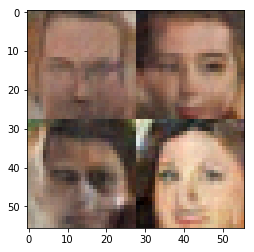

Epoch 9/30... Discriminator Loss: 1.3248... Generator Loss: 0.9560
Epoch 9/30... Discriminator Loss: 1.8315... Generator Loss: 0.4045
Epoch 9/30... Discriminator Loss: 1.1547... Generator Loss: 0.6705
Epoch 9/30... Discriminator Loss: 1.5394... Generator Loss: 0.3792
Epoch 9/30... Discriminator Loss: 1.6137... Generator Loss: 0.4144
Epoch 9/30... Discriminator Loss: 1.8946... Generator Loss: 0.8532
Epoch 9/30... Discriminator Loss: 2.7143... Generator Loss: 0.3154
Epoch 9/30... Discriminator Loss: 1.2530... Generator Loss: 0.8202
Epoch 9/30... Discriminator Loss: 1.4093... Generator Loss: 0.6657
Epoch 9/30... Discriminator Loss: 1.0968... Generator Loss: 0.8581


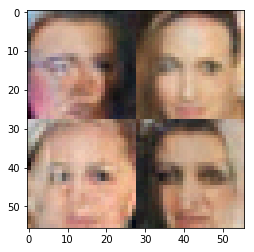

Epoch 9/30... Discriminator Loss: 1.3990... Generator Loss: 0.5378
Epoch 9/30... Discriminator Loss: 1.3514... Generator Loss: 0.4506
Epoch 9/30... Discriminator Loss: 1.5853... Generator Loss: 0.6082
Epoch 9/30... Discriminator Loss: 1.2328... Generator Loss: 1.0746
Epoch 9/30... Discriminator Loss: 1.2543... Generator Loss: 0.8620
Epoch 9/30... Discriminator Loss: 1.2619... Generator Loss: 0.7699
Epoch 9/30... Discriminator Loss: 1.1065... Generator Loss: 1.1265
Epoch 9/30... Discriminator Loss: 1.2547... Generator Loss: 0.8910
Epoch 9/30... Discriminator Loss: 1.1927... Generator Loss: 0.7270
Epoch 9/30... Discriminator Loss: 1.6963... Generator Loss: 0.3473


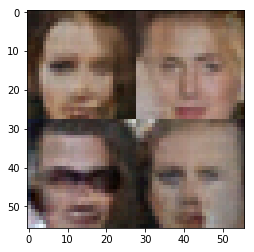

Epoch 9/30... Discriminator Loss: 1.1672... Generator Loss: 0.6965
Epoch 9/30... Discriminator Loss: 1.2280... Generator Loss: 0.7381
Epoch 9/30... Discriminator Loss: 1.2666... Generator Loss: 0.6325
Epoch 9/30... Discriminator Loss: 1.3589... Generator Loss: 0.6666
Epoch 9/30... Discriminator Loss: 1.3586... Generator Loss: 0.7359
Epoch 9/30... Discriminator Loss: 1.5339... Generator Loss: 0.6234
Epoch 9/30... Discriminator Loss: 1.3802... Generator Loss: 0.4913
Epoch 9/30... Discriminator Loss: 1.1608... Generator Loss: 1.1102
Epoch 9/30... Discriminator Loss: 1.2974... Generator Loss: 0.5678
Epoch 9/30... Discriminator Loss: 1.2019... Generator Loss: 0.6287


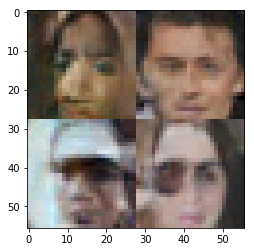

Epoch 9/30... Discriminator Loss: 1.1873... Generator Loss: 0.7075
Epoch 9/30... Discriminator Loss: 1.3299... Generator Loss: 0.5968
Epoch 9/30... Discriminator Loss: 1.3620... Generator Loss: 0.6555
Epoch 9/30... Discriminator Loss: 1.3456... Generator Loss: 0.7342
Epoch 9/30... Discriminator Loss: 1.1345... Generator Loss: 1.0384
Epoch 9/30... Discriminator Loss: 1.2384... Generator Loss: 0.6829
Epoch 9/30... Discriminator Loss: 1.1483... Generator Loss: 0.5850
Epoch 9/30... Discriminator Loss: 1.2704... Generator Loss: 0.6785
Epoch 9/30... Discriminator Loss: 1.3590... Generator Loss: 0.5641
Epoch 9/30... Discriminator Loss: 1.3240... Generator Loss: 0.5037


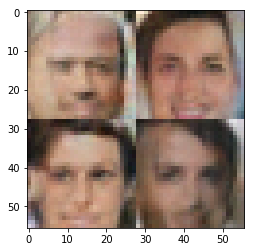

Epoch 9/30... Discriminator Loss: 1.3211... Generator Loss: 0.8155
Epoch 9/30... Discriminator Loss: 1.6406... Generator Loss: 0.4395
Epoch 9/30... Discriminator Loss: 1.1269... Generator Loss: 1.2673
Epoch 9/30... Discriminator Loss: 1.4597... Generator Loss: 0.6802
Epoch 9/30... Discriminator Loss: 1.4470... Generator Loss: 0.5809
Epoch 9/30... Discriminator Loss: 1.2618... Generator Loss: 0.8837
Epoch 9/30... Discriminator Loss: 1.1687... Generator Loss: 0.7626
Epoch 9/30... Discriminator Loss: 1.1093... Generator Loss: 0.7992
Epoch 9/30... Discriminator Loss: 1.3791... Generator Loss: 0.5492
Epoch 9/30... Discriminator Loss: 1.4786... Generator Loss: 0.4556


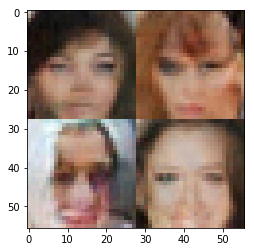

Epoch 9/30... Discriminator Loss: 1.4150... Generator Loss: 0.4172
Epoch 9/30... Discriminator Loss: 1.4628... Generator Loss: 0.8271
Epoch 9/30... Discriminator Loss: 1.1434... Generator Loss: 0.6417
Epoch 9/30... Discriminator Loss: 1.2406... Generator Loss: 0.5161
Epoch 9/30... Discriminator Loss: 1.0558... Generator Loss: 0.7474
Epoch 9/30... Discriminator Loss: 1.6079... Generator Loss: 1.4079
Epoch 9/30... Discriminator Loss: 1.3981... Generator Loss: 0.5407
Epoch 9/30... Discriminator Loss: 1.2312... Generator Loss: 0.5905
Epoch 9/30... Discriminator Loss: 1.4678... Generator Loss: 0.7277
Epoch 9/30... Discriminator Loss: 1.2321... Generator Loss: 0.6132


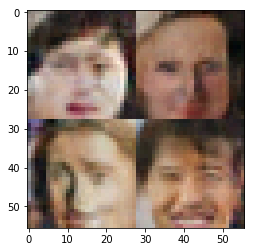

Epoch 9/30... Discriminator Loss: 1.2688... Generator Loss: 0.8485
Epoch 9/30... Discriminator Loss: 1.2855... Generator Loss: 0.6225
Epoch 9/30... Discriminator Loss: 1.3881... Generator Loss: 0.4661
epoch_i 9
Epoch 10/30... Discriminator Loss: 1.0012... Generator Loss: 1.1184
Epoch 10/30... Discriminator Loss: 1.3017... Generator Loss: 0.5696
Epoch 10/30... Discriminator Loss: 1.2594... Generator Loss: 0.8036
Epoch 10/30... Discriminator Loss: 1.0994... Generator Loss: 0.7519
Epoch 10/30... Discriminator Loss: 1.3170... Generator Loss: 0.9613
Epoch 10/30... Discriminator Loss: 1.3285... Generator Loss: 0.6854
Epoch 10/30... Discriminator Loss: 1.3277... Generator Loss: 0.8087


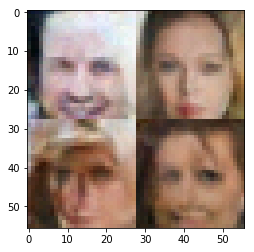

Epoch 10/30... Discriminator Loss: 1.1244... Generator Loss: 0.8297
Epoch 10/30... Discriminator Loss: 1.1442... Generator Loss: 0.9916
Epoch 10/30... Discriminator Loss: 1.2389... Generator Loss: 0.6747
Epoch 10/30... Discriminator Loss: 1.1935... Generator Loss: 0.6308
Epoch 10/30... Discriminator Loss: 1.2721... Generator Loss: 0.7364
Epoch 10/30... Discriminator Loss: 1.3430... Generator Loss: 0.4114
Epoch 10/30... Discriminator Loss: 1.1558... Generator Loss: 0.7766
Epoch 10/30... Discriminator Loss: 1.2680... Generator Loss: 0.6614
Epoch 10/30... Discriminator Loss: 1.3888... Generator Loss: 0.5792
Epoch 10/30... Discriminator Loss: 1.0645... Generator Loss: 0.7797


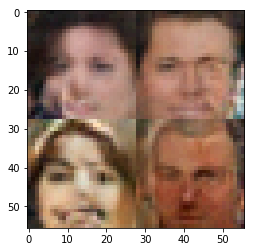

Epoch 10/30... Discriminator Loss: 1.3542... Generator Loss: 0.7197
Epoch 10/30... Discriminator Loss: 1.2119... Generator Loss: 1.0216
Epoch 10/30... Discriminator Loss: 1.3097... Generator Loss: 0.7460
Epoch 10/30... Discriminator Loss: 1.3484... Generator Loss: 0.5988
Epoch 10/30... Discriminator Loss: 1.5834... Generator Loss: 1.5178
Epoch 10/30... Discriminator Loss: 1.2473... Generator Loss: 0.9299
Epoch 10/30... Discriminator Loss: 1.2696... Generator Loss: 0.7143
Epoch 10/30... Discriminator Loss: 1.3355... Generator Loss: 1.1259
Epoch 10/30... Discriminator Loss: 1.2137... Generator Loss: 0.9590
Epoch 10/30... Discriminator Loss: 1.4549... Generator Loss: 0.4207


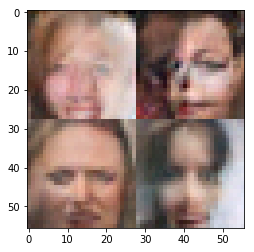

Epoch 10/30... Discriminator Loss: 1.2623... Generator Loss: 0.5803
Epoch 10/30... Discriminator Loss: 2.0634... Generator Loss: 2.3540
Epoch 10/30... Discriminator Loss: 1.4153... Generator Loss: 0.5482
Epoch 10/30... Discriminator Loss: 1.2654... Generator Loss: 1.0055
Epoch 10/30... Discriminator Loss: 1.2859... Generator Loss: 0.5631
Epoch 10/30... Discriminator Loss: 1.3076... Generator Loss: 0.6231
Epoch 10/30... Discriminator Loss: 1.5541... Generator Loss: 0.4235
Epoch 10/30... Discriminator Loss: 1.2024... Generator Loss: 0.7188
Epoch 10/30... Discriminator Loss: 1.0421... Generator Loss: 0.8739
Epoch 10/30... Discriminator Loss: 1.3484... Generator Loss: 0.5578


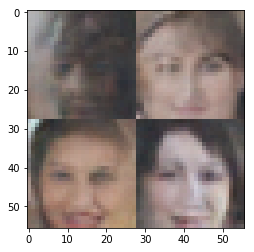

Epoch 10/30... Discriminator Loss: 1.1121... Generator Loss: 1.2515
Epoch 10/30... Discriminator Loss: 1.2677... Generator Loss: 0.6144
Epoch 10/30... Discriminator Loss: 1.3482... Generator Loss: 0.4931
Epoch 10/30... Discriminator Loss: 1.3146... Generator Loss: 0.5915
Epoch 10/30... Discriminator Loss: 1.3894... Generator Loss: 0.9983
Epoch 10/30... Discriminator Loss: 1.4060... Generator Loss: 0.4844
Epoch 10/30... Discriminator Loss: 0.9043... Generator Loss: 1.4365
Epoch 10/30... Discriminator Loss: 1.2139... Generator Loss: 0.7815
Epoch 10/30... Discriminator Loss: 1.3620... Generator Loss: 0.7614
Epoch 10/30... Discriminator Loss: 1.3142... Generator Loss: 0.8637


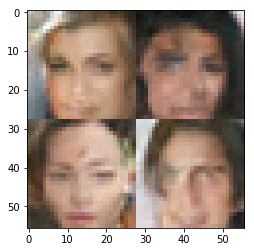

Epoch 10/30... Discriminator Loss: 1.2221... Generator Loss: 0.7643
Epoch 10/30... Discriminator Loss: 1.2993... Generator Loss: 0.5511
Epoch 10/30... Discriminator Loss: 1.1567... Generator Loss: 0.5246
Epoch 10/30... Discriminator Loss: 1.5913... Generator Loss: 0.3067
Epoch 10/30... Discriminator Loss: 1.1583... Generator Loss: 0.5597
Epoch 10/30... Discriminator Loss: 1.2918... Generator Loss: 1.1930
Epoch 10/30... Discriminator Loss: 1.1056... Generator Loss: 0.7876
Epoch 10/30... Discriminator Loss: 0.8705... Generator Loss: 1.4422
Epoch 10/30... Discriminator Loss: 1.0979... Generator Loss: 0.8425
Epoch 10/30... Discriminator Loss: 1.1725... Generator Loss: 0.7868


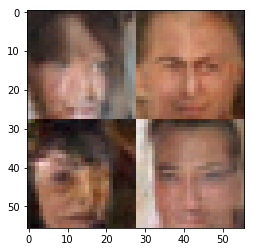

Epoch 10/30... Discriminator Loss: 0.9415... Generator Loss: 1.0252
Epoch 10/30... Discriminator Loss: 1.2063... Generator Loss: 0.5253
Epoch 10/30... Discriminator Loss: 1.2173... Generator Loss: 1.7132
Epoch 10/30... Discriminator Loss: 0.9762... Generator Loss: 1.7961
Epoch 10/30... Discriminator Loss: 1.3835... Generator Loss: 0.9087
Epoch 10/30... Discriminator Loss: 0.8973... Generator Loss: 0.9136
Epoch 10/30... Discriminator Loss: 1.1208... Generator Loss: 0.8242
Epoch 10/30... Discriminator Loss: 1.5879... Generator Loss: 1.6192
Epoch 10/30... Discriminator Loss: 1.1425... Generator Loss: 1.0756
Epoch 10/30... Discriminator Loss: 1.2374... Generator Loss: 0.6097


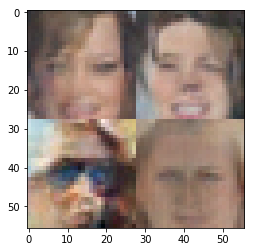

Epoch 10/30... Discriminator Loss: 1.2361... Generator Loss: 0.7788
Epoch 10/30... Discriminator Loss: 1.2708... Generator Loss: 0.6281
Epoch 10/30... Discriminator Loss: 1.4389... Generator Loss: 1.2531
Epoch 10/30... Discriminator Loss: 1.3304... Generator Loss: 0.5306
Epoch 10/30... Discriminator Loss: 1.3070... Generator Loss: 1.0183
Epoch 10/30... Discriminator Loss: 1.2327... Generator Loss: 1.2441
Epoch 10/30... Discriminator Loss: 1.1379... Generator Loss: 0.7739
Epoch 10/30... Discriminator Loss: 1.2722... Generator Loss: 0.9363
Epoch 10/30... Discriminator Loss: 1.3683... Generator Loss: 0.7580
Epoch 10/30... Discriminator Loss: 1.4350... Generator Loss: 1.0185


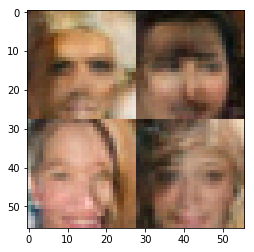

Epoch 10/30... Discriminator Loss: 1.1702... Generator Loss: 0.8062
Epoch 10/30... Discriminator Loss: 1.1728... Generator Loss: 0.6042
Epoch 10/30... Discriminator Loss: 1.2338... Generator Loss: 0.9129
Epoch 10/30... Discriminator Loss: 1.4984... Generator Loss: 2.6948
Epoch 10/30... Discriminator Loss: 1.4202... Generator Loss: 0.4336
Epoch 10/30... Discriminator Loss: 1.2450... Generator Loss: 0.8957
Epoch 10/30... Discriminator Loss: 1.1439... Generator Loss: 0.8857
Epoch 10/30... Discriminator Loss: 1.1774... Generator Loss: 0.8985
Epoch 10/30... Discriminator Loss: 2.1613... Generator Loss: 0.2093
Epoch 10/30... Discriminator Loss: 1.3522... Generator Loss: 1.0796


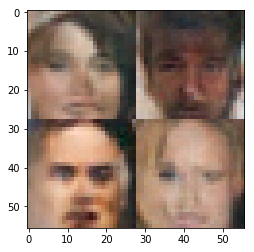

Epoch 10/30... Discriminator Loss: 1.3193... Generator Loss: 0.6475
Epoch 10/30... Discriminator Loss: 1.3445... Generator Loss: 0.4349
Epoch 10/30... Discriminator Loss: 1.1817... Generator Loss: 0.9245
Epoch 10/30... Discriminator Loss: 1.0741... Generator Loss: 1.7688
Epoch 10/30... Discriminator Loss: 1.4524... Generator Loss: 0.4172
Epoch 10/30... Discriminator Loss: 1.2238... Generator Loss: 0.8787
Epoch 10/30... Discriminator Loss: 1.1227... Generator Loss: 1.0188
Epoch 10/30... Discriminator Loss: 1.1905... Generator Loss: 0.7001
Epoch 10/30... Discriminator Loss: 1.2361... Generator Loss: 0.6893
Epoch 10/30... Discriminator Loss: 1.2940... Generator Loss: 0.6947


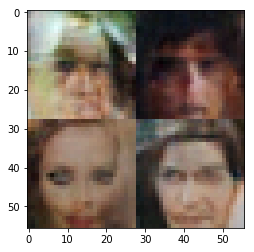

Epoch 10/30... Discriminator Loss: 1.3752... Generator Loss: 0.5064
Epoch 10/30... Discriminator Loss: 1.1954... Generator Loss: 0.9871
Epoch 10/30... Discriminator Loss: 1.3136... Generator Loss: 0.5536
Epoch 10/30... Discriminator Loss: 1.2812... Generator Loss: 0.6025
Epoch 10/30... Discriminator Loss: 1.2942... Generator Loss: 0.7372
Epoch 10/30... Discriminator Loss: 1.4520... Generator Loss: 0.6845
Epoch 10/30... Discriminator Loss: 1.6589... Generator Loss: 0.3276
Epoch 10/30... Discriminator Loss: 1.1783... Generator Loss: 0.7289
Epoch 10/30... Discriminator Loss: 1.3877... Generator Loss: 0.4186
Epoch 10/30... Discriminator Loss: 1.3275... Generator Loss: 0.8731


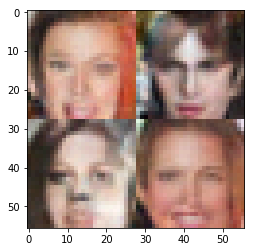

Epoch 10/30... Discriminator Loss: 1.3861... Generator Loss: 0.4948
Epoch 10/30... Discriminator Loss: 1.1089... Generator Loss: 1.3762
Epoch 10/30... Discriminator Loss: 1.3361... Generator Loss: 0.5485
Epoch 10/30... Discriminator Loss: 1.4332... Generator Loss: 0.7376
Epoch 10/30... Discriminator Loss: 1.2687... Generator Loss: 0.8432
Epoch 10/30... Discriminator Loss: 1.1523... Generator Loss: 0.7584
Epoch 10/30... Discriminator Loss: 1.2919... Generator Loss: 0.7967
Epoch 10/30... Discriminator Loss: 1.6659... Generator Loss: 0.3348
Epoch 10/30... Discriminator Loss: 1.0060... Generator Loss: 0.7736
Epoch 10/30... Discriminator Loss: 1.2582... Generator Loss: 0.6941


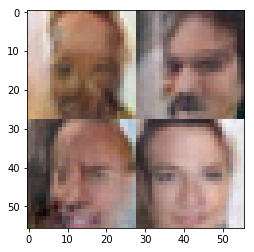

Epoch 10/30... Discriminator Loss: 1.2392... Generator Loss: 0.7917
Epoch 10/30... Discriminator Loss: 1.2321... Generator Loss: 0.7566
Epoch 10/30... Discriminator Loss: 1.5322... Generator Loss: 0.5255
Epoch 10/30... Discriminator Loss: 1.3074... Generator Loss: 0.8148
Epoch 10/30... Discriminator Loss: 1.3865... Generator Loss: 0.9658
Epoch 10/30... Discriminator Loss: 1.4588... Generator Loss: 1.0345
Epoch 10/30... Discriminator Loss: 1.3319... Generator Loss: 0.6310
Epoch 10/30... Discriminator Loss: 1.1925... Generator Loss: 1.1236
Epoch 10/30... Discriminator Loss: 1.0650... Generator Loss: 1.0045
Epoch 10/30... Discriminator Loss: 1.1878... Generator Loss: 0.9100


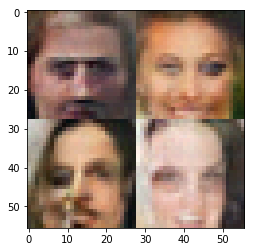

Epoch 10/30... Discriminator Loss: 1.2551... Generator Loss: 0.6661
Epoch 10/30... Discriminator Loss: 2.0035... Generator Loss: 1.4667
Epoch 10/30... Discriminator Loss: 1.3963... Generator Loss: 0.4549
Epoch 10/30... Discriminator Loss: 1.2537... Generator Loss: 0.7475
Epoch 10/30... Discriminator Loss: 1.2649... Generator Loss: 0.6249
Epoch 10/30... Discriminator Loss: 1.2837... Generator Loss: 0.7044
Epoch 10/30... Discriminator Loss: 1.3382... Generator Loss: 0.5107
Epoch 10/30... Discriminator Loss: 1.6046... Generator Loss: 0.4496
Epoch 10/30... Discriminator Loss: 1.3543... Generator Loss: 0.8380
Epoch 10/30... Discriminator Loss: 1.3241... Generator Loss: 0.7408


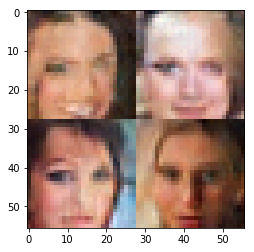

Epoch 10/30... Discriminator Loss: 1.2901... Generator Loss: 0.7582
Epoch 10/30... Discriminator Loss: 1.1001... Generator Loss: 0.9946
Epoch 10/30... Discriminator Loss: 1.1488... Generator Loss: 0.6757
Epoch 10/30... Discriminator Loss: 1.0332... Generator Loss: 1.0009
Epoch 10/30... Discriminator Loss: 1.4860... Generator Loss: 0.6917
Epoch 10/30... Discriminator Loss: 1.6668... Generator Loss: 0.3220
Epoch 10/30... Discriminator Loss: 1.2400... Generator Loss: 0.7300
Epoch 10/30... Discriminator Loss: 1.3946... Generator Loss: 0.6538
Epoch 10/30... Discriminator Loss: 1.2387... Generator Loss: 1.2204
Epoch 10/30... Discriminator Loss: 1.1485... Generator Loss: 0.6850


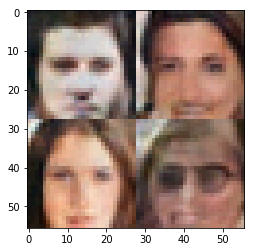

Epoch 10/30... Discriminator Loss: 1.2218... Generator Loss: 0.8403
Epoch 10/30... Discriminator Loss: 1.1301... Generator Loss: 0.9389
Epoch 10/30... Discriminator Loss: 1.1001... Generator Loss: 0.9372
Epoch 10/30... Discriminator Loss: 1.3737... Generator Loss: 0.5021
Epoch 10/30... Discriminator Loss: 1.4426... Generator Loss: 0.4040
Epoch 10/30... Discriminator Loss: 1.2683... Generator Loss: 0.7055
Epoch 10/30... Discriminator Loss: 1.3359... Generator Loss: 0.5234
Epoch 10/30... Discriminator Loss: 1.5077... Generator Loss: 0.4410
Epoch 10/30... Discriminator Loss: 1.0609... Generator Loss: 1.1748
Epoch 10/30... Discriminator Loss: 1.3319... Generator Loss: 0.5685


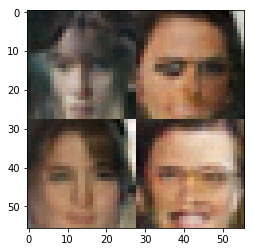

Epoch 10/30... Discriminator Loss: 1.2458... Generator Loss: 0.8450
Epoch 10/30... Discriminator Loss: 1.2116... Generator Loss: 0.7304
epoch_i 10
Epoch 11/30... Discriminator Loss: 1.1366... Generator Loss: 1.1287
Epoch 11/30... Discriminator Loss: 1.6585... Generator Loss: 1.2521
Epoch 11/30... Discriminator Loss: 1.3440... Generator Loss: 1.0043
Epoch 11/30... Discriminator Loss: 1.1644... Generator Loss: 0.7022
Epoch 11/30... Discriminator Loss: 1.3335... Generator Loss: 0.6305
Epoch 11/30... Discriminator Loss: 2.2125... Generator Loss: 1.4103
Epoch 11/30... Discriminator Loss: 1.3102... Generator Loss: 0.5772
Epoch 11/30... Discriminator Loss: 1.0781... Generator Loss: 0.6962


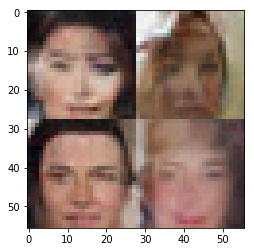

Epoch 11/30... Discriminator Loss: 1.3647... Generator Loss: 0.5116
Epoch 11/30... Discriminator Loss: 1.2638... Generator Loss: 1.5145
Epoch 11/30... Discriminator Loss: 1.1117... Generator Loss: 0.8815
Epoch 11/30... Discriminator Loss: 1.2392... Generator Loss: 0.7635
Epoch 11/30... Discriminator Loss: 1.0052... Generator Loss: 1.3619
Epoch 11/30... Discriminator Loss: 1.3342... Generator Loss: 1.2646
Epoch 11/30... Discriminator Loss: 1.3539... Generator Loss: 0.6490
Epoch 11/30... Discriminator Loss: 1.3601... Generator Loss: 1.2195
Epoch 11/30... Discriminator Loss: 1.3301... Generator Loss: 0.8657
Epoch 11/30... Discriminator Loss: 1.2916... Generator Loss: 0.8628


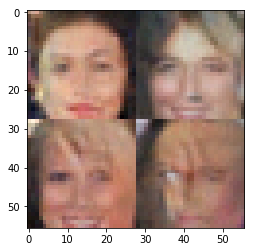

Epoch 11/30... Discriminator Loss: 1.6271... Generator Loss: 0.8673
Epoch 11/30... Discriminator Loss: 1.1582... Generator Loss: 0.8390
Epoch 11/30... Discriminator Loss: 1.3090... Generator Loss: 0.6415
Epoch 11/30... Discriminator Loss: 1.4365... Generator Loss: 1.3536
Epoch 11/30... Discriminator Loss: 1.1048... Generator Loss: 0.8890
Epoch 11/30... Discriminator Loss: 0.9780... Generator Loss: 1.1474
Epoch 11/30... Discriminator Loss: 1.1975... Generator Loss: 0.9672
Epoch 11/30... Discriminator Loss: 1.3705... Generator Loss: 0.5995
Epoch 11/30... Discriminator Loss: 1.4120... Generator Loss: 0.5976
Epoch 11/30... Discriminator Loss: 1.1147... Generator Loss: 0.8395


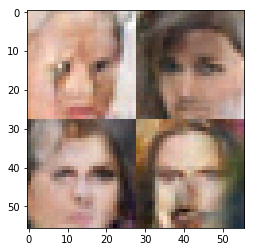

Epoch 11/30... Discriminator Loss: 1.3303... Generator Loss: 0.6991
Epoch 11/30... Discriminator Loss: 1.0026... Generator Loss: 1.0170
Epoch 11/30... Discriminator Loss: 1.3570... Generator Loss: 0.6668
Epoch 11/30... Discriminator Loss: 1.1001... Generator Loss: 1.1281
Epoch 11/30... Discriminator Loss: 1.1495... Generator Loss: 1.1148
Epoch 11/30... Discriminator Loss: 1.2836... Generator Loss: 1.0957
Epoch 11/30... Discriminator Loss: 1.3201... Generator Loss: 0.8806
Epoch 11/30... Discriminator Loss: 1.4830... Generator Loss: 0.4269
Epoch 11/30... Discriminator Loss: 1.8263... Generator Loss: 0.8619
Epoch 11/30... Discriminator Loss: 1.4035... Generator Loss: 0.5272


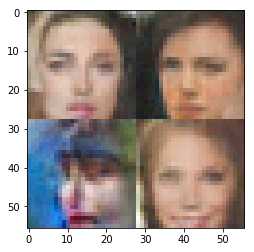

Epoch 11/30... Discriminator Loss: 1.3697... Generator Loss: 0.7853
Epoch 11/30... Discriminator Loss: 1.4686... Generator Loss: 1.1685
Epoch 11/30... Discriminator Loss: 1.5755... Generator Loss: 0.3391
Epoch 11/30... Discriminator Loss: 1.1815... Generator Loss: 0.9263
Epoch 11/30... Discriminator Loss: 1.1712... Generator Loss: 0.8835
Epoch 11/30... Discriminator Loss: 1.2965... Generator Loss: 1.0178
Epoch 11/30... Discriminator Loss: 1.2693... Generator Loss: 0.7726
Epoch 11/30... Discriminator Loss: 1.0457... Generator Loss: 0.7685
Epoch 11/30... Discriminator Loss: 1.2440... Generator Loss: 0.5477
Epoch 11/30... Discriminator Loss: 1.3651... Generator Loss: 0.5160


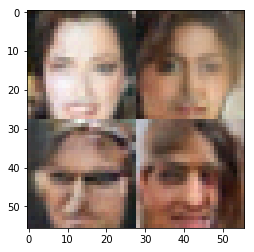

Epoch 11/30... Discriminator Loss: 1.2340... Generator Loss: 0.5950
Epoch 11/30... Discriminator Loss: 1.2448... Generator Loss: 0.6398
Epoch 11/30... Discriminator Loss: 1.2743... Generator Loss: 0.7407
Epoch 11/30... Discriminator Loss: 1.8985... Generator Loss: 1.8267
Epoch 11/30... Discriminator Loss: 1.4684... Generator Loss: 0.4417
Epoch 11/30... Discriminator Loss: 1.3704... Generator Loss: 0.5751
Epoch 11/30... Discriminator Loss: 1.1511... Generator Loss: 0.7208
Epoch 11/30... Discriminator Loss: 1.2022... Generator Loss: 0.8066
Epoch 11/30... Discriminator Loss: 1.1333... Generator Loss: 0.7291
Epoch 11/30... Discriminator Loss: 1.5571... Generator Loss: 0.7626


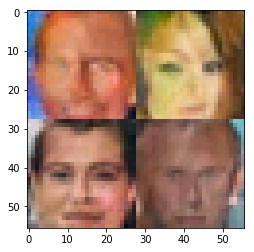

Epoch 11/30... Discriminator Loss: 1.2844... Generator Loss: 0.7687
Epoch 11/30... Discriminator Loss: 1.5183... Generator Loss: 0.5109
Epoch 11/30... Discriminator Loss: 1.5036... Generator Loss: 1.5104
Epoch 11/30... Discriminator Loss: 1.3600... Generator Loss: 0.7187
Epoch 11/30... Discriminator Loss: 1.3066... Generator Loss: 0.6683
Epoch 11/30... Discriminator Loss: 1.1789... Generator Loss: 0.7557
Epoch 11/30... Discriminator Loss: 1.4102... Generator Loss: 0.4699
Epoch 11/30... Discriminator Loss: 1.3659... Generator Loss: 0.6172
Epoch 11/30... Discriminator Loss: 1.5283... Generator Loss: 0.4113
Epoch 11/30... Discriminator Loss: 1.1184... Generator Loss: 1.2555


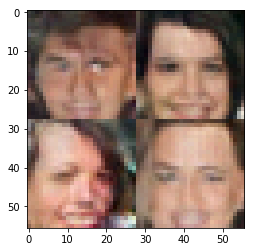

Epoch 11/30... Discriminator Loss: 1.2958... Generator Loss: 0.8298
Epoch 11/30... Discriminator Loss: 1.1502... Generator Loss: 0.8062
Epoch 11/30... Discriminator Loss: 1.3843... Generator Loss: 0.7635
Epoch 11/30... Discriminator Loss: 1.1008... Generator Loss: 1.2668
Epoch 11/30... Discriminator Loss: 1.3705... Generator Loss: 1.0053
Epoch 11/30... Discriminator Loss: 1.5858... Generator Loss: 0.3598
Epoch 11/30... Discriminator Loss: 1.2713... Generator Loss: 1.0201
Epoch 11/30... Discriminator Loss: 1.4065... Generator Loss: 0.9611
Epoch 11/30... Discriminator Loss: 1.3765... Generator Loss: 0.8088
Epoch 11/30... Discriminator Loss: 1.7207... Generator Loss: 0.9983


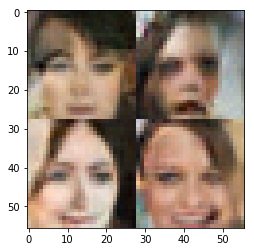

Epoch 11/30... Discriminator Loss: 1.3084... Generator Loss: 0.9469
Epoch 11/30... Discriminator Loss: 1.3464... Generator Loss: 0.4755
Epoch 11/30... Discriminator Loss: 1.5719... Generator Loss: 0.7163
Epoch 11/30... Discriminator Loss: 1.0132... Generator Loss: 1.0534
Epoch 11/30... Discriminator Loss: 1.1741... Generator Loss: 0.7890
Epoch 11/30... Discriminator Loss: 1.2442... Generator Loss: 0.8755
Epoch 11/30... Discriminator Loss: 1.3636... Generator Loss: 0.8775
Epoch 11/30... Discriminator Loss: 1.2824... Generator Loss: 1.1204
Epoch 11/30... Discriminator Loss: 1.4176... Generator Loss: 0.6586
Epoch 11/30... Discriminator Loss: 1.2965... Generator Loss: 1.0083


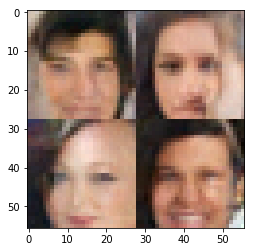

Epoch 11/30... Discriminator Loss: 1.4982... Generator Loss: 0.3907
Epoch 11/30... Discriminator Loss: 1.2815... Generator Loss: 1.0684
Epoch 11/30... Discriminator Loss: 1.1003... Generator Loss: 0.8567
Epoch 11/30... Discriminator Loss: 1.1673... Generator Loss: 0.7715
Epoch 11/30... Discriminator Loss: 1.0532... Generator Loss: 0.8561
Epoch 11/30... Discriminator Loss: 1.4086... Generator Loss: 0.5209
Epoch 11/30... Discriminator Loss: 1.1223... Generator Loss: 1.4585
Epoch 11/30... Discriminator Loss: 1.2426... Generator Loss: 0.6551
Epoch 11/30... Discriminator Loss: 1.2573... Generator Loss: 0.6953
Epoch 11/30... Discriminator Loss: 1.3692... Generator Loss: 0.4726


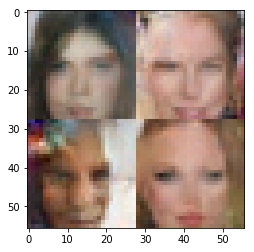

Epoch 11/30... Discriminator Loss: 1.2906... Generator Loss: 0.8104
Epoch 11/30... Discriminator Loss: 1.2591... Generator Loss: 2.1030
Epoch 11/30... Discriminator Loss: 1.2643... Generator Loss: 1.2442
Epoch 11/30... Discriminator Loss: 1.3162... Generator Loss: 0.6212
Epoch 11/30... Discriminator Loss: 1.1587... Generator Loss: 0.7398
Epoch 11/30... Discriminator Loss: 1.3803... Generator Loss: 0.4352
Epoch 11/30... Discriminator Loss: 1.5683... Generator Loss: 0.3558
Epoch 11/30... Discriminator Loss: 1.2597... Generator Loss: 0.6320
Epoch 11/30... Discriminator Loss: 1.3039... Generator Loss: 1.0796
Epoch 11/30... Discriminator Loss: 1.3536... Generator Loss: 0.5073


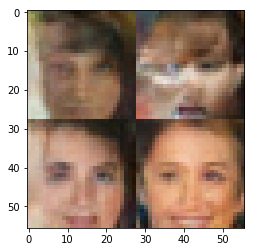

Epoch 11/30... Discriminator Loss: 1.4424... Generator Loss: 0.5527
Epoch 11/30... Discriminator Loss: 1.2868... Generator Loss: 0.8090
Epoch 11/30... Discriminator Loss: 1.1906... Generator Loss: 1.2949
Epoch 11/30... Discriminator Loss: 1.1371... Generator Loss: 1.4208
Epoch 11/30... Discriminator Loss: 1.2964... Generator Loss: 0.6007
Epoch 11/30... Discriminator Loss: 1.3454... Generator Loss: 0.5634
Epoch 11/30... Discriminator Loss: 1.3642... Generator Loss: 0.5291
Epoch 11/30... Discriminator Loss: 1.2158... Generator Loss: 0.9446
Epoch 11/30... Discriminator Loss: 1.2054... Generator Loss: 1.0142
Epoch 11/30... Discriminator Loss: 1.8474... Generator Loss: 1.2757


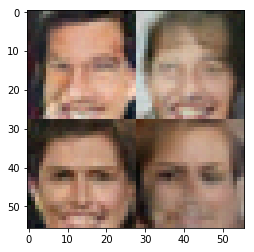

Epoch 11/30... Discriminator Loss: 1.3421... Generator Loss: 0.5528
Epoch 11/30... Discriminator Loss: 0.8224... Generator Loss: 1.1786
Epoch 11/30... Discriminator Loss: 1.5549... Generator Loss: 1.0265
Epoch 11/30... Discriminator Loss: 1.3943... Generator Loss: 0.7175
Epoch 11/30... Discriminator Loss: 1.5956... Generator Loss: 1.0795
Epoch 11/30... Discriminator Loss: 1.3605... Generator Loss: 1.3544
Epoch 11/30... Discriminator Loss: 1.0555... Generator Loss: 1.1489
Epoch 11/30... Discriminator Loss: 1.8052... Generator Loss: 1.3166
Epoch 11/30... Discriminator Loss: 1.3788... Generator Loss: 0.4763
Epoch 11/30... Discriminator Loss: 1.5001... Generator Loss: 0.5262


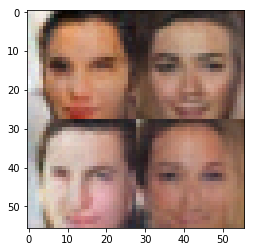

Epoch 11/30... Discriminator Loss: 1.4942... Generator Loss: 0.9021
Epoch 11/30... Discriminator Loss: 1.2658... Generator Loss: 0.6737
Epoch 11/30... Discriminator Loss: 1.4210... Generator Loss: 0.5487
Epoch 11/30... Discriminator Loss: 1.4212... Generator Loss: 1.2101
Epoch 11/30... Discriminator Loss: 1.2716... Generator Loss: 0.7567
Epoch 11/30... Discriminator Loss: 1.2389... Generator Loss: 0.6419
Epoch 11/30... Discriminator Loss: 1.3257... Generator Loss: 0.6101
Epoch 11/30... Discriminator Loss: 1.3345... Generator Loss: 0.7106
Epoch 11/30... Discriminator Loss: 1.1768... Generator Loss: 0.8790
Epoch 11/30... Discriminator Loss: 1.6003... Generator Loss: 0.3742


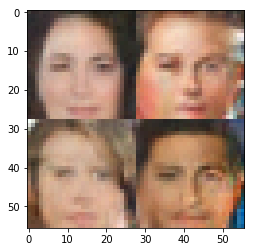

Epoch 11/30... Discriminator Loss: 1.3040... Generator Loss: 0.6398
Epoch 11/30... Discriminator Loss: 1.2806... Generator Loss: 1.0118
Epoch 11/30... Discriminator Loss: 1.3760... Generator Loss: 0.4529
Epoch 11/30... Discriminator Loss: 1.3577... Generator Loss: 0.7909
Epoch 11/30... Discriminator Loss: 1.4790... Generator Loss: 1.0712
Epoch 11/30... Discriminator Loss: 1.1738... Generator Loss: 0.8627
Epoch 11/30... Discriminator Loss: 1.3541... Generator Loss: 0.6691
Epoch 11/30... Discriminator Loss: 1.3484... Generator Loss: 0.7034
Epoch 11/30... Discriminator Loss: 1.1634... Generator Loss: 1.4715
Epoch 11/30... Discriminator Loss: 1.1940... Generator Loss: 0.5921


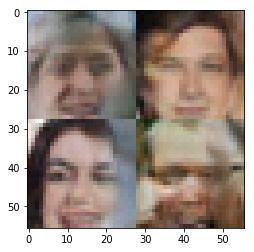

Epoch 11/30... Discriminator Loss: 1.3181... Generator Loss: 0.6555
Epoch 11/30... Discriminator Loss: 1.2451... Generator Loss: 1.1560
Epoch 11/30... Discriminator Loss: 1.3033... Generator Loss: 1.0605
Epoch 11/30... Discriminator Loss: 1.2259... Generator Loss: 1.0299
Epoch 11/30... Discriminator Loss: 1.2493... Generator Loss: 0.6481
Epoch 11/30... Discriminator Loss: 1.3496... Generator Loss: 1.1040
Epoch 11/30... Discriminator Loss: 1.1142... Generator Loss: 1.1340
Epoch 11/30... Discriminator Loss: 1.4290... Generator Loss: 0.4349
Epoch 11/30... Discriminator Loss: 0.9795... Generator Loss: 1.1754
Epoch 11/30... Discriminator Loss: 1.3745... Generator Loss: 1.4992


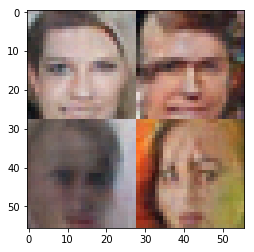

epoch_i 11
Epoch 12/30... Discriminator Loss: 1.3802... Generator Loss: 0.5532
Epoch 12/30... Discriminator Loss: 1.1910... Generator Loss: 1.0161
Epoch 12/30... Discriminator Loss: 1.2140... Generator Loss: 0.8474
Epoch 12/30... Discriminator Loss: 1.2980... Generator Loss: 0.6603
Epoch 12/30... Discriminator Loss: 1.3351... Generator Loss: 0.6297
Epoch 12/30... Discriminator Loss: 1.4566... Generator Loss: 1.3588
Epoch 12/30... Discriminator Loss: 1.5200... Generator Loss: 0.4163
Epoch 12/30... Discriminator Loss: 1.5852... Generator Loss: 0.3894
Epoch 12/30... Discriminator Loss: 1.3443... Generator Loss: 1.2701
Epoch 12/30... Discriminator Loss: 1.0234... Generator Loss: 1.1393


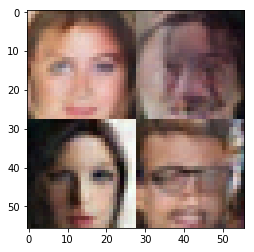

Epoch 12/30... Discriminator Loss: 1.5086... Generator Loss: 0.4302
Epoch 12/30... Discriminator Loss: 1.0382... Generator Loss: 0.9737
Epoch 12/30... Discriminator Loss: 0.7545... Generator Loss: 1.2868
Epoch 12/30... Discriminator Loss: 1.2946... Generator Loss: 1.3811
Epoch 12/30... Discriminator Loss: 1.3941... Generator Loss: 0.5433
Epoch 12/30... Discriminator Loss: 1.2350... Generator Loss: 0.8945
Epoch 12/30... Discriminator Loss: 1.2807... Generator Loss: 0.6754
Epoch 12/30... Discriminator Loss: 1.2990... Generator Loss: 0.6666
Epoch 12/30... Discriminator Loss: 1.2841... Generator Loss: 0.5823
Epoch 12/30... Discriminator Loss: 1.3245... Generator Loss: 0.5095


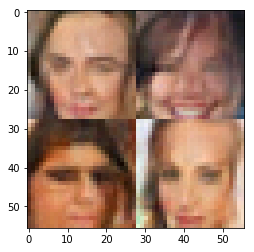

Epoch 12/30... Discriminator Loss: 1.0770... Generator Loss: 0.9731
Epoch 12/30... Discriminator Loss: 1.0292... Generator Loss: 1.2957
Epoch 12/30... Discriminator Loss: 1.0054... Generator Loss: 0.9505
Epoch 12/30... Discriminator Loss: 1.1594... Generator Loss: 0.9879
Epoch 12/30... Discriminator Loss: 1.2995... Generator Loss: 0.6060
Epoch 12/30... Discriminator Loss: 1.3508... Generator Loss: 0.6517
Epoch 12/30... Discriminator Loss: 1.1546... Generator Loss: 1.0288
Epoch 12/30... Discriminator Loss: 1.2374... Generator Loss: 0.9559
Epoch 12/30... Discriminator Loss: 1.3032... Generator Loss: 0.6774
Epoch 12/30... Discriminator Loss: 1.2051... Generator Loss: 0.6060


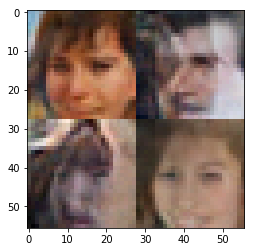

Epoch 12/30... Discriminator Loss: 1.1865... Generator Loss: 0.6477
Epoch 12/30... Discriminator Loss: 1.2367... Generator Loss: 0.7333
Epoch 12/30... Discriminator Loss: 1.9816... Generator Loss: 1.4833
Epoch 12/30... Discriminator Loss: 1.2811... Generator Loss: 0.9087
Epoch 12/30... Discriminator Loss: 1.3197... Generator Loss: 0.6012
Epoch 12/30... Discriminator Loss: 1.1600... Generator Loss: 0.9993
Epoch 12/30... Discriminator Loss: 1.5141... Generator Loss: 0.6897
Epoch 12/30... Discriminator Loss: 1.3072... Generator Loss: 0.6962
Epoch 12/30... Discriminator Loss: 1.3714... Generator Loss: 0.9544
Epoch 12/30... Discriminator Loss: 1.2698... Generator Loss: 1.0470


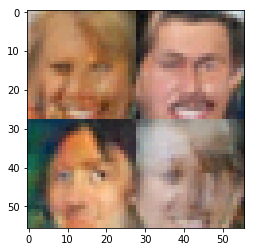

Epoch 12/30... Discriminator Loss: 1.3812... Generator Loss: 0.4548
Epoch 12/30... Discriminator Loss: 1.0689... Generator Loss: 0.7555
Epoch 12/30... Discriminator Loss: 1.3046... Generator Loss: 0.8048
Epoch 12/30... Discriminator Loss: 1.2911... Generator Loss: 0.6375
Epoch 12/30... Discriminator Loss: 1.3872... Generator Loss: 0.8287
Epoch 12/30... Discriminator Loss: 1.6275... Generator Loss: 1.2529
Epoch 12/30... Discriminator Loss: 1.4693... Generator Loss: 0.6887
Epoch 12/30... Discriminator Loss: 1.6139... Generator Loss: 0.3387
Epoch 12/30... Discriminator Loss: 1.2444... Generator Loss: 0.6752
Epoch 12/30... Discriminator Loss: 1.4534... Generator Loss: 0.5046


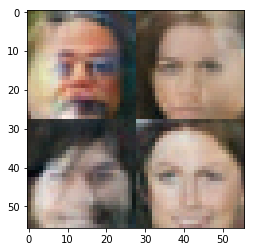

Epoch 12/30... Discriminator Loss: 1.8641... Generator Loss: 0.2245
Epoch 12/30... Discriminator Loss: 1.3837... Generator Loss: 0.5317
Epoch 12/30... Discriminator Loss: 1.2168... Generator Loss: 0.8704
Epoch 12/30... Discriminator Loss: 1.2650... Generator Loss: 0.6404
Epoch 12/30... Discriminator Loss: 1.4264... Generator Loss: 0.4039
Epoch 12/30... Discriminator Loss: 1.3498... Generator Loss: 0.6540
Epoch 12/30... Discriminator Loss: 1.2255... Generator Loss: 0.8249
Epoch 12/30... Discriminator Loss: 1.4083... Generator Loss: 0.5208
Epoch 12/30... Discriminator Loss: 1.2388... Generator Loss: 0.7399
Epoch 12/30... Discriminator Loss: 1.3018... Generator Loss: 1.0245


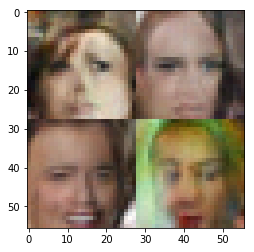

Epoch 12/30... Discriminator Loss: 1.4359... Generator Loss: 0.8020
Epoch 12/30... Discriminator Loss: 1.1719... Generator Loss: 0.8308
Epoch 12/30... Discriminator Loss: 1.1603... Generator Loss: 0.6400
Epoch 12/30... Discriminator Loss: 1.3263... Generator Loss: 0.7051
Epoch 12/30... Discriminator Loss: 1.3553... Generator Loss: 1.1844
Epoch 12/30... Discriminator Loss: 1.4801... Generator Loss: 0.7271
Epoch 12/30... Discriminator Loss: 1.2649... Generator Loss: 0.6288
Epoch 12/30... Discriminator Loss: 1.3861... Generator Loss: 0.6552
Epoch 12/30... Discriminator Loss: 1.1549... Generator Loss: 0.8119
Epoch 12/30... Discriminator Loss: 1.3690... Generator Loss: 0.4845


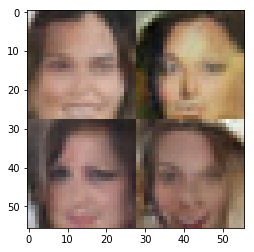

Epoch 12/30... Discriminator Loss: 1.5490... Generator Loss: 0.3986
Epoch 12/30... Discriminator Loss: 1.2807... Generator Loss: 0.6119
Epoch 12/30... Discriminator Loss: 1.2734... Generator Loss: 0.8493
Epoch 12/30... Discriminator Loss: 1.1733... Generator Loss: 0.9201
Epoch 12/30... Discriminator Loss: 1.3158... Generator Loss: 0.5888
Epoch 12/30... Discriminator Loss: 1.2037... Generator Loss: 0.8309
Epoch 12/30... Discriminator Loss: 1.1738... Generator Loss: 0.9626
Epoch 12/30... Discriminator Loss: 1.1917... Generator Loss: 1.0400
Epoch 12/30... Discriminator Loss: 1.2714... Generator Loss: 1.0599
Epoch 12/30... Discriminator Loss: 1.2600... Generator Loss: 0.8413


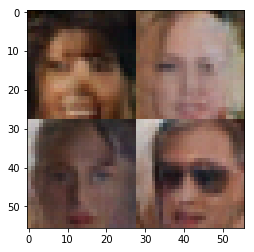

Epoch 12/30... Discriminator Loss: 1.3002... Generator Loss: 1.0011
Epoch 12/30... Discriminator Loss: 1.6126... Generator Loss: 0.3064
Epoch 12/30... Discriminator Loss: 1.1286... Generator Loss: 0.6829
Epoch 12/30... Discriminator Loss: 1.1710... Generator Loss: 0.6552
Epoch 12/30... Discriminator Loss: 1.3209... Generator Loss: 0.5202
Epoch 12/30... Discriminator Loss: 1.4636... Generator Loss: 0.4143
Epoch 12/30... Discriminator Loss: 1.5102... Generator Loss: 0.8511
Epoch 12/30... Discriminator Loss: 1.3990... Generator Loss: 0.4251
Epoch 12/30... Discriminator Loss: 1.4334... Generator Loss: 0.6533
Epoch 12/30... Discriminator Loss: 1.4228... Generator Loss: 0.8898


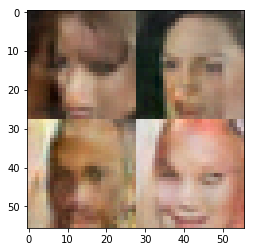

Epoch 12/30... Discriminator Loss: 1.6819... Generator Loss: 2.1414
Epoch 12/30... Discriminator Loss: 1.1879... Generator Loss: 1.0281
Epoch 12/30... Discriminator Loss: 1.5089... Generator Loss: 0.3970
Epoch 12/30... Discriminator Loss: 1.3944... Generator Loss: 0.5041
Epoch 12/30... Discriminator Loss: 1.4932... Generator Loss: 0.4667
Epoch 12/30... Discriminator Loss: 1.2296... Generator Loss: 0.8332
Epoch 12/30... Discriminator Loss: 1.0822... Generator Loss: 0.8430
Epoch 12/30... Discriminator Loss: 1.1583... Generator Loss: 0.7129
Epoch 12/30... Discriminator Loss: 1.3215... Generator Loss: 0.5285
Epoch 12/30... Discriminator Loss: 1.2636... Generator Loss: 0.5477


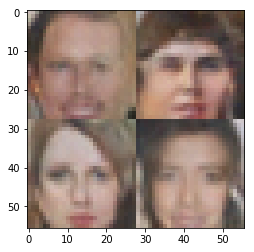

Epoch 12/30... Discriminator Loss: 1.2327... Generator Loss: 0.7744
Epoch 12/30... Discriminator Loss: 1.1856... Generator Loss: 0.7720
Epoch 12/30... Discriminator Loss: 1.3915... Generator Loss: 0.6720
Epoch 12/30... Discriminator Loss: 1.2954... Generator Loss: 0.5030
Epoch 12/30... Discriminator Loss: 1.4083... Generator Loss: 0.4380
Epoch 12/30... Discriminator Loss: 1.7229... Generator Loss: 0.2645
Epoch 12/30... Discriminator Loss: 1.4734... Generator Loss: 1.1458


In [ ]:
batch_size = 128
z_dim = 100
learning_rate = 0.0005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 30

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.